In [15]:
#general functions
from skimage import img_as_float
from skimage import img_as_ubyte
from skimage import filters
from tensorflow.keras.utils import img_to_array
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import OrderedDict
# visualization
from PIL import Image
# visualizing bounding boxes
import matplotlib.patches as patches
# CNN
import keras
from sklearn.model_selection import train_test_split
# Moving files between directories
import shutil
from shutil import unpack_archive
from subprocess import check_output
import pickle
from keras.models import load_model
import tensorflow as tf
from mtcnn import MTCNN
dataset_path = "datasets/images/"

In [2]:
# Data read-in and cleaning
data_allnames = pd.read_csv("datasets/lfw_allnames.csv")
matchpairsDevTest = pd.read_csv("datasets/matchpairsDevTest.csv")
matchpairsDevTrain = pd.read_csv("datasets/matchpairsDevTrain.csv")
mismatchpairsDevTest = pd.read_csv("datasets/mismatchpairsDevTest.csv")
mismatchpairsDevTrain = pd.read_csv("datasets/mismatchpairsDevTrain.csv")
pairs = pd.read_csv("datasets/pairs.csv")
# tidy pairs data: 
pairs = pairs.rename(columns ={'name': 'name1', 'Unnamed: 3': 'name2'})
matched_pairs = pairs[pairs["name2"].isnull()].drop("name2",axis=1)
mismatched_pairs = pairs[pairs["name2"].notnull()]
people = pd.read_csv("datasets/people.csv")
# remove null values
people = people[people.name.notnull()]
peopleDevTest = pd.read_csv("datasets/peopleDevTest.csv")
peopleDevTrain = pd.read_csv("datasets/peopleDevTrain.csv")

In [3]:
print("Summary:")
print("There are " + 
      str(data_allnames.shape[0]) + 
      " unique celebrities in the entire dataset, of whom " + 
      str(sum(data_allnames.images > 1)) + 
      " are represented by multiple images. The entire number of images available is " + 
      str(sum(data_allnames.images)) + 
      ". The most represented celebrity is " + 
      str(data_allnames.iloc[data_allnames['images'].idxmax()][0]) + 
      ", with " + 
      str(max(data_allnames.images)) + 
      " unique images in the dataset.")

Summary:
There are 5749 unique celebrities in the entire dataset, of whom 1680 are represented by multiple images. The entire number of images available is 13233. The most represented celebrity is George_W_Bush, with 530 unique images in the dataset.


In [4]:
# shape data frame so there is a row per image, matched to relevant jpg file
image_paths = data_allnames.loc[data_allnames.index.repeat(data_allnames['images'])]
image_paths['image_path'] = 1 + image_paths.groupby('name').cumcount()
image_paths['image_path'] = image_paths.image_path.apply(lambda x: '{0:0>4}'.format(x))
image_paths['image_path'] = image_paths.name + "/" + image_paths.name + "_" + image_paths.image_path + ".jpg"
image_paths = image_paths.drop("images",1)

# take a random sample: 80% of the data for the test set
lfw_train, lfw_test = train_test_split(image_paths, test_size=0.2)
lfw_train = lfw_train.reset_index().drop("index",1)
lfw_test = lfw_test.reset_index().drop("index",1)

# verify that there is a mix of seen and unseen individuals in the test set
print(len(set(lfw_train.name).intersection(set(lfw_test.name))))
print(len(set(lfw_test.name) - set(lfw_train.name)))

# both comprehensively non-empty - we are ok to procede.
# N.B. although we don't use this training/test split in the following model, this is the format of the data we
# would use in applying models to the full dataset


844
842


C:\Users\someone\AppData\Local\Temp\ipykernel_13952\317374145.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  image_paths = image_paths.drop("images",1)
C:\Users\someone\AppData\Local\Temp\ipykernel_13952\317374145.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  lfw_train = lfw_train.reset_index().drop("index",1)
C:\Users\someone\AppData\Local\Temp\ipykernel_13952\317374145.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  lfw_test = lfw_test.reset_index().drop("index",1)


In [6]:
# verify resolution of all images is consistent
widths = []
heights = []
files = image_paths.image_path
for file in files:
    path = dataset_path + str(file)
    im = Image.open(path)
    widths.append(im.width)
    heights.append(im.height)

pd.DataFrame({'height':heights,'width':widths}).describe()

# all 250 x 250 resolution

,height,width
count,13233.0,13233.0
mean,250.0,250.0
std,0.0,0.0
min,250.0,250.0
25%,250.0,250.0
50%,250.0,250.0
75%,250.0,250.0
max,250.0,250.0


530


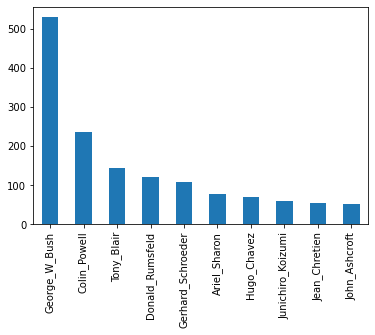

In [43]:
image_paths['name'].value_counts()[:10].plot(kind = "bar")
print(image_paths['name'].value_counts()[0])

In [8]:
ind_counts = image_paths.groupby('name').count().image_path
print(str(sum(ind_counts[ind_counts==1])) + " individuals, which is " + str(round(100*(sum(ind_counts[ind_counts==1])/sum(ind_counts)))) + "% of the total individuals considered, are only represented by a single image in this dataset.")

4069 individuals, which is 31% of the total individuals considered, are only represented by a single image in this dataset.


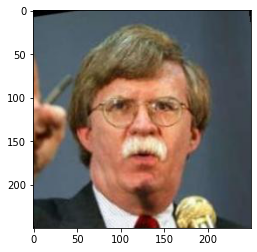

In [9]:
im = Image.open(dataset_path + str(lfw_train.image_path[0]))
plt.imshow(im)

1/1 [==============================] - 0s 156ms/step


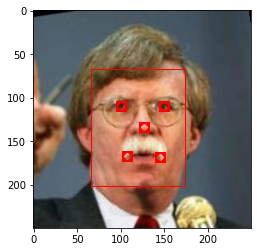

In [10]:
# Use out-of-the-box MTCNN algorithm to identify facial boundaries on a sample image
detector = MTCNN()
image = cv2.imread(dataset_path + str(lfw_train.image_path[0]))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
result = detector.detect_faces(image)
# That's it - the results have already been generated! Now we extract the boundaries that have been identified 
bounding_box = result[0]['box']
keypoints = result[0]['keypoints']

# Finally, we plot the image along with the face's bounding box and internal features (eyes, nose, and mouth corners)
fig,ax = plt.subplots(1)
ax.imshow(image)
# Create a Rectangle patch
rect = patches.Rectangle(bounding_box[0:2],bounding_box[2],bounding_box[3],linewidth=1,edgecolor='r',facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)
# Visualize all the internal features
for key in keypoints:
    rect_key = patches.Rectangle(keypoints[key],1,1,linewidth=10,edgecolor='r',facecolor='none')
    ax.add_patch(rect_key)
# Show the plots
plt.show()

In [11]:
not_george = image_paths[image_paths.name!="George_W_Bush"].sample(530)
not_george.name = "not_George"
GWB_data = pd.concat([image_paths[image_paths.name=="George_W_Bush"],
                     not_george])

In [12]:

model2 = load_model('final_model.h5')
model2.compile(optimizer = tf.keras.optimizers.Adamax (learning_rate=0.00001), loss = 'mean_absolute_error',
              metrics = ['acc'])

In [47]:
Bush_train_not_George_low = []
Bush_traiin_not_George_low = []
SIZE=256
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
def super_res(itrer_path,low_path,high_path):
    files = os.listdir(itrer_path)
    files = sorted_alphanumeric(files)
    for i in tqdm(files):
        if i == '855.jpg':
            break
        else: 
            img = cv2.imread(itrer_path + '/'+i,1)

            #resizing image
            img = cv2.resize(img, (SIZE, SIZE))
            img = img.astype('float32') / 255.0
            smooth = filters.gaussian(img_as_float(img), sigma=3)
            io.imsave(fname=low_path+"/"+i, arr=img_as_ubyte(smooth))
            Bush_train_not_George_low.append(img_to_array(smooth))
            Bush_traiin_not_George_low.append(img_to_array(img))
            img_high=np.clip(model2.predict(img_to_array(img).reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
            io.imsave(fname=high_path+"/"+i, arr=img_as_ubyte(img_high))
        
# SIZE=256
# path = 'working/Bush_train/not_George'
# root = 'datasets/low/Bush_train/not_George'
# root_high = 'datasets/high/Bush_train/not_George'
# files = os.listdir(path)
# files = sorted_alphanumeric(files)
# for i in tqdm(files):
#     if i == '855.jpg':
#         break
#     else: 
#         img = cv2.imread(path + '/'+i,1)

#         #resizing image
#         img = cv2.resize(img, (SIZE, SIZE))
#         img = img.astype('float32') / 255.0
#         Bush_train_not_George_low.append(img_to_array(img))
#         io.imsave(fname=root+"/"+i, arr=img_as_ubyte(img_to_array(img)))
        
#         img_high=np.clip(model2.predict(img_to_array(img).reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
#         io.imsave(fname=root_high+"/"+i, arr=img_as_ubyte(img_high))

super_res('working/Bush_train/not_George','datasets/low/Bush_train/not_George','datasets/high/Bush_train/not_George')
super_res('working/Bush_train/George_W_Bush','datasets/low/Bush_train/George_W_Bush','datasets/high/Bush_train/George_W_Bush')

super_res('working/Bush_test/not_George','datasets/low/Bush_test/not_George','datasets/high/Bush_test/not_George')
super_res('working/Bush_test/George_W_Bush','datasets/low/Bush_test/George_W_Bush','datasets/high/Bush_test/George_W_Bush')

super_res('working/Bush_val/not_George','datasets/low/Bush_val/not_George','datasets/high/Bush_val/not_George')
super_res('working/Bush_val/George_W_Bush','datasets/low/Bush_val/George_W_Bush','datasets/high/Bush_val/George_W_Bush')
        

  0%|                                                                                          | 0/652 [00:00<?, ?it/s]

1/1 [==============================] - 0s 125ms/step


  0%|▏                                                                                 | 1/652 [00:00<02:27,  4.41it/s]

1/1 [==============================] - 0s 109ms/step


  0%|▎                                                                                 | 2/652 [00:00<02:31,  4.29it/s]

1/1 [==============================] - 0s 125ms/step


  0%|▍                                                                                 | 3/652 [00:00<02:25,  4.46it/s]

1/1 [==============================] - 0s 125ms/step


  1%|▌                                                                                 | 4/652 [00:00<02:24,  4.48it/s]

1/1 [==============================] - 0s 140ms/step


  1%|▋                                                                                 | 5/652 [00:01<02:29,  4.34it/s]

1/1 [==============================] - 0s 125ms/step


  1%|▊                                                                                 | 6/652 [00:01<02:29,  4.33it/s]

1/1 [==============================] - 0s 125ms/step


  1%|▉                                                                                 | 7/652 [00:01<02:34,  4.18it/s]

1/1 [==============================] - 0s 109ms/step


  1%|█                                                                                 | 8/652 [00:01<02:32,  4.22it/s]

1/1 [==============================] - 0s 125ms/step


  1%|█▏                                                                                | 9/652 [00:02<02:32,  4.22it/s]

1/1 [==============================] - 0s 125ms/step


  2%|█▏                                                                               | 10/652 [00:02<02:25,  4.41it/s]

1/1 [==============================] - 0s 125ms/step


  2%|█▎                                                                               | 11/652 [00:02<02:30,  4.26it/s]

1/1 [==============================] - 0s 125ms/step


  2%|█▍                                                                               | 12/652 [00:02<02:26,  4.38it/s]

1/1 [==============================] - 0s 125ms/step


  2%|█▌                                                                               | 13/652 [00:03<02:27,  4.33it/s]

1/1 [==============================] - 0s 125ms/step


  2%|█▋                                                                               | 14/652 [00:03<02:27,  4.32it/s]

1/1 [==============================] - 0s 115ms/step


  2%|█▊                                                                               | 15/652 [00:03<02:30,  4.24it/s]

1/1 [==============================] - 0s 157ms/step


  2%|█▉                                                                               | 16/652 [00:03<02:46,  3.81it/s]

1/1 [==============================] - 0s 153ms/step


  3%|██                                                                               | 17/652 [00:04<02:51,  3.70it/s]

1/1 [==============================] - 0s 250ms/step


  3%|██▏                                                                              | 18/652 [00:04<03:46,  2.80it/s]

1/1 [==============================] - 0s 181ms/step


  3%|██▎                                                                              | 19/652 [00:05<03:45,  2.80it/s]

1/1 [==============================] - 0s 246ms/step


  3%|██▍                                                                              | 20/652 [00:05<03:51,  2.72it/s]

1/1 [==============================] - 0s 114ms/step


  3%|██▌                                                                              | 21/652 [00:05<03:30,  2.99it/s]

1/1 [==============================] - 0s 141ms/step


  3%|██▋                                                                              | 22/652 [00:05<03:11,  3.29it/s]

1/1 [==============================] - 0s 125ms/step


  4%|██▊                                                                              | 23/652 [00:06<02:55,  3.58it/s]

1/1 [==============================] - 0s 125ms/step


  4%|██▉                                                                              | 24/652 [00:06<02:49,  3.70it/s]

1/1 [==============================] - 0s 125ms/step


  4%|███                                                                              | 25/652 [00:06<02:43,  3.84it/s]

1/1 [==============================] - 0s 109ms/step


  4%|███▏                                                                             | 26/652 [00:06<02:33,  4.08it/s]

1/1 [==============================] - 0s 125ms/step


  4%|███▎                                                                             | 27/652 [00:07<02:31,  4.12it/s]

1/1 [==============================] - 0s 109ms/step


  4%|███▍                                                                             | 28/652 [00:07<02:28,  4.19it/s]

1/1 [==============================] - 0s 109ms/step


  4%|███▌                                                                             | 29/652 [00:07<02:49,  3.67it/s]

1/1 [==============================] - 0s 125ms/step


  5%|███▋                                                                             | 30/652 [00:07<02:40,  3.88it/s]

1/1 [==============================] - 0s 109ms/step


  5%|███▊                                                                             | 31/652 [00:08<02:37,  3.94it/s]

1/1 [==============================] - 0s 109ms/step


  5%|███▉                                                                             | 32/652 [00:08<02:29,  4.14it/s]

1/1 [==============================] - 0s 125ms/step


  5%|████                                                                             | 33/652 [00:08<02:26,  4.22it/s]

1/1 [==============================] - 0s 141ms/step


  5%|████▏                                                                            | 34/652 [00:08<02:43,  3.78it/s]

1/1 [==============================] - 0s 249ms/step


  5%|████▎                                                                            | 35/652 [00:09<03:20,  3.08it/s]

1/1 [==============================] - 0s 164ms/step


  6%|████▍                                                                            | 36/652 [00:09<03:25,  2.99it/s]

1/1 [==============================] - 0s 138ms/step


  6%|████▌                                                                            | 37/652 [00:09<03:15,  3.15it/s]

1/1 [==============================] - 0s 138ms/step


  6%|████▋                                                                            | 38/652 [00:10<02:59,  3.43it/s]

1/1 [==============================] - 0s 109ms/step


  6%|████▊                                                                            | 39/652 [00:10<02:43,  3.74it/s]

1/1 [==============================] - 0s 141ms/step


  6%|████▉                                                                            | 40/652 [00:10<02:43,  3.74it/s]

1/1 [==============================] - 0s 141ms/step


  6%|█████                                                                            | 41/652 [00:10<02:53,  3.53it/s]

1/1 [==============================] - 0s 125ms/step


  6%|█████▏                                                                           | 42/652 [00:11<02:57,  3.43it/s]

1/1 [==============================] - 0s 109ms/step


  7%|█████▎                                                                           | 43/652 [00:11<02:41,  3.77it/s]

1/1 [==============================] - 0s 109ms/step


  7%|█████▍                                                                           | 44/652 [00:11<02:30,  4.05it/s]

1/1 [==============================] - 0s 125ms/step


  7%|█████▌                                                                           | 45/652 [00:11<02:26,  4.14it/s]

1/1 [==============================] - 0s 125ms/step


  7%|█████▋                                                                           | 46/652 [00:12<02:23,  4.23it/s]

1/1 [==============================] - 0s 125ms/step


  7%|█████▊                                                                           | 47/652 [00:12<02:27,  4.11it/s]

1/1 [==============================] - 0s 109ms/step


  7%|█████▉                                                                           | 48/652 [00:12<02:31,  3.98it/s]

1/1 [==============================] - 0s 125ms/step


  8%|██████                                                                           | 49/652 [00:12<02:22,  4.22it/s]

1/1 [==============================] - 0s 110ms/step


  8%|██████▏                                                                          | 50/652 [00:13<02:17,  4.37it/s]

1/1 [==============================] - 0s 109ms/step


  8%|██████▎                                                                          | 51/652 [00:13<02:12,  4.54it/s]

1/1 [==============================] - 0s 141ms/step


  8%|██████▍                                                                          | 52/652 [00:13<02:20,  4.29it/s]

1/1 [==============================] - 0s 172ms/step


  8%|██████▌                                                                          | 53/652 [00:13<02:53,  3.45it/s]

1/1 [==============================] - 0s 125ms/step


  8%|██████▋                                                                          | 54/652 [00:14<02:43,  3.66it/s]

1/1 [==============================] - 0s 125ms/step


  8%|██████▊                                                                          | 55/652 [00:14<02:36,  3.82it/s]

1/1 [==============================] - 0s 109ms/step


  9%|██████▉                                                                          | 56/652 [00:14<02:35,  3.82it/s]

1/1 [==============================] - 0s 109ms/step


  9%|███████                                                                          | 57/652 [00:14<02:24,  4.10it/s]

1/1 [==============================] - 0s 109ms/step


  9%|███████▏                                                                         | 58/652 [00:15<02:22,  4.16it/s]

1/1 [==============================] - 0s 125ms/step


  9%|███████▎                                                                         | 59/652 [00:15<02:18,  4.27it/s]

1/1 [==============================] - 0s 141ms/step


  9%|███████▍                                                                         | 60/652 [00:15<02:19,  4.23it/s]

1/1 [==============================] - 0s 109ms/step


  9%|███████▌                                                                         | 61/652 [00:15<02:25,  4.07it/s]

1/1 [==============================] - 0s 109ms/step


 10%|███████▋                                                                         | 62/652 [00:16<02:17,  4.30it/s]

1/1 [==============================] - 0s 125ms/step


 10%|███████▊                                                                         | 63/652 [00:16<02:15,  4.34it/s]

1/1 [==============================] - 0s 125ms/step


 10%|███████▉                                                                         | 64/652 [00:16<02:18,  4.25it/s]

1/1 [==============================] - 0s 109ms/step


 10%|████████                                                                         | 65/652 [00:16<02:16,  4.31it/s]

1/1 [==============================] - 0s 109ms/step


 10%|████████▏                                                                        | 66/652 [00:17<02:13,  4.39it/s]

1/1 [==============================] - 0s 109ms/step


 10%|████████▎                                                                        | 67/652 [00:17<02:11,  4.46it/s]

1/1 [==============================] - 0s 125ms/step


 10%|████████▍                                                                        | 68/652 [00:17<02:10,  4.47it/s]

1/1 [==============================] - 0s 203ms/step


 11%|████████▌                                                                        | 69/652 [00:17<02:22,  4.10it/s]

1/1 [==============================] - 0s 156ms/step


 11%|████████▋                                                                        | 70/652 [00:18<02:40,  3.63it/s]

1/1 [==============================] - 0s 141ms/step


 11%|████████▊                                                                        | 71/652 [00:18<02:38,  3.68it/s]

1/1 [==============================] - 0s 125ms/step


 11%|████████▉                                                                        | 72/652 [00:18<02:28,  3.92it/s]

1/1 [==============================] - 0s 125ms/step


 11%|█████████                                                                        | 73/652 [00:18<02:27,  3.93it/s]

1/1 [==============================] - 0s 109ms/step


 11%|█████████▏                                                                       | 74/652 [00:19<02:18,  4.18it/s]

1/1 [==============================] - 0s 125ms/step


 12%|█████████▎                                                                       | 75/652 [00:19<02:17,  4.20it/s]

1/1 [==============================] - 0s 125ms/step


 12%|█████████▍                                                                       | 76/652 [00:19<02:16,  4.22it/s]

1/1 [==============================] - 0s 156ms/step


 12%|█████████▌                                                                       | 77/652 [00:19<02:16,  4.21it/s]

1/1 [==============================] - 0s 125ms/step


 12%|█████████▋                                                                       | 78/652 [00:19<02:15,  4.24it/s]

1/1 [==============================] - 0s 114ms/step


 12%|█████████▊                                                                       | 79/652 [00:20<02:10,  4.38it/s]

1/1 [==============================] - 0s 125ms/step


 12%|█████████▉                                                                       | 80/652 [00:20<02:07,  4.49it/s]

1/1 [==============================] - 0s 125ms/step


 12%|██████████                                                                       | 81/652 [00:20<02:10,  4.39it/s]

1/1 [==============================] - 0s 125ms/step


 13%|██████████▏                                                                      | 82/652 [00:20<02:05,  4.53it/s]

1/1 [==============================] - 0s 125ms/step


 13%|██████████▎                                                                      | 83/652 [00:21<02:09,  4.40it/s]

1/1 [==============================] - 0s 125ms/step


 13%|██████████▍                                                                      | 84/652 [00:21<02:08,  4.41it/s]

1/1 [==============================] - 0s 125ms/step


 13%|██████████▌                                                                      | 85/652 [00:21<02:09,  4.38it/s]

1/1 [==============================] - 0s 214ms/step


 13%|██████████▋                                                                      | 86/652 [00:21<02:26,  3.87it/s]

1/1 [==============================] - 0s 156ms/step


 13%|██████████▊                                                                      | 87/652 [00:22<02:41,  3.50it/s]

1/1 [==============================] - 0s 141ms/step


 13%|██████████▉                                                                      | 88/652 [00:22<02:33,  3.68it/s]

1/1 [==============================] - 0s 146ms/step


 14%|███████████                                                                      | 89/652 [00:22<02:30,  3.73it/s]

1/1 [==============================] - 0s 141ms/step


 14%|███████████▏                                                                     | 90/652 [00:23<02:37,  3.56it/s]

1/1 [==============================] - 0s 125ms/step


 14%|███████████▎                                                                     | 91/652 [00:23<02:32,  3.68it/s]

1/1 [==============================] - 0s 141ms/step


 14%|███████████▍                                                                     | 92/652 [00:23<02:33,  3.66it/s]

1/1 [==============================] - 0s 172ms/step


 14%|███████████▌                                                                     | 93/652 [00:23<02:37,  3.56it/s]

1/1 [==============================] - 0s 141ms/step


 14%|███████████▋                                                                     | 94/652 [00:24<02:31,  3.69it/s]

1/1 [==============================] - 0s 109ms/step


 15%|███████████▊                                                                     | 95/652 [00:24<02:19,  3.99it/s]

1/1 [==============================] - 0s 109ms/step


 15%|███████████▉                                                                     | 96/652 [00:24<02:15,  4.09it/s]

1/1 [==============================] - 0s 125ms/step


 15%|████████████                                                                     | 97/652 [00:24<02:09,  4.29it/s]

1/1 [==============================] - 0s 125ms/step


 15%|████████████▏                                                                    | 98/652 [00:24<02:09,  4.29it/s]

1/1 [==============================] - 0s 109ms/step


 15%|████████████▎                                                                    | 99/652 [00:25<02:07,  4.33it/s]

1/1 [==============================] - 0s 109ms/step


 15%|████████████▎                                                                   | 100/652 [00:25<02:03,  4.47it/s]

1/1 [==============================] - 0s 141ms/step


 15%|████████████▍                                                                   | 101/652 [00:25<02:03,  4.47it/s]

1/1 [==============================] - 0s 109ms/step


 16%|████████████▌                                                                   | 102/652 [00:25<02:05,  4.39it/s]

1/1 [==============================] - 0s 125ms/step


 16%|████████████▋                                                                   | 103/652 [00:26<02:02,  4.49it/s]

1/1 [==============================] - 0s 109ms/step


 16%|████████████▊                                                                   | 104/652 [00:26<02:08,  4.27it/s]

1/1 [==============================] - 0s 156ms/step


 16%|████████████▉                                                                   | 105/652 [00:26<02:32,  3.58it/s]

1/1 [==============================] - 0s 125ms/step


 16%|█████████████                                                                   | 106/652 [00:26<02:28,  3.67it/s]

1/1 [==============================] - 0s 125ms/step


 16%|█████████████▏                                                                  | 107/652 [00:27<02:24,  3.77it/s]

1/1 [==============================] - 0s 156ms/step


 17%|█████████████▎                                                                  | 108/652 [00:27<02:34,  3.52it/s]

1/1 [==============================] - 0s 141ms/step


 17%|█████████████▎                                                                  | 109/652 [00:27<02:39,  3.41it/s]

1/1 [==============================] - 0s 141ms/step


 17%|█████████████▍                                                                  | 110/652 [00:28<02:33,  3.53it/s]

1/1 [==============================] - 0s 141ms/step


 17%|█████████████▌                                                                  | 111/652 [00:28<02:29,  3.61it/s]

1/1 [==============================] - 0s 141ms/step


 17%|█████████████▋                                                                  | 112/652 [00:28<02:27,  3.67it/s]

1/1 [==============================] - 0s 109ms/step


 17%|█████████████▊                                                                  | 113/652 [00:28<02:17,  3.93it/s]

1/1 [==============================] - 0s 125ms/step


 17%|█████████████▉                                                                  | 114/652 [00:29<02:16,  3.94it/s]

1/1 [==============================] - 0s 109ms/step


 18%|██████████████                                                                  | 115/652 [00:29<02:11,  4.07it/s]

1/1 [==============================] - 0s 125ms/step


 18%|██████████████▏                                                                 | 116/652 [00:29<02:20,  3.81it/s]

1/1 [==============================] - 0s 109ms/step


 18%|██████████████▎                                                                 | 117/652 [00:29<02:11,  4.07it/s]

1/1 [==============================] - 0s 125ms/step


 18%|██████████████▍                                                                 | 118/652 [00:30<02:08,  4.16it/s]

1/1 [==============================] - 0s 125ms/step


 18%|██████████████▌                                                                 | 119/652 [00:30<02:02,  4.35it/s]

1/1 [==============================] - 0s 156ms/step


 18%|██████████████▋                                                                 | 120/652 [00:30<02:26,  3.63it/s]

1/1 [==============================] - 0s 125ms/step


 19%|██████████████▊                                                                 | 121/652 [00:30<02:32,  3.47it/s]

1/1 [==============================] - 0s 141ms/step


 19%|██████████████▉                                                                 | 122/652 [00:31<02:25,  3.64it/s]

1/1 [==============================] - 0s 125ms/step


 19%|███████████████                                                                 | 123/652 [00:31<02:16,  3.86it/s]

1/1 [==============================] - 0s 109ms/step


 19%|███████████████▏                                                                | 124/652 [00:31<02:10,  4.04it/s]

1/1 [==============================] - 0s 141ms/step


 19%|███████████████▎                                                                | 125/652 [00:31<02:11,  4.01it/s]

1/1 [==============================] - 0s 141ms/step


 19%|███████████████▍                                                                | 126/652 [00:32<02:17,  3.83it/s]

1/1 [==============================] - 0s 156ms/step


 19%|███████████████▌                                                                | 127/652 [00:32<02:23,  3.65it/s]

1/1 [==============================] - 0s 141ms/step


 20%|███████████████▋                                                                | 128/652 [00:32<02:40,  3.27it/s]

1/1 [==============================] - 0s 141ms/step


 20%|███████████████▊                                                                | 129/652 [00:33<02:30,  3.47it/s]

1/1 [==============================] - 0s 125ms/step


 20%|███████████████▉                                                                | 130/652 [00:33<02:23,  3.63it/s]

1/1 [==============================] - 0s 109ms/step


 20%|████████████████                                                                | 131/652 [00:33<02:25,  3.57it/s]

1/1 [==============================] - 0s 109ms/step


 20%|████████████████▏                                                               | 132/652 [00:33<02:14,  3.87it/s]

1/1 [==============================] - 0s 125ms/step


 20%|████████████████▎                                                               | 133/652 [00:34<02:09,  4.01it/s]

1/1 [==============================] - 0s 109ms/step


 21%|████████████████▍                                                               | 134/652 [00:34<02:05,  4.12it/s]

1/1 [==============================] - 0s 109ms/step


 21%|████████████████▌                                                               | 135/652 [00:34<02:03,  4.18it/s]

1/1 [==============================] - 0s 125ms/step


 21%|████████████████▋                                                               | 136/652 [00:34<02:03,  4.18it/s]

1/1 [==============================] - 0s 141ms/step


 21%|████████████████▊                                                               | 137/652 [00:35<02:08,  4.00it/s]

1/1 [==============================] - 0s 125ms/step


 21%|████████████████▉                                                               | 138/652 [00:35<03:16,  2.61it/s]

1/1 [==============================] - 0s 109ms/step


 21%|█████████████████                                                               | 139/652 [00:35<02:49,  3.02it/s]

1/1 [==============================] - 0s 109ms/step


 21%|█████████████████▏                                                              | 140/652 [00:36<02:33,  3.34it/s]

1/1 [==============================] - 0s 109ms/step


 22%|█████████████████▎                                                              | 141/652 [00:36<02:19,  3.67it/s]

1/1 [==============================] - 0s 125ms/step


 22%|█████████████████▍                                                              | 142/652 [00:36<02:10,  3.90it/s]

1/1 [==============================] - 0s 125ms/step


 22%|█████████████████▌                                                              | 143/652 [00:36<02:07,  4.01it/s]

1/1 [==============================] - 0s 125ms/step


 22%|█████████████████▋                                                              | 144/652 [00:37<02:06,  4.00it/s]

1/1 [==============================] - 0s 125ms/step


 22%|█████████████████▊                                                              | 145/652 [00:37<02:03,  4.11it/s]

1/1 [==============================] - 0s 125ms/step


 22%|█████████████████▉                                                              | 146/652 [00:37<01:58,  4.28it/s]

1/1 [==============================] - 0s 125ms/step


 23%|██████████████████                                                              | 147/652 [00:37<01:59,  4.24it/s]

1/1 [==============================] - 0s 109ms/step


 23%|██████████████████▏                                                             | 148/652 [00:38<01:56,  4.33it/s]

1/1 [==============================] - 0s 115ms/step


 23%|██████████████████▎                                                             | 149/652 [00:38<01:52,  4.48it/s]

1/1 [==============================] - 0s 109ms/step


 23%|██████████████████▍                                                             | 150/652 [00:38<01:49,  4.58it/s]

1/1 [==============================] - 0s 156ms/step


 23%|██████████████████▌                                                             | 151/652 [00:38<02:11,  3.80it/s]

1/1 [==============================] - 0s 109ms/step


 23%|██████████████████▋                                                             | 152/652 [00:39<02:03,  4.04it/s]

1/1 [==============================] - 0s 125ms/step


 23%|██████████████████▊                                                             | 153/652 [00:39<02:01,  4.12it/s]

1/1 [==============================] - 0s 109ms/step


 24%|██████████████████▉                                                             | 154/652 [00:39<01:57,  4.23it/s]

1/1 [==============================] - 0s 250ms/step


 24%|███████████████████                                                             | 155/652 [00:39<02:15,  3.67it/s]

1/1 [==============================] - 0s 141ms/step


 24%|███████████████████▏                                                            | 156/652 [00:40<02:22,  3.49it/s]

1/1 [==============================] - 0s 109ms/step


 24%|███████████████████▎                                                            | 157/652 [00:40<02:10,  3.79it/s]

1/1 [==============================] - 0s 125ms/step


 24%|███████████████████▍                                                            | 158/652 [00:40<02:05,  3.95it/s]

1/1 [==============================] - 0s 125ms/step


 24%|███████████████████▌                                                            | 159/652 [00:40<02:02,  4.02it/s]

1/1 [==============================] - 0s 141ms/step


 25%|███████████████████▋                                                            | 160/652 [00:41<02:06,  3.88it/s]

1/1 [==============================] - 0s 172ms/step


 25%|███████████████████▊                                                            | 161/652 [00:41<02:09,  3.80it/s]

1/1 [==============================] - 0s 139ms/step


 25%|███████████████████▉                                                            | 162/652 [00:41<02:10,  3.74it/s]

1/1 [==============================] - 0s 141ms/step


 25%|████████████████████                                                            | 163/652 [00:41<02:11,  3.73it/s]

1/1 [==============================] - 0s 125ms/step


 25%|████████████████████                                                            | 164/652 [00:42<02:22,  3.44it/s]

1/1 [==============================] - 0s 141ms/step


 25%|████████████████████▏                                                           | 165/652 [00:42<02:14,  3.61it/s]

1/1 [==============================] - 0s 125ms/step


 25%|████████████████████▎                                                           | 166/652 [00:42<02:08,  3.79it/s]

1/1 [==============================] - 0s 125ms/step


 26%|████████████████████▍                                                           | 167/652 [00:42<02:04,  3.89it/s]

1/1 [==============================] - 0s 109ms/step


 26%|████████████████████▌                                                           | 168/652 [00:43<01:58,  4.08it/s]

1/1 [==============================] - 0s 125ms/step


 26%|████████████████████▋                                                           | 169/652 [00:43<01:53,  4.27it/s]

1/1 [==============================] - 0s 109ms/step


 26%|████████████████████▊                                                           | 170/652 [00:43<01:53,  4.25it/s]

1/1 [==============================] - 0s 141ms/step


 26%|████████████████████▉                                                           | 171/652 [00:43<01:54,  4.19it/s]

1/1 [==============================] - 0s 109ms/step


 26%|█████████████████████                                                           | 172/652 [00:44<01:51,  4.29it/s]

1/1 [==============================] - 0s 156ms/step


 27%|█████████████████████▏                                                          | 173/652 [00:44<02:11,  3.65it/s]

1/1 [==============================] - 0s 156ms/step


 27%|█████████████████████▎                                                          | 174/652 [00:44<02:20,  3.41it/s]

1/1 [==============================] - 0s 109ms/step


 27%|█████████████████████▍                                                          | 175/652 [00:45<02:13,  3.59it/s]

1/1 [==============================] - 0s 141ms/step


 27%|█████████████████████▌                                                          | 176/652 [00:45<02:10,  3.66it/s]

1/1 [==============================] - 0s 125ms/step


 27%|█████████████████████▋                                                          | 177/652 [00:45<02:07,  3.73it/s]

1/1 [==============================] - 0s 156ms/step


 27%|█████████████████████▊                                                          | 178/652 [00:45<02:20,  3.38it/s]

1/1 [==============================] - 0s 141ms/step


 27%|█████████████████████▉                                                          | 179/652 [00:46<02:15,  3.50it/s]

1/1 [==============================] - 0s 141ms/step


 28%|██████████████████████                                                          | 180/652 [00:46<02:23,  3.29it/s]

1/1 [==============================] - 0s 125ms/step


 28%|██████████████████████▏                                                         | 181/652 [00:46<02:26,  3.21it/s]

1/1 [==============================] - 0s 141ms/step


 28%|██████████████████████▎                                                         | 182/652 [00:47<02:16,  3.45it/s]

1/1 [==============================] - 0s 109ms/step


 28%|██████████████████████▍                                                         | 183/652 [00:47<02:04,  3.76it/s]

1/1 [==============================] - 0s 125ms/step


 28%|██████████████████████▌                                                         | 184/652 [00:47<02:00,  3.88it/s]

1/1 [==============================] - 0s 109ms/step


 28%|██████████████████████▋                                                         | 185/652 [00:47<01:55,  4.04it/s]

1/1 [==============================] - 0s 125ms/step


 29%|██████████████████████▊                                                         | 186/652 [00:48<01:52,  4.16it/s]

1/1 [==============================] - 0s 109ms/step


 29%|██████████████████████▉                                                         | 187/652 [00:48<01:56,  3.98it/s]

1/1 [==============================] - 0s 125ms/step


 29%|███████████████████████                                                         | 188/652 [00:48<01:50,  4.18it/s]

1/1 [==============================] - 0s 125ms/step


 29%|███████████████████████▏                                                        | 189/652 [00:48<01:46,  4.33it/s]

1/1 [==============================] - 0s 177ms/step


 29%|███████████████████████▎                                                        | 190/652 [00:49<02:00,  3.82it/s]

1/1 [==============================] - 0s 172ms/step


 29%|███████████████████████▍                                                        | 191/652 [00:49<02:09,  3.56it/s]

1/1 [==============================] - 0s 125ms/step


 29%|███████████████████████▌                                                        | 192/652 [00:49<02:05,  3.67it/s]

1/1 [==============================] - 0s 125ms/step


 30%|███████████████████████▋                                                        | 193/652 [00:49<02:15,  3.39it/s]

1/1 [==============================] - 0s 125ms/step


 30%|███████████████████████▊                                                        | 194/652 [00:50<02:07,  3.60it/s]

1/1 [==============================] - 0s 109ms/step


 30%|███████████████████████▉                                                        | 195/652 [00:50<01:56,  3.92it/s]

1/1 [==============================] - 0s 156ms/step


 30%|████████████████████████                                                        | 196/652 [00:50<01:57,  3.89it/s]

1/1 [==============================] - 0s 125ms/step


 30%|████████████████████████▏                                                       | 197/652 [00:50<01:54,  3.97it/s]

1/1 [==============================] - 0s 125ms/step


 30%|████████████████████████▎                                                       | 198/652 [00:51<01:52,  4.04it/s]

1/1 [==============================] - 0s 109ms/step


 31%|████████████████████████▍                                                       | 199/652 [00:51<01:46,  4.26it/s]

1/1 [==============================] - 0s 125ms/step


 31%|████████████████████████▌                                                       | 200/652 [00:51<01:48,  4.17it/s]

1/1 [==============================] - 0s 141ms/step


 31%|████████████████████████▋                                                       | 201/652 [00:51<01:51,  4.04it/s]

1/1 [==============================] - 0s 156ms/step


 31%|████████████████████████▊                                                       | 202/652 [00:52<02:03,  3.64it/s]

1/1 [==============================] - 0s 125ms/step


 31%|████████████████████████▉                                                       | 203/652 [00:52<02:00,  3.72it/s]

1/1 [==============================] - 0s 141ms/step


 31%|█████████████████████████                                                       | 204/652 [00:52<02:01,  3.70it/s]

1/1 [==============================] - 0s 141ms/step


 31%|█████████████████████████▏                                                      | 205/652 [00:53<01:58,  3.78it/s]

1/1 [==============================] - 0s 141ms/step


 32%|█████████████████████████▎                                                      | 206/652 [00:53<01:56,  3.83it/s]

1/1 [==============================] - 0s 141ms/step


 32%|█████████████████████████▍                                                      | 207/652 [00:53<01:54,  3.90it/s]

1/1 [==============================] - 0s 281ms/step


 32%|█████████████████████████▌                                                      | 208/652 [00:54<02:35,  2.86it/s]

1/1 [==============================] - 0s 156ms/step


 32%|█████████████████████████▋                                                      | 209/652 [00:54<02:30,  2.94it/s]

1/1 [==============================] - 0s 141ms/step


 32%|█████████████████████████▊                                                      | 210/652 [00:54<02:21,  3.12it/s]

1/1 [==============================] - 0s 141ms/step


 32%|█████████████████████████▉                                                      | 211/652 [00:54<02:23,  3.07it/s]

1/1 [==============================] - 0s 141ms/step


 33%|██████████████████████████                                                      | 212/652 [00:55<02:15,  3.24it/s]

1/1 [==============================] - 0s 141ms/step


 33%|██████████████████████████▏                                                     | 213/652 [00:55<02:22,  3.07it/s]

1/1 [==============================] - 0s 141ms/step


 33%|██████████████████████████▎                                                     | 214/652 [00:55<02:19,  3.14it/s]

1/1 [==============================] - 0s 141ms/step


 33%|██████████████████████████▍                                                     | 215/652 [00:56<02:11,  3.32it/s]

1/1 [==============================] - 0s 125ms/step


 33%|██████████████████████████▌                                                     | 216/652 [00:56<02:10,  3.33it/s]

1/1 [==============================] - 0s 109ms/step


 33%|██████████████████████████▋                                                     | 217/652 [00:56<01:58,  3.66it/s]

1/1 [==============================] - 0s 125ms/step


 33%|██████████████████████████▋                                                     | 218/652 [00:56<01:49,  3.96it/s]

1/1 [==============================] - 0s 116ms/step


 34%|██████████████████████████▊                                                     | 219/652 [00:57<01:42,  4.21it/s]

1/1 [==============================] - 0s 109ms/step


 34%|██████████████████████████▉                                                     | 220/652 [00:57<01:39,  4.34it/s]

1/1 [==============================] - 0s 109ms/step


 34%|███████████████████████████                                                     | 221/652 [00:57<01:39,  4.32it/s]

1/1 [==============================] - 0s 109ms/step


 34%|███████████████████████████▏                                                    | 222/652 [00:57<01:49,  3.92it/s]

1/1 [==============================] - 0s 109ms/step


 34%|███████████████████████████▎                                                    | 223/652 [00:58<01:43,  4.13it/s]

1/1 [==============================] - 0s 172ms/step


 34%|███████████████████████████▍                                                    | 224/652 [00:58<01:50,  3.88it/s]

1/1 [==============================] - 0s 156ms/step


 35%|███████████████████████████▌                                                    | 225/652 [00:58<02:04,  3.44it/s]

1/1 [==============================] - 0s 141ms/step


 35%|███████████████████████████▋                                                    | 226/652 [00:59<02:05,  3.40it/s]

1/1 [==============================] - 0s 141ms/step


 35%|███████████████████████████▊                                                    | 227/652 [00:59<02:00,  3.52it/s]

1/1 [==============================] - 0s 156ms/step


 35%|███████████████████████████▉                                                    | 228/652 [00:59<02:02,  3.47it/s]

1/1 [==============================] - 0s 141ms/step


 35%|████████████████████████████                                                    | 229/652 [00:59<01:57,  3.61it/s]

1/1 [==============================] - 0s 141ms/step


 35%|████████████████████████████▏                                                   | 230/652 [01:00<01:59,  3.52it/s]

1/1 [==============================] - 0s 156ms/step


 35%|████████████████████████████▎                                                   | 231/652 [01:00<02:01,  3.47it/s]

1/1 [==============================] - 0s 141ms/step


 36%|████████████████████████████▍                                                   | 232/652 [01:00<01:56,  3.61it/s]

1/1 [==============================] - 0s 141ms/step


 36%|████████████████████████████▌                                                   | 233/652 [01:00<01:52,  3.73it/s]

1/1 [==============================] - 0s 141ms/step


 36%|████████████████████████████▋                                                   | 234/652 [01:01<01:54,  3.65it/s]

1/1 [==============================] - 0s 141ms/step


 36%|████████████████████████████▊                                                   | 235/652 [01:01<01:51,  3.75it/s]

1/1 [==============================] - 0s 141ms/step


 36%|████████████████████████████▉                                                   | 236/652 [01:01<01:48,  3.82it/s]

1/1 [==============================] - 0s 125ms/step


 36%|█████████████████████████████                                                   | 237/652 [01:01<01:48,  3.82it/s]

1/1 [==============================] - 0s 151ms/step


 37%|█████████████████████████████▏                                                  | 238/652 [01:02<01:48,  3.81it/s]

1/1 [==============================] - 0s 125ms/step


 37%|█████████████████████████████▎                                                  | 239/652 [01:02<01:45,  3.90it/s]

1/1 [==============================] - 0s 141ms/step


 37%|█████████████████████████████▍                                                  | 240/652 [01:02<01:44,  3.95it/s]

1/1 [==============================] - 0s 234ms/step


 37%|█████████████████████████████▌                                                  | 241/652 [01:03<02:00,  3.41it/s]

1/1 [==============================] - 0s 187ms/step


 37%|█████████████████████████████▋                                                  | 242/652 [01:03<02:16,  2.99it/s]

1/1 [==============================] - 0s 172ms/step


 37%|█████████████████████████████▊                                                  | 243/652 [01:03<02:14,  3.03it/s]

1/1 [==============================] - 0s 156ms/step


 37%|█████████████████████████████▉                                                  | 244/652 [01:04<02:06,  3.22it/s]

1/1 [==============================] - 0s 141ms/step


 38%|██████████████████████████████                                                  | 245/652 [01:04<01:59,  3.41it/s]

1/1 [==============================] - 0s 172ms/step


 38%|██████████████████████████████▏                                                 | 246/652 [01:04<01:56,  3.49it/s]

1/1 [==============================] - 0s 172ms/step


 38%|██████████████████████████████▎                                                 | 247/652 [01:05<02:06,  3.20it/s]

1/1 [==============================] - 0s 141ms/step


 38%|██████████████████████████████▍                                                 | 248/652 [01:05<01:59,  3.38it/s]

1/1 [==============================] - 0s 156ms/step


 38%|██████████████████████████████▌                                                 | 249/652 [01:05<01:55,  3.49it/s]

1/1 [==============================] - 0s 141ms/step


 38%|██████████████████████████████▋                                                 | 250/652 [01:05<01:50,  3.63it/s]

1/1 [==============================] - 0s 141ms/step


 38%|██████████████████████████████▊                                                 | 251/652 [01:06<01:48,  3.69it/s]

1/1 [==============================] - 0s 156ms/step


 39%|██████████████████████████████▉                                                 | 252/652 [01:06<01:55,  3.45it/s]

1/1 [==============================] - 0s 125ms/step


 39%|███████████████████████████████                                                 | 253/652 [01:06<01:50,  3.61it/s]

1/1 [==============================] - 0s 125ms/step


 39%|███████████████████████████████▏                                                | 254/652 [01:06<01:45,  3.78it/s]

1/1 [==============================] - 0s 125ms/step


 39%|███████████████████████████████▎                                                | 255/652 [01:07<01:38,  4.02it/s]

1/1 [==============================] - 0s 109ms/step


 39%|███████████████████████████████▍                                                | 256/652 [01:07<01:38,  4.04it/s]

1/1 [==============================] - 0s 141ms/step


 39%|███████████████████████████████▌                                                | 257/652 [01:07<01:42,  3.85it/s]

1/1 [==============================] - 0s 141ms/step


 40%|███████████████████████████████▋                                                | 258/652 [01:07<01:53,  3.46it/s]

1/1 [==============================] - 0s 125ms/step


 40%|███████████████████████████████▊                                                | 259/652 [01:08<01:51,  3.53it/s]

1/1 [==============================] - 0s 156ms/step


 40%|███████████████████████████████▉                                                | 260/652 [01:08<01:48,  3.60it/s]

1/1 [==============================] - 0s 141ms/step


 40%|████████████████████████████████                                                | 261/652 [01:08<01:54,  3.41it/s]

1/1 [==============================] - 0s 141ms/step


 40%|████████████████████████████████▏                                               | 262/652 [01:09<02:00,  3.24it/s]

1/1 [==============================] - 0s 141ms/step


 40%|████████████████████████████████▎                                               | 263/652 [01:09<01:54,  3.39it/s]

1/1 [==============================] - 0s 141ms/step


 40%|████████████████████████████████▍                                               | 264/652 [01:09<01:53,  3.43it/s]

1/1 [==============================] - 0s 141ms/step


 41%|████████████████████████████████▌                                               | 265/652 [01:10<01:54,  3.38it/s]

1/1 [==============================] - 0s 141ms/step


 41%|████████████████████████████████▋                                               | 266/652 [01:10<01:49,  3.54it/s]

1/1 [==============================] - 0s 156ms/step


 41%|████████████████████████████████▊                                               | 267/652 [01:10<01:49,  3.52it/s]

1/1 [==============================] - 0s 141ms/step


 41%|████████████████████████████████▉                                               | 268/652 [01:10<01:45,  3.66it/s]

1/1 [==============================] - 0s 141ms/step


 41%|█████████████████████████████████                                               | 269/652 [01:11<01:41,  3.78it/s]

1/1 [==============================] - 0s 141ms/step


 41%|█████████████████████████████████▏                                              | 270/652 [01:11<01:40,  3.79it/s]

1/1 [==============================] - 0s 125ms/step


 42%|█████████████████████████████████▎                                              | 271/652 [01:11<01:37,  3.89it/s]

1/1 [==============================] - 0s 109ms/step


 42%|█████████████████████████████████▎                                              | 272/652 [01:11<01:32,  4.10it/s]

1/1 [==============================] - 0s 109ms/step


 42%|█████████████████████████████████▍                                              | 273/652 [01:12<01:27,  4.33it/s]

1/1 [==============================] - 0s 125ms/step


 42%|█████████████████████████████████▌                                              | 274/652 [01:12<01:26,  4.36it/s]

1/1 [==============================] - 0s 109ms/step


 42%|█████████████████████████████████▋                                              | 275/652 [01:12<01:25,  4.44it/s]

1/1 [==============================] - 0s 109ms/step


 42%|█████████████████████████████████▊                                              | 276/652 [01:12<01:23,  4.51it/s]

1/1 [==============================] - 0s 234ms/step


 42%|█████████████████████████████████▉                                              | 277/652 [01:13<01:40,  3.73it/s]

1/1 [==============================] - 0s 172ms/step


 43%|██████████████████████████████████                                              | 278/652 [01:13<01:59,  3.13it/s]

1/1 [==============================] - 0s 141ms/step


 43%|██████████████████████████████████▏                                             | 279/652 [01:13<01:58,  3.14it/s]

1/1 [==============================] - 0s 141ms/step


 43%|██████████████████████████████████▎                                             | 280/652 [01:14<01:52,  3.30it/s]

1/1 [==============================] - 0s 141ms/step


 43%|██████████████████████████████████▍                                             | 281/652 [01:14<01:46,  3.47it/s]

1/1 [==============================] - 0s 172ms/step


 43%|██████████████████████████████████▌                                             | 282/652 [01:14<01:47,  3.44it/s]

1/1 [==============================] - 0s 156ms/step


 43%|██████████████████████████████████▋                                             | 283/652 [01:14<01:49,  3.36it/s]

1/1 [==============================] - 0s 141ms/step


 44%|██████████████████████████████████▊                                             | 284/652 [01:15<01:48,  3.41it/s]

1/1 [==============================] - 0s 141ms/step


 44%|██████████████████████████████████▉                                             | 285/652 [01:15<01:54,  3.22it/s]

1/1 [==============================] - 0s 141ms/step


 44%|███████████████████████████████████                                             | 286/652 [01:15<01:48,  3.38it/s]

1/1 [==============================] - 0s 141ms/step


 44%|███████████████████████████████████▏                                            | 287/652 [01:16<01:43,  3.52it/s]

1/1 [==============================] - 0s 141ms/step


 44%|███████████████████████████████████▎                                            | 288/652 [01:16<01:38,  3.69it/s]

1/1 [==============================] - 0s 109ms/step


 44%|███████████████████████████████████▍                                            | 289/652 [01:16<01:32,  3.94it/s]

1/1 [==============================] - 0s 156ms/step


 44%|███████████████████████████████████▌                                            | 290/652 [01:16<01:31,  3.94it/s]

1/1 [==============================] - 0s 109ms/step


 45%|███████████████████████████████████▋                                            | 291/652 [01:17<01:30,  3.99it/s]

1/1 [==============================] - 0s 109ms/step


 45%|███████████████████████████████████▊                                            | 292/652 [01:17<01:24,  4.24it/s]

1/1 [==============================] - 0s 125ms/step


 45%|███████████████████████████████████▉                                            | 293/652 [01:17<01:23,  4.30it/s]

1/1 [==============================] - 0s 125ms/step


 45%|████████████████████████████████████                                            | 294/652 [01:17<01:24,  4.23it/s]

1/1 [==============================] - 0s 125ms/step


 45%|████████████████████████████████████▏                                           | 295/652 [01:17<01:22,  4.34it/s]

1/1 [==============================] - 0s 156ms/step


 45%|████████████████████████████████████▎                                           | 296/652 [01:18<01:32,  3.83it/s]

1/1 [==============================] - 0s 156ms/step


 46%|████████████████████████████████████▍                                           | 297/652 [01:18<01:39,  3.56it/s]

1/1 [==============================] - 0s 156ms/step


 46%|████████████████████████████████████▌                                           | 298/652 [01:18<01:35,  3.71it/s]

1/1 [==============================] - 0s 125ms/step


 46%|████████████████████████████████████▋                                           | 299/652 [01:19<01:32,  3.83it/s]

1/1 [==============================] - 0s 141ms/step


 46%|████████████████████████████████████▊                                           | 300/652 [01:19<01:31,  3.84it/s]

1/1 [==============================] - 0s 141ms/step


 46%|████████████████████████████████████▉                                           | 301/652 [01:19<01:31,  3.82it/s]

1/1 [==============================] - 0s 156ms/step


 46%|█████████████████████████████████████                                           | 302/652 [01:19<01:37,  3.61it/s]

1/1 [==============================] - 0s 172ms/step


 46%|█████████████████████████████████████▏                                          | 303/652 [01:20<01:37,  3.59it/s]

1/1 [==============================] - 0s 141ms/step


 47%|█████████████████████████████████████▎                                          | 304/652 [01:20<01:43,  3.38it/s]

1/1 [==============================] - 0s 125ms/step


 47%|█████████████████████████████████████▍                                          | 305/652 [01:20<01:37,  3.55it/s]

1/1 [==============================] - 0s 109ms/step


 47%|█████████████████████████████████████▌                                          | 306/652 [01:20<01:31,  3.80it/s]

1/1 [==============================] - 0s 109ms/step


 47%|█████████████████████████████████████▋                                          | 307/652 [01:21<01:26,  3.97it/s]

1/1 [==============================] - 0s 109ms/step


 47%|█████████████████████████████████████▊                                          | 308/652 [01:21<01:22,  4.15it/s]

1/1 [==============================] - 0s 125ms/step


 47%|█████████████████████████████████████▉                                          | 309/652 [01:21<01:24,  4.08it/s]

1/1 [==============================] - 0s 125ms/step


 48%|██████████████████████████████████████                                          | 310/652 [01:21<01:20,  4.25it/s]

1/1 [==============================] - 0s 112ms/step


 48%|██████████████████████████████████████▏                                         | 311/652 [01:22<01:17,  4.38it/s]

1/1 [==============================] - 0s 141ms/step


 48%|██████████████████████████████████████▎                                         | 312/652 [01:22<01:20,  4.22it/s]

1/1 [==============================] - 0s 141ms/step


 48%|██████████████████████████████████████▍                                         | 313/652 [01:22<01:28,  3.82it/s]

1/1 [==============================] - 0s 242ms/step


 48%|██████████████████████████████████████▌                                         | 314/652 [01:23<01:53,  2.97it/s]

1/1 [==============================] - 0s 155ms/step


 48%|██████████████████████████████████████▋                                         | 315/652 [01:23<01:50,  3.04it/s]

1/1 [==============================] - 0s 154ms/step


 48%|██████████████████████████████████████▊                                         | 316/652 [01:23<01:46,  3.16it/s]

1/1 [==============================] - 0s 141ms/step


 49%|██████████████████████████████████████▉                                         | 317/652 [01:24<01:46,  3.15it/s]

1/1 [==============================] - 0s 172ms/step


 49%|███████████████████████████████████████                                         | 318/652 [01:24<01:52,  2.97it/s]

1/1 [==============================] - 0s 156ms/step


 49%|███████████████████████████████████████▏                                        | 319/652 [01:24<01:45,  3.14it/s]

1/1 [==============================] - 0s 141ms/step


 49%|███████████████████████████████████████▎                                        | 320/652 [01:25<01:39,  3.33it/s]

1/1 [==============================] - 0s 141ms/step


 49%|███████████████████████████████████████▍                                        | 321/652 [01:25<01:34,  3.51it/s]

1/1 [==============================] - 0s 141ms/step


 49%|███████████████████████████████████████▌                                        | 322/652 [01:25<01:31,  3.62it/s]

1/1 [==============================] - 0s 141ms/step


 50%|███████████████████████████████████████▋                                        | 323/652 [01:25<01:29,  3.69it/s]

1/1 [==============================] - 0s 141ms/step


 50%|███████████████████████████████████████▊                                        | 324/652 [01:26<01:31,  3.57it/s]

1/1 [==============================] - 0s 141ms/step


 50%|███████████████████████████████████████▉                                        | 325/652 [01:26<01:30,  3.62it/s]

1/1 [==============================] - 0s 141ms/step


 50%|████████████████████████████████████████                                        | 326/652 [01:26<01:27,  3.72it/s]

1/1 [==============================] - 0s 125ms/step


 50%|████████████████████████████████████████                                        | 327/652 [01:26<01:23,  3.89it/s]

1/1 [==============================] - 0s 109ms/step


 50%|████████████████████████████████████████▏                                       | 328/652 [01:27<01:25,  3.77it/s]

1/1 [==============================] - 0s 156ms/step


 50%|████████████████████████████████████████▎                                       | 329/652 [01:27<01:28,  3.66it/s]

1/1 [==============================] - 0s 172ms/step


 51%|████████████████████████████████████████▍                                       | 330/652 [01:27<01:39,  3.23it/s]

1/1 [==============================] - 0s 134ms/step


 51%|████████████████████████████████████████▌                                       | 331/652 [01:28<01:32,  3.49it/s]

1/1 [==============================] - 0s 127ms/step


 51%|████████████████████████████████████████▋                                       | 332/652 [01:28<01:27,  3.67it/s]

1/1 [==============================] - 0s 156ms/step


 51%|████████████████████████████████████████▊                                       | 333/652 [01:28<01:28,  3.60it/s]

1/1 [==============================] - 0s 141ms/step


 51%|████████████████████████████████████████▉                                       | 334/652 [01:28<01:27,  3.65it/s]

1/1 [==============================] - 0s 141ms/step


 51%|█████████████████████████████████████████                                       | 335/652 [01:29<01:29,  3.53it/s]

1/1 [==============================] - 0s 141ms/step


 52%|█████████████████████████████████████████▏                                      | 336/652 [01:29<01:28,  3.58it/s]

1/1 [==============================] - 0s 125ms/step


 52%|█████████████████████████████████████████▎                                      | 337/652 [01:29<01:24,  3.71it/s]

1/1 [==============================] - 0s 155ms/step


 52%|█████████████████████████████████████████▍                                      | 338/652 [01:29<01:24,  3.73it/s]

1/1 [==============================] - 0s 132ms/step


 52%|█████████████████████████████████████████▌                                      | 339/652 [01:30<01:30,  3.47it/s]

1/1 [==============================] - 0s 141ms/step


 52%|█████████████████████████████████████████▋                                      | 340/652 [01:30<01:26,  3.60it/s]

1/1 [==============================] - 0s 228ms/step


 52%|█████████████████████████████████████████▊                                      | 341/652 [01:30<01:33,  3.32it/s]

1/1 [==============================] - 0s 149ms/step


 52%|█████████████████████████████████████████▉                                      | 342/652 [01:31<01:37,  3.17it/s]

1/1 [==============================] - 0s 234ms/step


 53%|██████████████████████████████████████████                                      | 343/652 [01:31<01:46,  2.90it/s]

1/1 [==============================] - 0s 259ms/step


 53%|██████████████████████████████████████████▏                                     | 344/652 [01:32<02:04,  2.47it/s]

1/1 [==============================] - 0s 169ms/step


 53%|██████████████████████████████████████████▎                                     | 345/652 [01:32<02:01,  2.53it/s]

1/1 [==============================] - 0s 152ms/step


 53%|██████████████████████████████████████████▍                                     | 346/652 [01:32<01:53,  2.69it/s]

1/1 [==============================] - 0s 175ms/step


 53%|██████████████████████████████████████████▌                                     | 347/652 [01:33<01:48,  2.82it/s]

1/1 [==============================] - 0s 141ms/step


 53%|██████████████████████████████████████████▋                                     | 348/652 [01:33<01:39,  3.04it/s]

1/1 [==============================] - 0s 194ms/step


 54%|██████████████████████████████████████████▊                                     | 349/652 [01:33<01:41,  2.98it/s]

1/1 [==============================] - 0s 220ms/step


 54%|██████████████████████████████████████████▉                                     | 350/652 [01:34<01:49,  2.75it/s]

1/1 [==============================] - 0s 141ms/step


 54%|███████████████████████████████████████████                                     | 351/652 [01:34<01:44,  2.87it/s]

1/1 [==============================] - 0s 143ms/step


 54%|███████████████████████████████████████████▏                                    | 352/652 [01:34<01:38,  3.05it/s]

1/1 [==============================] - 0s 156ms/step


 54%|███████████████████████████████████████████▎                                    | 353/652 [01:35<01:44,  2.85it/s]

1/1 [==============================] - 0s 146ms/step


 54%|███████████████████████████████████████████▍                                    | 354/652 [01:35<01:42,  2.91it/s]

1/1 [==============================] - 0s 131ms/step


 54%|███████████████████████████████████████████▌                                    | 355/652 [01:35<01:39,  3.00it/s]

1/1 [==============================] - 0s 125ms/step


 55%|███████████████████████████████████████████▋                                    | 356/652 [01:36<01:28,  3.35it/s]

1/1 [==============================] - 0s 125ms/step


 55%|███████████████████████████████████████████▊                                    | 357/652 [01:36<01:20,  3.65it/s]

1/1 [==============================] - 0s 132ms/step


 55%|███████████████████████████████████████████▉                                    | 358/652 [01:36<01:17,  3.78it/s]

1/1 [==============================] - 0s 243ms/step


 55%|████████████████████████████████████████████                                    | 359/652 [01:37<01:36,  3.02it/s]

1/1 [==============================] - 0s 147ms/step


 55%|████████████████████████████████████████████▏                                   | 360/652 [01:37<01:39,  2.93it/s]

1/1 [==============================] - 0s 186ms/step


 55%|████████████████████████████████████████████▎                                   | 361/652 [01:37<01:42,  2.83it/s]

1/1 [==============================] - 0s 156ms/step


 56%|████████████████████████████████████████████▍                                   | 362/652 [01:38<01:36,  3.00it/s]

1/1 [==============================] - 0s 141ms/step


 56%|████████████████████████████████████████████▌                                   | 363/652 [01:38<01:35,  3.01it/s]

1/1 [==============================] - 0s 127ms/step


 56%|████████████████████████████████████████████▋                                   | 364/652 [01:38<01:30,  3.17it/s]

1/1 [==============================] - 0s 156ms/step


 56%|████████████████████████████████████████████▊                                   | 365/652 [01:38<01:31,  3.14it/s]

1/1 [==============================] - 0s 156ms/step


 56%|████████████████████████████████████████████▉                                   | 366/652 [01:39<01:34,  3.03it/s]

1/1 [==============================] - 0s 141ms/step


 56%|█████████████████████████████████████████████                                   | 367/652 [01:39<01:32,  3.08it/s]

1/1 [==============================] - 0s 137ms/step


 56%|█████████████████████████████████████████████▏                                  | 368/652 [01:39<01:27,  3.23it/s]

1/1 [==============================] - 0s 156ms/step


 57%|█████████████████████████████████████████████▎                                  | 369/652 [01:40<01:29,  3.16it/s]

1/1 [==============================] - 0s 115ms/step


 57%|█████████████████████████████████████████████▍                                  | 370/652 [01:40<01:24,  3.36it/s]

1/1 [==============================] - 0s 161ms/step


 57%|█████████████████████████████████████████████▌                                  | 371/652 [01:40<01:22,  3.42it/s]

1/1 [==============================] - 0s 156ms/step


 57%|█████████████████████████████████████████████▋                                  | 372/652 [01:41<01:31,  3.07it/s]

1/1 [==============================] - 0s 141ms/step


 57%|█████████████████████████████████████████████▊                                  | 373/652 [01:41<01:29,  3.13it/s]

1/1 [==============================] - 0s 138ms/step


 57%|█████████████████████████████████████████████▉                                  | 374/652 [01:41<01:23,  3.34it/s]

1/1 [==============================] - 0s 125ms/step


 58%|██████████████████████████████████████████████                                  | 375/652 [01:42<01:25,  3.25it/s]

1/1 [==============================] - 0s 156ms/step


 58%|██████████████████████████████████████████████▏                                 | 376/652 [01:42<01:22,  3.33it/s]

1/1 [==============================] - 0s 141ms/step


 58%|██████████████████████████████████████████████▎                                 | 377/652 [01:42<01:21,  3.39it/s]

1/1 [==============================] - 0s 156ms/step


 58%|██████████████████████████████████████████████▍                                 | 378/652 [01:42<01:18,  3.47it/s]

1/1 [==============================] - 0s 156ms/step


 58%|██████████████████████████████████████████████▌                                 | 379/652 [01:43<01:21,  3.34it/s]

1/1 [==============================] - 0s 141ms/step


 58%|██████████████████████████████████████████████▋                                 | 380/652 [01:43<01:17,  3.50it/s]

1/1 [==============================] - 0s 127ms/step


 58%|██████████████████████████████████████████████▋                                 | 381/652 [01:43<01:13,  3.68it/s]

1/1 [==============================] - 0s 141ms/step


 59%|██████████████████████████████████████████████▊                                 | 382/652 [01:43<01:11,  3.78it/s]

1/1 [==============================] - 0s 141ms/step


 59%|██████████████████████████████████████████████▉                                 | 383/652 [01:44<01:11,  3.77it/s]

1/1 [==============================] - 0s 125ms/step


 59%|███████████████████████████████████████████████                                 | 384/652 [01:44<01:15,  3.53it/s]

1/1 [==============================] - 0s 125ms/step


 59%|███████████████████████████████████████████████▏                                | 385/652 [01:44<01:14,  3.61it/s]

1/1 [==============================] - 0s 141ms/step


 59%|███████████████████████████████████████████████▎                                | 386/652 [01:45<01:12,  3.64it/s]

1/1 [==============================] - 0s 141ms/step


 59%|███████████████████████████████████████████████▍                                | 387/652 [01:45<01:15,  3.52it/s]

1/1 [==============================] - 0s 141ms/step


 60%|███████████████████████████████████████████████▌                                | 388/652 [01:45<01:09,  3.78it/s]

1/1 [==============================] - 0s 141ms/step


 60%|███████████████████████████████████████████████▋                                | 389/652 [01:45<01:07,  3.89it/s]

1/1 [==============================] - 0s 203ms/step


 60%|███████████████████████████████████████████████▊                                | 390/652 [01:46<01:21,  3.23it/s]

1/1 [==============================] - 0s 156ms/step


 60%|███████████████████████████████████████████████▉                                | 391/652 [01:46<01:22,  3.18it/s]

1/1 [==============================] - 0s 141ms/step


 60%|████████████████████████████████████████████████                                | 392/652 [01:47<01:27,  2.98it/s]

1/1 [==============================] - 0s 141ms/step


 60%|████████████████████████████████████████████████▏                               | 393/652 [01:47<01:21,  3.19it/s]

1/1 [==============================] - 0s 141ms/step


 60%|████████████████████████████████████████████████▎                               | 394/652 [01:47<01:17,  3.34it/s]

1/1 [==============================] - 0s 141ms/step


 61%|████████████████████████████████████████████████▍                               | 395/652 [01:47<01:13,  3.48it/s]

1/1 [==============================] - 0s 156ms/step


 61%|████████████████████████████████████████████████▌                               | 396/652 [01:48<01:16,  3.36it/s]

1/1 [==============================] - 0s 141ms/step


 61%|████████████████████████████████████████████████▋                               | 397/652 [01:48<01:14,  3.44it/s]

1/1 [==============================] - 0s 141ms/step


 61%|████████████████████████████████████████████████▊                               | 398/652 [01:48<01:15,  3.38it/s]

1/1 [==============================] - 0s 125ms/step


 61%|████████████████████████████████████████████████▉                               | 399/652 [01:48<01:10,  3.58it/s]

1/1 [==============================] - 0s 156ms/step


 61%|█████████████████████████████████████████████████                               | 400/652 [01:49<01:09,  3.62it/s]

1/1 [==============================] - 0s 141ms/step


 62%|█████████████████████████████████████████████████▏                              | 401/652 [01:49<01:08,  3.66it/s]

1/1 [==============================] - 0s 141ms/step


 62%|█████████████████████████████████████████████████▎                              | 402/652 [01:49<01:07,  3.69it/s]

1/1 [==============================] - 0s 125ms/step


 62%|█████████████████████████████████████████████████▍                              | 403/652 [01:50<01:05,  3.80it/s]

1/1 [==============================] - 0s 141ms/step


 62%|█████████████████████████████████████████████████▌                              | 404/652 [01:50<01:04,  3.85it/s]

1/1 [==============================] - 0s 141ms/step


 62%|█████████████████████████████████████████████████▋                              | 405/652 [01:50<01:04,  3.85it/s]

1/1 [==============================] - 0s 141ms/step


 62%|█████████████████████████████████████████████████▊                              | 406/652 [01:50<01:03,  3.85it/s]

1/1 [==============================] - 0s 125ms/step


 62%|█████████████████████████████████████████████████▉                              | 407/652 [01:51<01:03,  3.88it/s]

1/1 [==============================] - 0s 234ms/step


 63%|██████████████████████████████████████████████████                              | 408/652 [01:51<01:11,  3.41it/s]

1/1 [==============================] - 0s 187ms/step


 63%|██████████████████████████████████████████████████▏                             | 409/652 [01:51<01:22,  2.95it/s]

1/1 [==============================] - 0s 172ms/step


 63%|██████████████████████████████████████████████████▎                             | 410/652 [01:52<01:22,  2.94it/s]

1/1 [==============================] - 0s 141ms/step


 63%|██████████████████████████████████████████████████▍                             | 411/652 [01:52<01:17,  3.09it/s]

1/1 [==============================] - 0s 141ms/step


 63%|██████████████████████████████████████████████████▌                             | 412/652 [01:52<01:13,  3.25it/s]

1/1 [==============================] - 0s 141ms/step


 63%|██████████████████████████████████████████████████▋                             | 413/652 [01:53<01:12,  3.32it/s]

1/1 [==============================] - 0s 141ms/step


 63%|██████████████████████████████████████████████████▊                             | 414/652 [01:53<01:10,  3.40it/s]

1/1 [==============================] - 0s 125ms/step


 64%|██████████████████████████████████████████████████▉                             | 415/652 [01:53<01:08,  3.45it/s]

1/1 [==============================] - 0s 141ms/step


 64%|███████████████████████████████████████████████████                             | 416/652 [01:53<01:06,  3.55it/s]

1/1 [==============================] - 0s 141ms/step


 64%|███████████████████████████████████████████████████▏                            | 417/652 [01:54<01:09,  3.37it/s]

1/1 [==============================] - 0s 125ms/step


 64%|███████████████████████████████████████████████████▎                            | 418/652 [01:54<01:09,  3.39it/s]

1/1 [==============================] - 0s 109ms/step


 64%|███████████████████████████████████████████████████▍                            | 419/652 [01:54<01:03,  3.69it/s]

1/1 [==============================] - 0s 109ms/step


 64%|███████████████████████████████████████████████████▌                            | 420/652 [01:54<00:59,  3.88it/s]

1/1 [==============================] - 0s 109ms/step


 65%|███████████████████████████████████████████████████▋                            | 421/652 [01:55<00:55,  4.14it/s]

1/1 [==============================] - 0s 141ms/step


 65%|███████████████████████████████████████████████████▊                            | 422/652 [01:55<00:56,  4.09it/s]

1/1 [==============================] - 0s 109ms/step


 65%|███████████████████████████████████████████████████▉                            | 423/652 [01:55<00:53,  4.28it/s]

1/1 [==============================] - 0s 125ms/step


 65%|████████████████████████████████████████████████████                            | 424/652 [01:55<00:54,  4.22it/s]

1/1 [==============================] - 0s 141ms/step


 65%|████████████████████████████████████████████████████▏                           | 425/652 [01:56<00:55,  4.12it/s]

1/1 [==============================] - 0s 156ms/step


 65%|████████████████████████████████████████████████████▎                           | 426/652 [01:56<00:57,  3.96it/s]

1/1 [==============================] - 0s 172ms/step


 65%|████████████████████████████████████████████████████▍                           | 427/652 [01:56<01:09,  3.24it/s]

1/1 [==============================] - 0s 156ms/step


 66%|████████████████████████████████████████████████████▌                           | 428/652 [01:57<01:14,  3.02it/s]

1/1 [==============================] - 0s 156ms/step


 66%|████████████████████████████████████████████████████▋                           | 429/652 [01:57<01:12,  3.07it/s]

1/1 [==============================] - 0s 141ms/step


 66%|████████████████████████████████████████████████████▊                           | 430/652 [01:57<01:16,  2.91it/s]

1/1 [==============================] - 0s 156ms/step


 66%|████████████████████████████████████████████████████▉                           | 431/652 [01:58<01:12,  3.05it/s]

1/1 [==============================] - 0s 141ms/step


 66%|█████████████████████████████████████████████████████                           | 432/652 [01:58<01:08,  3.21it/s]

1/1 [==============================] - 0s 125ms/step


 66%|█████████████████████████████████████████████████████▏                          | 433/652 [01:58<01:12,  3.01it/s]

1/1 [==============================] - 0s 125ms/step


 67%|█████████████████████████████████████████████████████▎                          | 434/652 [01:59<01:05,  3.34it/s]

1/1 [==============================] - 0s 141ms/step


 67%|█████████████████████████████████████████████████████▎                          | 435/652 [01:59<01:01,  3.52it/s]

1/1 [==============================] - 0s 109ms/step


 67%|█████████████████████████████████████████████████████▍                          | 436/652 [01:59<00:57,  3.76it/s]

1/1 [==============================] - 0s 125ms/step


 67%|█████████████████████████████████████████████████████▌                          | 437/652 [01:59<00:55,  3.84it/s]

1/1 [==============================] - 0s 125ms/step


 67%|█████████████████████████████████████████████████████▋                          | 438/652 [02:00<00:58,  3.68it/s]

1/1 [==============================] - 0s 125ms/step


 67%|█████████████████████████████████████████████████████▊                          | 439/652 [02:00<00:58,  3.67it/s]

1/1 [==============================] - 0s 109ms/step


 67%|█████████████████████████████████████████████████████▉                          | 440/652 [02:00<00:54,  3.88it/s]

1/1 [==============================] - 0s 141ms/step


 68%|██████████████████████████████████████████████████████                          | 441/652 [02:00<00:54,  3.90it/s]

1/1 [==============================] - 0s 109ms/step


 68%|██████████████████████████████████████████████████████▏                         | 442/652 [02:01<00:51,  4.08it/s]

1/1 [==============================] - 0s 109ms/step


 68%|██████████████████████████████████████████████████████▎                         | 443/652 [02:01<00:50,  4.15it/s]

1/1 [==============================] - 0s 125ms/step


 68%|██████████████████████████████████████████████████████▍                         | 444/652 [02:01<00:47,  4.34it/s]

1/1 [==============================] - 0s 141ms/step


 68%|██████████████████████████████████████████████████████▌                         | 445/652 [02:01<00:48,  4.28it/s]

1/1 [==============================] - 0s 125ms/step


 68%|██████████████████████████████████████████████████████▋                         | 446/652 [02:01<00:48,  4.29it/s]

1/1 [==============================] - 0s 125ms/step


 69%|██████████████████████████████████████████████████████▊                         | 447/652 [02:02<00:47,  4.27it/s]

1/1 [==============================] - 0s 172ms/step


 69%|██████████████████████████████████████████████████████▉                         | 448/652 [02:02<00:57,  3.52it/s]

1/1 [==============================] - 0s 141ms/step


 69%|███████████████████████████████████████████████████████                         | 449/652 [02:02<00:58,  3.47it/s]

1/1 [==============================] - 0s 141ms/step


 69%|███████████████████████████████████████████████████████▏                        | 450/652 [02:03<01:02,  3.26it/s]

1/1 [==============================] - 0s 109ms/step


 69%|███████████████████████████████████████████████████████▎                        | 451/652 [02:03<00:56,  3.57it/s]

1/1 [==============================] - 0s 109ms/step


 69%|███████████████████████████████████████████████████████▍                        | 452/652 [02:03<00:53,  3.71it/s]

1/1 [==============================] - 0s 125ms/step


 69%|███████████████████████████████████████████████████████▌                        | 453/652 [02:03<00:52,  3.75it/s]

1/1 [==============================] - 0s 123ms/step


 70%|███████████████████████████████████████████████████████▋                        | 454/652 [02:04<00:49,  3.97it/s]

1/1 [==============================] - 0s 125ms/step


 70%|███████████████████████████████████████████████████████▊                        | 455/652 [02:04<00:48,  4.05it/s]

1/1 [==============================] - 0s 125ms/step


 70%|███████████████████████████████████████████████████████▉                        | 456/652 [02:04<00:47,  4.16it/s]

1/1 [==============================] - 0s 109ms/step


 70%|████████████████████████████████████████████████████████                        | 457/652 [02:04<00:46,  4.22it/s]

1/1 [==============================] - 0s 141ms/step


 70%|████████████████████████████████████████████████████████▏                       | 458/652 [02:05<00:46,  4.13it/s]

1/1 [==============================] - 0s 141ms/step


 70%|████████████████████████████████████████████████████████▎                       | 459/652 [02:05<00:49,  3.93it/s]

1/1 [==============================] - 0s 141ms/step


 71%|████████████████████████████████████████████████████████▍                       | 460/652 [02:05<00:49,  3.86it/s]

1/1 [==============================] - 0s 125ms/step


 71%|████████████████████████████████████████████████████████▌                       | 461/652 [02:05<00:49,  3.88it/s]

1/1 [==============================] - 0s 125ms/step


 71%|████████████████████████████████████████████████████████▋                       | 462/652 [02:06<00:48,  3.90it/s]

1/1 [==============================] - 0s 141ms/step


 71%|████████████████████████████████████████████████████████▊                       | 463/652 [02:06<00:48,  3.87it/s]

1/1 [==============================] - 0s 141ms/step


 71%|████████████████████████████████████████████████████████▉                       | 464/652 [02:06<00:47,  3.92it/s]

1/1 [==============================] - 0s 250ms/step


 71%|█████████████████████████████████████████████████████████                       | 465/652 [02:07<00:55,  3.38it/s]

1/1 [==============================] - 0s 172ms/step


 71%|█████████████████████████████████████████████████████████▏                      | 466/652 [02:07<01:02,  2.98it/s]

1/1 [==============================] - 0s 141ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 467/652 [02:07<00:57,  3.21it/s]

1/1 [==============================] - 0s 172ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 468/652 [02:08<00:56,  3.27it/s]

1/1 [==============================] - 0s 125ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 469/652 [02:08<00:52,  3.46it/s]

1/1 [==============================] - 0s 156ms/step


 72%|█████████████████████████████████████████████████████████▋                      | 470/652 [02:08<00:51,  3.53it/s]

1/1 [==============================] - 0s 156ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 471/652 [02:08<00:51,  3.54it/s]

1/1 [==============================] - 0s 141ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 472/652 [02:09<00:51,  3.50it/s]

1/1 [==============================] - 0s 141ms/step


 73%|██████████████████████████████████████████████████████████                      | 473/652 [02:09<00:50,  3.52it/s]

1/1 [==============================] - 0s 141ms/step


 73%|██████████████████████████████████████████████████████████▏                     | 474/652 [02:09<00:49,  3.63it/s]

1/1 [==============================] - 0s 172ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 475/652 [02:09<00:50,  3.49it/s]

1/1 [==============================] - 0s 141ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 476/652 [02:10<00:48,  3.60it/s]

1/1 [==============================] - 0s 141ms/step


 73%|██████████████████████████████████████████████████████████▌                     | 477/652 [02:10<00:47,  3.70it/s]

1/1 [==============================] - 0s 141ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 478/652 [02:10<00:48,  3.56it/s]

1/1 [==============================] - 0s 141ms/step


 73%|██████████████████████████████████████████████████████████▊                     | 479/652 [02:11<00:46,  3.70it/s]

1/1 [==============================] - 0s 111ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 480/652 [02:11<00:43,  3.94it/s]

1/1 [==============================] - 0s 125ms/step


 74%|███████████████████████████████████████████████████████████                     | 481/652 [02:11<00:45,  3.77it/s]

1/1 [==============================] - 0s 187ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 482/652 [02:11<00:51,  3.30it/s]

1/1 [==============================] - 0s 109ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 483/652 [02:12<00:50,  3.34it/s]

1/1 [==============================] - 0s 109ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 484/652 [02:12<00:46,  3.65it/s]

1/1 [==============================] - 0s 156ms/step


 74%|███████████████████████████████████████████████████████████▌                    | 485/652 [02:12<00:47,  3.54it/s]

1/1 [==============================] - 0s 141ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 486/652 [02:13<00:45,  3.62it/s]

1/1 [==============================] - 0s 141ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 487/652 [02:13<00:46,  3.58it/s]

1/1 [==============================] - 0s 141ms/step


 75%|███████████████████████████████████████████████████████████▉                    | 488/652 [02:13<00:45,  3.62it/s]

1/1 [==============================] - 0s 125ms/step


 75%|████████████████████████████████████████████████████████████                    | 489/652 [02:13<00:49,  3.32it/s]

1/1 [==============================] - 0s 109ms/step


 75%|████████████████████████████████████████████████████████████                    | 490/652 [02:14<00:45,  3.60it/s]

1/1 [==============================] - 0s 125ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 491/652 [02:14<00:41,  3.90it/s]

1/1 [==============================] - 0s 125ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 492/652 [02:14<00:40,  3.95it/s]

1/1 [==============================] - 0s 109ms/step


 76%|████████████████████████████████████████████████████████████▍                   | 493/652 [02:14<00:37,  4.20it/s]

1/1 [==============================] - 0s 125ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 494/652 [02:15<00:36,  4.33it/s]

1/1 [==============================] - 0s 125ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 495/652 [02:15<00:35,  4.43it/s]

1/1 [==============================] - 0s 125ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 496/652 [02:15<00:37,  4.13it/s]

1/1 [==============================] - 0s 156ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 497/652 [02:15<00:39,  3.92it/s]

1/1 [==============================] - 0s 141ms/step


 76%|█████████████████████████████████████████████████████████████                   | 498/652 [02:16<00:41,  3.75it/s]

1/1 [==============================] - 0s 203ms/step


 77%|█████████████████████████████████████████████████████████████▏                  | 499/652 [02:16<00:48,  3.13it/s]

1/1 [==============================] - 0s 156ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 500/652 [02:16<00:52,  2.92it/s]

1/1 [==============================] - 0s 156ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 501/652 [02:17<00:50,  2.99it/s]

1/1 [==============================] - 0s 141ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 502/652 [02:17<00:47,  3.16it/s]

1/1 [==============================] - 0s 156ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 503/652 [02:17<00:44,  3.33it/s]

1/1 [==============================] - 0s 141ms/step


 77%|█████████████████████████████████████████████████████████████▊                  | 504/652 [02:18<00:46,  3.20it/s]

1/1 [==============================] - 0s 156ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 505/652 [02:18<00:45,  3.20it/s]

1/1 [==============================] - 0s 156ms/step


 78%|██████████████████████████████████████████████████████████████                  | 506/652 [02:18<00:46,  3.13it/s]

1/1 [==============================] - 0s 141ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 507/652 [02:19<00:47,  3.05it/s]

1/1 [==============================] - 0s 141ms/step


 78%|██████████████████████████████████████████████████████████████▎                 | 508/652 [02:19<00:46,  3.09it/s]

1/1 [==============================] - 0s 141ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 509/652 [02:19<00:43,  3.30it/s]

1/1 [==============================] - 0s 141ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 510/652 [02:19<00:40,  3.49it/s]

1/1 [==============================] - 0s 150ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 511/652 [02:20<00:39,  3.55it/s]

1/1 [==============================] - 0s 125ms/step


 79%|██████████████████████████████████████████████████████████████▊                 | 512/652 [02:20<00:38,  3.67it/s]

1/1 [==============================] - 0s 141ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 513/652 [02:20<00:37,  3.71it/s]

1/1 [==============================] - 0s 156ms/step


 79%|███████████████████████████████████████████████████████████████                 | 514/652 [02:21<00:37,  3.65it/s]

1/1 [==============================] - 0s 141ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 515/652 [02:21<00:37,  3.70it/s]

1/1 [==============================] - 0s 219ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 516/652 [02:21<00:43,  3.11it/s]

1/1 [==============================] - 0s 187ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 517/652 [02:22<00:47,  2.87it/s]

1/1 [==============================] - 0s 156ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 518/652 [02:22<00:44,  3.01it/s]

1/1 [==============================] - 0s 156ms/step


 80%|███████████████████████████████████████████████████████████████▋                | 519/652 [02:22<00:44,  3.00it/s]

1/1 [==============================] - 0s 143ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 520/652 [02:23<00:42,  3.13it/s]

1/1 [==============================] - 0s 156ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 521/652 [02:23<00:39,  3.31it/s]

1/1 [==============================] - 0s 141ms/step


 80%|████████████████████████████████████████████████████████████████                | 522/652 [02:23<00:38,  3.40it/s]

1/1 [==============================] - 0s 156ms/step


 80%|████████████████████████████████████████████████████████████████▏               | 523/652 [02:23<00:37,  3.48it/s]

1/1 [==============================] - 0s 141ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 524/652 [02:24<00:35,  3.59it/s]

1/1 [==============================] - 0s 141ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 525/652 [02:24<00:33,  3.74it/s]

1/1 [==============================] - 0s 140ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 526/652 [02:24<00:33,  3.75it/s]

1/1 [==============================] - 0s 141ms/step


 81%|████████████████████████████████████████████████████████████████▋               | 527/652 [02:24<00:33,  3.69it/s]

1/1 [==============================] - 0s 125ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 528/652 [02:25<00:32,  3.77it/s]

1/1 [==============================] - 0s 132ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 529/652 [02:25<00:32,  3.81it/s]

1/1 [==============================] - 0s 149ms/step


 81%|█████████████████████████████████████████████████████████████████               | 530/652 [02:25<00:31,  3.82it/s]

1/1 [==============================] - 0s 126ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 531/652 [02:25<00:31,  3.87it/s]

1/1 [==============================] - 0s 125ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 532/652 [02:26<00:30,  3.88it/s]

1/1 [==============================] - 0s 141ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 533/652 [02:26<00:30,  3.85it/s]

1/1 [==============================] - 0s 266ms/step


 82%|█████████████████████████████████████████████████████████████████▌              | 534/652 [02:26<00:35,  3.31it/s]

1/1 [==============================] - 0s 219ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 535/652 [02:27<00:41,  2.83it/s]

1/1 [==============================] - 0s 125ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 536/652 [02:27<00:38,  3.05it/s]

1/1 [==============================] - 0s 141ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 537/652 [02:27<00:36,  3.19it/s]

1/1 [==============================] - 0s 141ms/step


 83%|██████████████████████████████████████████████████████████████████              | 538/652 [02:28<00:34,  3.28it/s]

1/1 [==============================] - 0s 150ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 539/652 [02:28<00:34,  3.29it/s]

1/1 [==============================] - 0s 174ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 540/652 [02:28<00:34,  3.22it/s]

1/1 [==============================] - 0s 144ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 541/652 [02:29<00:33,  3.32it/s]

1/1 [==============================] - 0s 136ms/step


 83%|██████████████████████████████████████████████████████████████████▌             | 542/652 [02:29<00:32,  3.43it/s]

1/1 [==============================] - 0s 141ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 543/652 [02:29<00:32,  3.31it/s]

1/1 [==============================] - 0s 141ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 544/652 [02:29<00:31,  3.38it/s]

1/1 [==============================] - 0s 146ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 545/652 [02:30<00:31,  3.40it/s]

1/1 [==============================] - 0s 141ms/step


 84%|██████████████████████████████████████████████████████████████████▉             | 546/652 [02:30<00:33,  3.17it/s]

1/1 [==============================] - 0s 141ms/step


 84%|███████████████████████████████████████████████████████████████████             | 547/652 [02:30<00:31,  3.37it/s]

1/1 [==============================] - 0s 109ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 548/652 [02:31<00:28,  3.67it/s]

1/1 [==============================] - 0s 123ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 549/652 [02:31<00:26,  3.88it/s]

1/1 [==============================] - 0s 125ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 550/652 [02:31<00:25,  4.02it/s]

1/1 [==============================] - 0s 125ms/step


 85%|███████████████████████████████████████████████████████████████████▌            | 551/652 [02:31<00:24,  4.20it/s]

1/1 [==============================] - 0s 133ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 552/652 [02:31<00:24,  4.14it/s]

1/1 [==============================] - 0s 115ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 553/652 [02:32<00:23,  4.18it/s]

1/1 [==============================] - 0s 263ms/step


 85%|███████████████████████████████████████████████████████████████████▉            | 554/652 [02:32<00:28,  3.45it/s]

1/1 [==============================] - 0s 201ms/step


 85%|████████████████████████████████████████████████████████████████████            | 555/652 [02:33<00:34,  2.85it/s]

1/1 [==============================] - 0s 250ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 556/652 [02:33<00:37,  2.58it/s]

1/1 [==============================] - 0s 203ms/step


 85%|████████████████████████████████████████████████████████████████████▎           | 557/652 [02:33<00:36,  2.60it/s]

1/1 [==============================] - 1s 598ms/step


 86%|████████████████████████████████████████████████████████████████████▍           | 558/652 [02:36<01:32,  1.01it/s]

1/1 [==============================] - 0s 303ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 559/652 [02:37<01:24,  1.11it/s]

1/1 [==============================] - 0s 372ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 560/652 [02:37<01:18,  1.18it/s]

1/1 [==============================] - 0s 267ms/step


 86%|████████████████████████████████████████████████████████████████████▊           | 561/652 [02:38<01:12,  1.25it/s]

1/1 [==============================] - 0s 207ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 562/652 [02:38<01:02,  1.44it/s]

1/1 [==============================] - 0s 197ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 563/652 [02:39<00:54,  1.64it/s]

1/1 [==============================] - 0s 200ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 564/652 [02:39<00:47,  1.86it/s]

1/1 [==============================] - 0s 164ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 565/652 [02:40<00:41,  2.09it/s]

1/1 [==============================] - 0s 161ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 566/652 [02:40<00:36,  2.33it/s]

1/1 [==============================] - 0s 266ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 567/652 [02:41<00:45,  1.87it/s]

1/1 [==============================] - 0s 191ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 568/652 [02:41<00:39,  2.11it/s]

1/1 [==============================] - 0s 156ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 569/652 [02:41<00:35,  2.34it/s]

1/1 [==============================] - 0s 156ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 570/652 [02:42<00:31,  2.63it/s]

1/1 [==============================] - 0s 156ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 571/652 [02:42<00:28,  2.88it/s]

1/1 [==============================] - 0s 141ms/step


 88%|██████████████████████████████████████████████████████████████████████▏         | 572/652 [02:42<00:26,  3.03it/s]

1/1 [==============================] - 0s 141ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 573/652 [02:42<00:26,  2.96it/s]

1/1 [==============================] - 0s 250ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 574/652 [02:43<00:30,  2.60it/s]

1/1 [==============================] - 0s 141ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 575/652 [02:43<00:27,  2.82it/s]

1/1 [==============================] - 0s 172ms/step


 88%|██████████████████████████████████████████████████████████████████████▋         | 576/652 [02:44<00:26,  2.82it/s]

1/1 [==============================] - 0s 141ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 577/652 [02:44<00:25,  2.99it/s]

1/1 [==============================] - 0s 141ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 578/652 [02:44<00:26,  2.82it/s]

1/1 [==============================] - 0s 156ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 579/652 [02:45<00:24,  2.93it/s]

1/1 [==============================] - 0s 141ms/step


 89%|███████████████████████████████████████████████████████████████████████▏        | 580/652 [02:45<00:23,  3.01it/s]

1/1 [==============================] - 0s 141ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 581/652 [02:45<00:22,  3.14it/s]

1/1 [==============================] - 0s 141ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 582/652 [02:45<00:21,  3.29it/s]

1/1 [==============================] - 0s 141ms/step


 89%|███████████████████████████████████████████████████████████████████████▌        | 583/652 [02:46<00:22,  3.03it/s]

1/1 [==============================] - 0s 141ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 584/652 [02:46<00:21,  3.21it/s]

1/1 [==============================] - 0s 141ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 585/652 [02:46<00:19,  3.36it/s]

1/1 [==============================] - 0s 141ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 586/652 [02:47<00:19,  3.44it/s]

1/1 [==============================] - 0s 141ms/step


 90%|████████████████████████████████████████████████████████████████████████        | 587/652 [02:47<00:18,  3.46it/s]

1/1 [==============================] - 0s 125ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 588/652 [02:47<00:17,  3.64it/s]

1/1 [==============================] - 0s 109ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 589/652 [02:47<00:16,  3.83it/s]

1/1 [==============================] - 0s 125ms/step


 90%|████████████████████████████████████████████████████████████████████████▍       | 590/652 [02:48<00:15,  3.89it/s]

1/1 [==============================] - 0s 109ms/step


 91%|████████████████████████████████████████████████████████████████████████▌       | 591/652 [02:48<00:15,  3.84it/s]

1/1 [==============================] - 0s 203ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 592/652 [02:48<00:19,  3.05it/s]

1/1 [==============================] - 0s 187ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 593/652 [02:49<00:19,  2.96it/s]

1/1 [==============================] - 0s 156ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 594/652 [02:49<00:18,  3.10it/s]

1/1 [==============================] - 0s 156ms/step


 91%|█████████████████████████████████████████████████████████████████████████       | 595/652 [02:49<00:17,  3.24it/s]

1/1 [==============================] - 0s 125ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 596/652 [02:50<00:17,  3.29it/s]

1/1 [==============================] - 0s 156ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 597/652 [02:50<00:16,  3.31it/s]

1/1 [==============================] - 0s 156ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 598/652 [02:50<00:15,  3.38it/s]

1/1 [==============================] - 0s 141ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 599/652 [02:50<00:15,  3.49it/s]

1/1 [==============================] - 0s 125ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 600/652 [02:51<00:14,  3.59it/s]

1/1 [==============================] - 0s 141ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 601/652 [02:51<00:13,  3.66it/s]

1/1 [==============================] - 0s 141ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 602/652 [02:51<00:13,  3.68it/s]

1/1 [==============================] - 0s 141ms/step


 92%|█████████████████████████████████████████████████████████████████████████▉      | 603/652 [02:52<00:13,  3.70it/s]

1/1 [==============================] - 0s 141ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 604/652 [02:52<00:16,  2.91it/s]

1/1 [==============================] - 0s 156ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 605/652 [02:52<00:15,  3.03it/s]

1/1 [==============================] - 0s 141ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 606/652 [02:53<00:14,  3.21it/s]

1/1 [==============================] - 0s 187ms/step


 93%|██████████████████████████████████████████████████████████████████████████▍     | 607/652 [02:53<00:15,  2.91it/s]

1/1 [==============================] - 0s 203ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 608/652 [02:53<00:16,  2.66it/s]

1/1 [==============================] - 0s 141ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 609/652 [02:54<00:15,  2.76it/s]

1/1 [==============================] - 0s 187ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 610/652 [02:54<00:14,  2.90it/s]

1/1 [==============================] - 0s 156ms/step


 94%|██████████████████████████████████████████████████████████████████████████▉     | 611/652 [02:54<00:14,  2.86it/s]

1/1 [==============================] - 0s 141ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 612/652 [02:55<00:13,  2.86it/s]

1/1 [==============================] - 0s 125ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 613/652 [02:55<00:12,  3.17it/s]

1/1 [==============================] - 0s 125ms/step


 94%|███████████████████████████████████████████████████████████████████████████▎    | 614/652 [02:55<00:10,  3.46it/s]

1/1 [==============================] - 0s 141ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 615/652 [02:56<00:09,  3.70it/s]

1/1 [==============================] - 0s 141ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 616/652 [02:56<00:09,  3.82it/s]

1/1 [==============================] - 0s 141ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 617/652 [02:56<00:08,  3.92it/s]

1/1 [==============================] - 0s 141ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 618/652 [02:56<00:08,  3.91it/s]

1/1 [==============================] - 0s 141ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 619/652 [02:57<00:08,  3.71it/s]

1/1 [==============================] - 0s 156ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 620/652 [02:57<00:08,  3.69it/s]

1/1 [==============================] - 0s 141ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 621/652 [02:57<00:08,  3.73it/s]

1/1 [==============================] - 0s 156ms/step


 95%|████████████████████████████████████████████████████████████████████████████▎   | 622/652 [02:57<00:08,  3.70it/s]

1/1 [==============================] - 0s 156ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 623/652 [02:58<00:08,  3.56it/s]

1/1 [==============================] - 0s 141ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 624/652 [02:58<00:07,  3.55it/s]

1/1 [==============================] - 0s 156ms/step


 96%|████████████████████████████████████████████████████████████████████████████▋   | 625/652 [02:58<00:07,  3.60it/s]

1/1 [==============================] - 0s 156ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 626/652 [02:59<00:08,  3.03it/s]

1/1 [==============================] - 0s 250ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 627/652 [02:59<00:09,  2.63it/s]

1/1 [==============================] - 0s 141ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 628/652 [03:00<00:08,  2.69it/s]

1/1 [==============================] - 0s 187ms/step


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 629/652 [03:00<00:08,  2.63it/s]

1/1 [==============================] - 0s 156ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 630/652 [03:00<00:08,  2.71it/s]

1/1 [==============================] - 0s 141ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 631/652 [03:01<00:07,  2.85it/s]

1/1 [==============================] - 0s 156ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 632/652 [03:01<00:07,  2.80it/s]

1/1 [==============================] - 0s 156ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 633/652 [03:01<00:06,  2.91it/s]

1/1 [==============================] - 0s 156ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 634/652 [03:02<00:05,  3.01it/s]

1/1 [==============================] - 0s 156ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 635/652 [03:02<00:05,  3.14it/s]

1/1 [==============================] - 0s 156ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 636/652 [03:02<00:05,  3.16it/s]

1/1 [==============================] - 0s 156ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 637/652 [03:02<00:04,  3.19it/s]

1/1 [==============================] - 0s 156ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 638/652 [03:03<00:04,  3.22it/s]

1/1 [==============================] - 0s 156ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 639/652 [03:03<00:04,  3.15it/s]

1/1 [==============================] - 0s 156ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 640/652 [03:03<00:03,  3.20it/s]

1/1 [==============================] - 0s 141ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 641/652 [03:04<00:03,  3.39it/s]

1/1 [==============================] - 0s 141ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 642/652 [03:04<00:02,  3.42it/s]

1/1 [==============================] - 0s 156ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 643/652 [03:04<00:02,  3.31it/s]

1/1 [==============================] - 0s 203ms/step


 99%|███████████████████████████████████████████████████████████████████████████████ | 644/652 [03:05<00:02,  3.20it/s]

1/1 [==============================] - 0s 203ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 645/652 [03:05<00:02,  2.94it/s]

1/1 [==============================] - 0s 156ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 646/652 [03:05<00:02,  2.88it/s]

1/1 [==============================] - 0s 156ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 647/652 [03:06<00:01,  2.90it/s]

1/1 [==============================] - 0s 141ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▌| 648/652 [03:06<00:01,  3.09it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 649/652 [03:06<00:00,  3.20it/s]

1/1 [==============================] - 0s 172ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 650/652 [03:07<00:00,  3.14it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████▉| 651/652 [03:07<00:00,  3.32it/s]

1/1 [==============================] - 0s 141ms/step


  0%|                                                                                          | 0/467 [00:00<?, ?it/s]

1/1 [==============================] - 0s 125ms/step


  0%|▏                                                                                 | 1/467 [00:00<02:00,  3.86it/s]

1/1 [==============================] - 0s 141ms/step


  0%|▎                                                                                 | 2/467 [00:00<02:00,  3.86it/s]

1/1 [==============================] - 0s 141ms/step


  1%|▌                                                                                 | 3/467 [00:00<01:58,  3.92it/s]

1/1 [==============================] - 0s 156ms/step


  1%|▋                                                                                 | 4/467 [00:01<02:06,  3.67it/s]

1/1 [==============================] - 0s 141ms/step


  1%|▉                                                                                 | 5/467 [00:01<02:03,  3.74it/s]

1/1 [==============================] - 0s 125ms/step


  1%|█                                                                                 | 6/467 [00:01<02:00,  3.82it/s]

1/1 [==============================] - 0s 141ms/step


  1%|█▏                                                                                | 7/467 [00:01<01:59,  3.85it/s]

1/1 [==============================] - 0s 234ms/step


  2%|█▍                                                                                | 8/467 [00:02<02:28,  3.10it/s]

1/1 [==============================] - 0s 203ms/step


  2%|█▌                                                                                | 9/467 [00:02<02:53,  2.63it/s]

1/1 [==============================] - 0s 172ms/step


  2%|█▋                                                                               | 10/467 [00:03<02:45,  2.77it/s]

1/1 [==============================] - 0s 141ms/step


  2%|█▉                                                                               | 11/467 [00:03<02:35,  2.93it/s]

1/1 [==============================] - 0s 141ms/step


  3%|██                                                                               | 12/467 [00:03<02:22,  3.19it/s]

1/1 [==============================] - 0s 156ms/step


  3%|██▎                                                                              | 13/467 [00:03<02:18,  3.28it/s]

1/1 [==============================] - 0s 172ms/step


  3%|██▍                                                                              | 14/467 [00:04<02:18,  3.28it/s]

1/1 [==============================] - 0s 125ms/step


  3%|██▌                                                                              | 15/467 [00:04<02:13,  3.38it/s]

1/1 [==============================] - 0s 141ms/step


  3%|██▊                                                                              | 16/467 [00:04<02:06,  3.55it/s]

1/1 [==============================] - 0s 141ms/step


  4%|██▉                                                                              | 17/467 [00:05<02:03,  3.64it/s]

1/1 [==============================] - 0s 141ms/step


  4%|███                                                                              | 18/467 [00:05<02:00,  3.71it/s]

1/1 [==============================] - 0s 141ms/step


  4%|███▎                                                                             | 19/467 [00:05<02:00,  3.72it/s]

1/1 [==============================] - 0s 141ms/step


  4%|███▍                                                                             | 20/467 [00:05<01:57,  3.80it/s]

1/1 [==============================] - 0s 141ms/step


  4%|███▋                                                                             | 21/467 [00:06<01:57,  3.80it/s]

1/1 [==============================] - 0s 109ms/step


  5%|███▊                                                                             | 22/467 [00:06<01:50,  4.01it/s]

1/1 [==============================] - 0s 125ms/step


  5%|███▉                                                                             | 23/467 [00:06<01:45,  4.20it/s]

1/1 [==============================] - 0s 125ms/step


  5%|████▏                                                                            | 24/467 [00:06<01:43,  4.30it/s]

1/1 [==============================] - 0s 125ms/step


  5%|████▎                                                                            | 25/467 [00:06<01:42,  4.29it/s]

1/1 [==============================] - 0s 125ms/step


  6%|████▌                                                                            | 26/467 [00:07<01:43,  4.27it/s]

1/1 [==============================] - 0s 219ms/step


  6%|████▋                                                                            | 27/467 [00:07<02:16,  3.22it/s]

1/1 [==============================] - 0s 141ms/step


  6%|████▊                                                                            | 28/467 [00:07<02:10,  3.37it/s]

1/1 [==============================] - 0s 125ms/step


  6%|█████                                                                            | 29/467 [00:08<02:07,  3.44it/s]

1/1 [==============================] - 0s 131ms/step


  6%|█████▏                                                                           | 30/467 [00:08<02:01,  3.60it/s]

1/1 [==============================] - 0s 125ms/step


  7%|█████▍                                                                           | 31/467 [00:08<01:52,  3.88it/s]

1/1 [==============================] - 0s 109ms/step


  7%|█████▌                                                                           | 32/467 [00:08<01:45,  4.11it/s]

1/1 [==============================] - 0s 156ms/step


  7%|█████▋                                                                           | 33/467 [00:09<01:49,  3.97it/s]

1/1 [==============================] - 0s 156ms/step


  7%|█████▉                                                                           | 34/467 [00:09<01:58,  3.65it/s]

1/1 [==============================] - 0s 141ms/step


  7%|██████                                                                           | 35/467 [00:09<01:58,  3.66it/s]

1/1 [==============================] - 0s 156ms/step


  8%|██████▏                                                                          | 36/467 [00:10<02:11,  3.28it/s]

1/1 [==============================] - 0s 156ms/step


  8%|██████▍                                                                          | 37/467 [00:10<02:10,  3.30it/s]

1/1 [==============================] - 0s 141ms/step


  8%|██████▌                                                                          | 38/467 [00:10<02:10,  3.30it/s]

1/1 [==============================] - 0s 141ms/step


  8%|██████▊                                                                          | 39/467 [00:10<02:04,  3.44it/s]

1/1 [==============================] - 0s 141ms/step


  9%|██████▉                                                                          | 40/467 [00:11<02:03,  3.46it/s]

1/1 [==============================] - 0s 156ms/step


  9%|███████                                                                          | 41/467 [00:11<02:08,  3.32it/s]

1/1 [==============================] - 0s 141ms/step


  9%|███████▎                                                                         | 42/467 [00:11<02:03,  3.45it/s]

1/1 [==============================] - 0s 187ms/step


  9%|███████▍                                                                         | 43/467 [00:12<02:22,  2.98it/s]

1/1 [==============================] - 0s 203ms/step


  9%|███████▋                                                                         | 44/467 [00:12<02:34,  2.74it/s]

1/1 [==============================] - 0s 156ms/step


 10%|███████▊                                                                         | 45/467 [00:13<02:25,  2.91it/s]

1/1 [==============================] - 0s 156ms/step


 10%|███████▉                                                                         | 46/467 [00:13<02:22,  2.96it/s]

1/1 [==============================] - 0s 172ms/step


 10%|████████▏                                                                        | 47/467 [00:13<02:23,  2.93it/s]

1/1 [==============================] - 0s 141ms/step


 10%|████████▎                                                                        | 48/467 [00:13<02:13,  3.13it/s]

1/1 [==============================] - 0s 156ms/step


 10%|████████▍                                                                        | 49/467 [00:14<02:10,  3.20it/s]

1/1 [==============================] - 0s 141ms/step


 11%|████████▋                                                                        | 50/467 [00:14<02:06,  3.30it/s]

1/1 [==============================] - 0s 141ms/step


 11%|████████▊                                                                        | 51/467 [00:14<02:00,  3.46it/s]

1/1 [==============================] - 0s 141ms/step


 11%|█████████                                                                        | 52/467 [00:15<01:55,  3.58it/s]

1/1 [==============================] - 0s 156ms/step


 11%|█████████▏                                                                       | 53/467 [00:15<01:54,  3.62it/s]

1/1 [==============================] - 0s 141ms/step


 12%|█████████▎                                                                       | 54/467 [00:15<01:53,  3.64it/s]

1/1 [==============================] - 0s 141ms/step


 12%|█████████▌                                                                       | 55/467 [00:15<02:01,  3.38it/s]

1/1 [==============================] - 0s 156ms/step


 12%|█████████▋                                                                       | 56/467 [00:16<02:07,  3.23it/s]

1/1 [==============================] - 0s 130ms/step


 12%|█████████▉                                                                       | 57/467 [00:16<02:01,  3.38it/s]

1/1 [==============================] - 0s 125ms/step


 12%|██████████                                                                       | 58/467 [00:16<01:53,  3.60it/s]

1/1 [==============================] - 0s 111ms/step


 13%|██████████▏                                                                      | 59/467 [00:17<01:44,  3.89it/s]

1/1 [==============================] - 0s 219ms/step


 13%|██████████▍                                                                      | 60/467 [00:17<01:53,  3.57it/s]

1/1 [==============================] - 0s 172ms/step


 13%|██████████▌                                                                      | 61/467 [00:17<02:04,  3.25it/s]

1/1 [==============================] - 0s 125ms/step


 13%|██████████▊                                                                      | 62/467 [00:17<01:58,  3.42it/s]

1/1 [==============================] - 0s 141ms/step


 13%|██████████▉                                                                      | 63/467 [00:18<01:55,  3.50it/s]

1/1 [==============================] - 0s 156ms/step


 14%|███████████                                                                      | 64/467 [00:18<01:58,  3.41it/s]

1/1 [==============================] - 0s 156ms/step


 14%|███████████▎                                                                     | 65/467 [00:18<01:53,  3.55it/s]

1/1 [==============================] - 0s 156ms/step


 14%|███████████▍                                                                     | 66/467 [00:19<01:53,  3.52it/s]

1/1 [==============================] - 0s 156ms/step


 14%|███████████▌                                                                     | 67/467 [00:19<01:54,  3.49it/s]

1/1 [==============================] - 0s 125ms/step


 15%|███████████▊                                                                     | 68/467 [00:19<01:51,  3.59it/s]

1/1 [==============================] - 0s 135ms/step


 15%|███████████▉                                                                     | 69/467 [00:19<01:49,  3.64it/s]

1/1 [==============================] - 0s 150ms/step


 15%|████████████▏                                                                    | 70/467 [00:20<01:47,  3.70it/s]

1/1 [==============================] - 0s 156ms/step


 15%|████████████▎                                                                    | 71/467 [00:20<01:48,  3.64it/s]

1/1 [==============================] - 0s 156ms/step


 15%|████████████▍                                                                    | 72/467 [00:20<01:47,  3.67it/s]

1/1 [==============================] - 0s 141ms/step


 16%|████████████▋                                                                    | 73/467 [00:21<01:47,  3.66it/s]

1/1 [==============================] - 0s 141ms/step


 16%|████████████▊                                                                    | 74/467 [00:21<01:45,  3.72it/s]

1/1 [==============================] - 0s 125ms/step


 16%|█████████████                                                                    | 75/467 [00:21<01:41,  3.85it/s]

1/1 [==============================] - 0s 141ms/step


 16%|█████████████▏                                                                   | 76/467 [00:21<01:42,  3.82it/s]

1/1 [==============================] - 0s 281ms/step


 16%|█████████████▎                                                                   | 77/467 [00:22<02:02,  3.18it/s]

1/1 [==============================] - 0s 203ms/step


 17%|█████████████▌                                                                   | 78/467 [00:22<02:14,  2.88it/s]

1/1 [==============================] - 0s 141ms/step


 17%|█████████████▋                                                                   | 79/467 [00:22<02:11,  2.96it/s]

1/1 [==============================] - 0s 141ms/step


 17%|█████████████▉                                                                   | 80/467 [00:23<02:03,  3.13it/s]

1/1 [==============================] - 0s 141ms/step


 17%|██████████████                                                                   | 81/467 [00:23<02:00,  3.21it/s]

1/1 [==============================] - 0s 125ms/step


 18%|██████████████▏                                                                  | 82/467 [00:23<01:53,  3.39it/s]

1/1 [==============================] - 0s 156ms/step


 18%|██████████████▍                                                                  | 83/467 [00:24<01:53,  3.40it/s]

1/1 [==============================] - 0s 156ms/step


 18%|██████████████▌                                                                  | 84/467 [00:24<01:51,  3.44it/s]

1/1 [==============================] - 0s 141ms/step


 18%|██████████████▋                                                                  | 85/467 [00:24<01:47,  3.55it/s]

1/1 [==============================] - 0s 156ms/step


 18%|██████████████▉                                                                  | 86/467 [00:24<01:47,  3.54it/s]

1/1 [==============================] - 0s 156ms/step


 19%|███████████████                                                                  | 87/467 [00:25<01:57,  3.23it/s]

1/1 [==============================] - 0s 156ms/step


 19%|███████████████▎                                                                 | 88/467 [00:25<01:53,  3.33it/s]

1/1 [==============================] - 0s 156ms/step


 19%|███████████████▍                                                                 | 89/467 [00:25<02:09,  2.92it/s]

1/1 [==============================] - 0s 125ms/step


 19%|███████████████▌                                                                 | 90/467 [00:26<01:59,  3.17it/s]

1/1 [==============================] - 0s 141ms/step


 19%|███████████████▊                                                                 | 91/467 [00:26<01:51,  3.38it/s]

1/1 [==============================] - 0s 125ms/step


 20%|███████████████▉                                                                 | 92/467 [00:26<01:42,  3.65it/s]

1/1 [==============================] - 0s 109ms/step


 20%|████████████████▏                                                                | 93/467 [00:26<01:36,  3.88it/s]

1/1 [==============================] - 0s 143ms/step


 20%|████████████████▎                                                                | 94/467 [00:27<01:38,  3.78it/s]

1/1 [==============================] - 0s 259ms/step


 20%|████████████████▍                                                                | 95/467 [00:27<02:06,  2.93it/s]

1/1 [==============================] - 0s 141ms/step


 21%|████████████████▋                                                                | 96/467 [00:28<02:02,  3.03it/s]

1/1 [==============================] - 0s 172ms/step


 21%|████████████████▊                                                                | 97/467 [00:28<02:01,  3.05it/s]

1/1 [==============================] - 0s 141ms/step


 21%|████████████████▉                                                                | 98/467 [00:28<01:55,  3.20it/s]

1/1 [==============================] - 0s 156ms/step


 21%|█████████████████▏                                                               | 99/467 [00:28<01:51,  3.30it/s]

1/1 [==============================] - 0s 187ms/step


 21%|█████████████████▏                                                              | 100/467 [00:29<02:00,  3.04it/s]

1/1 [==============================] - 0s 164ms/step


 22%|█████████████████▎                                                              | 101/467 [00:29<01:55,  3.16it/s]

1/1 [==============================] - 0s 156ms/step


 22%|█████████████████▍                                                              | 102/467 [00:29<01:51,  3.28it/s]

1/1 [==============================] - 0s 156ms/step


 22%|█████████████████▋                                                              | 103/467 [00:30<02:02,  2.98it/s]

1/1 [==============================] - 0s 125ms/step


 22%|█████████████████▊                                                              | 104/467 [00:30<01:59,  3.03it/s]

1/1 [==============================] - 0s 125ms/step


 22%|█████████████████▉                                                              | 105/467 [00:30<01:46,  3.40it/s]

1/1 [==============================] - 0s 125ms/step


 23%|██████████████████▏                                                             | 106/467 [00:31<01:38,  3.68it/s]

1/1 [==============================] - 0s 187ms/step


 23%|██████████████████▎                                                             | 107/467 [00:31<02:00,  2.99it/s]

1/1 [==============================] - 0s 109ms/step


 23%|██████████████████▌                                                             | 108/467 [00:31<01:54,  3.13it/s]

1/1 [==============================] - 0s 125ms/step


 23%|██████████████████▋                                                             | 109/467 [00:32<01:45,  3.40it/s]

1/1 [==============================] - 0s 156ms/step


 24%|██████████████████▊                                                             | 110/467 [00:32<01:45,  3.38it/s]

1/1 [==============================] - 0s 135ms/step


 24%|███████████████████                                                             | 111/467 [00:32<01:47,  3.33it/s]

1/1 [==============================] - 0s 156ms/step


 24%|███████████████████▏                                                            | 112/467 [00:32<01:43,  3.44it/s]

1/1 [==============================] - 0s 156ms/step


 24%|███████████████████▎                                                            | 113/467 [00:33<01:51,  3.17it/s]

1/1 [==============================] - 0s 156ms/step


 24%|███████████████████▌                                                            | 114/467 [00:33<01:46,  3.32it/s]

1/1 [==============================] - 0s 141ms/step


 25%|███████████████████▋                                                            | 115/467 [00:33<01:50,  3.19it/s]

1/1 [==============================] - 0s 141ms/step


 25%|███████████████████▊                                                            | 116/467 [00:34<01:46,  3.29it/s]

1/1 [==============================] - 0s 156ms/step


 25%|████████████████████                                                            | 117/467 [00:34<01:59,  2.93it/s]

1/1 [==============================] - 0s 141ms/step


 25%|████████████████████▏                                                           | 118/467 [00:34<01:53,  3.06it/s]

1/1 [==============================] - 0s 141ms/step


 25%|████████████████████▍                                                           | 119/467 [00:35<01:53,  3.07it/s]

1/1 [==============================] - 0s 203ms/step


 26%|████████████████████▌                                                           | 120/467 [00:35<02:00,  2.88it/s]

1/1 [==============================] - 0s 156ms/step


 26%|████████████████████▋                                                           | 121/467 [00:35<01:53,  3.06it/s]

1/1 [==============================] - 0s 141ms/step


 26%|████████████████████▉                                                           | 122/467 [00:36<01:47,  3.22it/s]

1/1 [==============================] - 0s 141ms/step


 26%|█████████████████████                                                           | 123/467 [00:36<01:39,  3.46it/s]

1/1 [==============================] - 0s 141ms/step


 27%|█████████████████████▏                                                          | 124/467 [00:36<01:38,  3.50it/s]

1/1 [==============================] - 0s 172ms/step


 27%|█████████████████████▍                                                          | 125/467 [00:36<01:40,  3.40it/s]

1/1 [==============================] - 0s 187ms/step


 27%|█████████████████████▌                                                          | 126/467 [00:37<01:43,  3.29it/s]

1/1 [==============================] - 0s 156ms/step


 27%|█████████████████████▊                                                          | 127/467 [00:37<01:44,  3.26it/s]

1/1 [==============================] - 0s 156ms/step


 27%|█████████████████████▉                                                          | 128/467 [00:37<01:41,  3.34it/s]

1/1 [==============================] - 0s 156ms/step


 28%|██████████████████████                                                          | 129/467 [00:38<01:39,  3.41it/s]

1/1 [==============================] - 0s 141ms/step


 28%|██████████████████████▎                                                         | 130/467 [00:38<01:43,  3.26it/s]

1/1 [==============================] - 0s 172ms/step


 28%|██████████████████████▍                                                         | 131/467 [00:38<01:52,  2.98it/s]

1/1 [==============================] - 0s 156ms/step


 28%|██████████████████████▌                                                         | 132/467 [00:39<01:46,  3.15it/s]

1/1 [==============================] - 0s 156ms/step


 28%|██████████████████████▊                                                         | 133/467 [00:39<01:41,  3.31it/s]

1/1 [==============================] - 0s 156ms/step


 29%|██████████████████████▉                                                         | 134/467 [00:39<01:38,  3.39it/s]

1/1 [==============================] - 0s 234ms/step


 29%|███████████████████████▏                                                        | 135/467 [00:40<02:04,  2.67it/s]

1/1 [==============================] - 0s 156ms/step


 29%|███████████████████████▎                                                        | 136/467 [00:40<01:57,  2.83it/s]

1/1 [==============================] - 0s 156ms/step


 29%|███████████████████████▍                                                        | 137/467 [00:40<01:53,  2.90it/s]

1/1 [==============================] - 0s 141ms/step


 30%|███████████████████████▋                                                        | 138/467 [00:41<01:45,  3.11it/s]

1/1 [==============================] - 0s 156ms/step


 30%|███████████████████████▊                                                        | 139/467 [00:41<01:42,  3.21it/s]

1/1 [==============================] - 0s 156ms/step


 30%|███████████████████████▉                                                        | 140/467 [00:41<01:45,  3.10it/s]

1/1 [==============================] - 0s 141ms/step


 30%|████████████████████████▏                                                       | 141/467 [00:42<01:39,  3.28it/s]

1/1 [==============================] - 0s 141ms/step


 30%|████████████████████████▎                                                       | 142/467 [00:42<01:34,  3.43it/s]

1/1 [==============================] - 0s 156ms/step


 31%|████████████████████████▍                                                       | 143/467 [00:42<01:32,  3.51it/s]

1/1 [==============================] - 0s 125ms/step


 31%|████████████████████████▋                                                       | 144/467 [00:42<01:35,  3.39it/s]

1/1 [==============================] - 0s 141ms/step


 31%|████████████████████████▊                                                       | 145/467 [00:43<01:32,  3.48it/s]

1/1 [==============================] - 0s 156ms/step


 31%|█████████████████████████                                                       | 146/467 [00:43<01:31,  3.51it/s]

1/1 [==============================] - 0s 141ms/step


 31%|█████████████████████████▏                                                      | 147/467 [00:43<01:29,  3.57it/s]

1/1 [==============================] - 0s 156ms/step


 32%|█████████████████████████▎                                                      | 148/467 [00:44<01:30,  3.51it/s]

1/1 [==============================] - 0s 125ms/step


 32%|█████████████████████████▌                                                      | 149/467 [00:44<01:34,  3.35it/s]

1/1 [==============================] - 0s 266ms/step


 32%|█████████████████████████▋                                                      | 150/467 [00:44<01:42,  3.09it/s]

1/1 [==============================] - 0s 141ms/step


 32%|█████████████████████████▊                                                      | 151/467 [00:45<01:42,  3.09it/s]

1/1 [==============================] - 0s 125ms/step


 33%|██████████████████████████                                                      | 152/467 [00:45<01:34,  3.34it/s]

1/1 [==============================] - 0s 125ms/step


 33%|██████████████████████████▏                                                     | 153/467 [00:45<01:28,  3.56it/s]

1/1 [==============================] - 0s 141ms/step


 33%|██████████████████████████▍                                                     | 154/467 [00:45<01:25,  3.65it/s]

1/1 [==============================] - 0s 141ms/step


 33%|██████████████████████████▌                                                     | 155/467 [00:46<01:24,  3.69it/s]

1/1 [==============================] - 0s 156ms/step


 33%|██████████████████████████▋                                                     | 156/467 [00:46<01:32,  3.37it/s]

1/1 [==============================] - 0s 141ms/step


 34%|██████████████████████████▉                                                     | 157/467 [00:46<01:31,  3.38it/s]

1/1 [==============================] - 0s 141ms/step


 34%|███████████████████████████                                                     | 158/467 [00:47<01:32,  3.36it/s]

1/1 [==============================] - 0s 141ms/step


 34%|███████████████████████████▏                                                    | 159/467 [00:47<01:29,  3.45it/s]

1/1 [==============================] - 0s 141ms/step


 34%|███████████████████████████▍                                                    | 160/467 [00:47<01:26,  3.56it/s]

1/1 [==============================] - 0s 156ms/step


 34%|███████████████████████████▌                                                    | 161/467 [00:47<01:25,  3.58it/s]

1/1 [==============================] - 0s 156ms/step


 35%|███████████████████████████▊                                                    | 162/467 [00:48<01:27,  3.50it/s]

1/1 [==============================] - 0s 156ms/step


 35%|███████████████████████████▉                                                    | 163/467 [00:48<01:30,  3.37it/s]

1/1 [==============================] - 0s 141ms/step


 35%|████████████████████████████                                                    | 164/467 [00:48<01:26,  3.50it/s]

1/1 [==============================] - 0s 141ms/step


 35%|████████████████████████████▎                                                   | 165/467 [00:49<01:24,  3.59it/s]

1/1 [==============================] - 0s 219ms/step


 36%|████████████████████████████▍                                                   | 166/467 [00:49<01:41,  2.96it/s]

1/1 [==============================] - 0s 141ms/step


 36%|████████████████████████████▌                                                   | 167/467 [00:49<01:47,  2.80it/s]

1/1 [==============================] - 0s 125ms/step


 36%|████████████████████████████▊                                                   | 168/467 [00:50<02:24,  2.06it/s]

1/1 [==============================] - 0s 141ms/step


 36%|████████████████████████████▉                                                   | 169/467 [00:51<02:34,  1.93it/s]

1/1 [==============================] - 0s 125ms/step


 36%|█████████████████████████████                                                   | 170/467 [00:52<03:01,  1.64it/s]

1/1 [==============================] - 0s 141ms/step


 37%|█████████████████████████████▎                                                  | 171/467 [00:52<02:43,  1.80it/s]

1/1 [==============================] - 0s 125ms/step


 37%|█████████████████████████████▍                                                  | 172/467 [00:52<02:32,  1.93it/s]

1/1 [==============================] - 0s 141ms/step


 37%|█████████████████████████████▋                                                  | 173/467 [00:53<02:38,  1.86it/s]

1/1 [==============================] - 0s 109ms/step


 37%|█████████████████████████████▊                                                  | 174/467 [00:54<03:05,  1.58it/s]

1/1 [==============================] - 0s 125ms/step


 37%|█████████████████████████████▉                                                  | 175/467 [00:55<03:18,  1.47it/s]

1/1 [==============================] - 0s 141ms/step


 38%|██████████████████████████████▏                                                 | 176/467 [00:55<03:08,  1.54it/s]

1/1 [==============================] - 0s 125ms/step


 38%|██████████████████████████████▎                                                 | 177/467 [00:56<02:50,  1.71it/s]

1/1 [==============================] - 0s 109ms/step


 38%|██████████████████████████████▍                                                 | 178/467 [00:56<02:17,  2.10it/s]

1/1 [==============================] - 0s 141ms/step


 38%|██████████████████████████████▋                                                 | 179/467 [00:56<01:57,  2.45it/s]

1/1 [==============================] - 0s 125ms/step


 39%|██████████████████████████████▊                                                 | 180/467 [00:56<01:40,  2.86it/s]

1/1 [==============================] - 0s 141ms/step


 39%|███████████████████████████████                                                 | 181/467 [00:57<01:31,  3.14it/s]

1/1 [==============================] - 0s 125ms/step


 39%|███████████████████████████████▏                                                | 182/467 [00:57<01:23,  3.41it/s]

1/1 [==============================] - 0s 125ms/step


 39%|███████████████████████████████▎                                                | 183/467 [00:57<01:17,  3.67it/s]

1/1 [==============================] - 0s 141ms/step


 39%|███████████████████████████████▌                                                | 184/467 [00:57<01:19,  3.57it/s]

1/1 [==============================] - 0s 141ms/step


 40%|███████████████████████████████▋                                                | 185/467 [00:58<01:15,  3.72it/s]

1/1 [==============================] - 0s 141ms/step


 40%|███████████████████████████████▊                                                | 186/467 [00:58<01:13,  3.81it/s]

1/1 [==============================] - 0s 125ms/step


 40%|████████████████████████████████                                                | 187/467 [00:58<01:10,  3.98it/s]

1/1 [==============================] - 0s 141ms/step


 40%|████████████████████████████████▏                                               | 188/467 [00:58<01:09,  4.03it/s]

1/1 [==============================] - 0s 141ms/step


 40%|████████████████████████████████▍                                               | 189/467 [00:59<01:08,  4.07it/s]

1/1 [==============================] - 0s 141ms/step


 41%|████████████████████████████████▌                                               | 190/467 [00:59<01:08,  4.07it/s]

1/1 [==============================] - 0s 156ms/step


 41%|████████████████████████████████▋                                               | 191/467 [00:59<01:13,  3.75it/s]

1/1 [==============================] - 0s 187ms/step


 41%|████████████████████████████████▉                                               | 192/467 [01:00<01:30,  3.05it/s]

1/1 [==============================] - 0s 172ms/step


 41%|█████████████████████████████████                                               | 193/467 [01:00<01:32,  2.95it/s]

1/1 [==============================] - 0s 172ms/step


 42%|█████████████████████████████████▏                                              | 194/467 [01:00<01:36,  2.82it/s]

1/1 [==============================] - 0s 172ms/step


 42%|█████████████████████████████████▍                                              | 195/467 [01:01<01:34,  2.89it/s]

1/1 [==============================] - 0s 156ms/step


 42%|█████████████████████████████████▌                                              | 196/467 [01:01<01:30,  2.99it/s]

1/1 [==============================] - 0s 172ms/step


 42%|█████████████████████████████████▋                                              | 197/467 [01:01<01:29,  3.02it/s]

1/1 [==============================] - 0s 156ms/step


 42%|█████████████████████████████████▉                                              | 198/467 [01:02<01:24,  3.17it/s]

1/1 [==============================] - 0s 187ms/step


 43%|██████████████████████████████████                                              | 199/467 [01:02<01:27,  3.05it/s]

1/1 [==============================] - 0s 125ms/step


 43%|██████████████████████████████████▎                                             | 200/467 [01:02<01:23,  3.19it/s]

1/1 [==============================] - 0s 114ms/step


 43%|██████████████████████████████████▍                                             | 201/467 [01:02<01:15,  3.55it/s]

1/1 [==============================] - 0s 141ms/step


 43%|██████████████████████████████████▌                                             | 202/467 [01:03<01:09,  3.80it/s]

1/1 [==============================] - 0s 128ms/step


 43%|██████████████████████████████████▊                                             | 203/467 [01:03<01:06,  3.96it/s]

1/1 [==============================] - 0s 141ms/step


 44%|██████████████████████████████████▉                                             | 204/467 [01:03<01:04,  4.07it/s]

1/1 [==============================] - 0s 141ms/step


 44%|███████████████████████████████████                                             | 205/467 [01:03<01:05,  4.01it/s]

1/1 [==============================] - 0s 172ms/step


 44%|███████████████████████████████████▎                                            | 206/467 [01:04<01:07,  3.86it/s]

1/1 [==============================] - 0s 156ms/step


 44%|███████████████████████████████████▍                                            | 207/467 [01:04<01:15,  3.42it/s]

1/1 [==============================] - 0s 156ms/step


 45%|███████████████████████████████████▋                                            | 208/467 [01:04<01:15,  3.45it/s]

1/1 [==============================] - 0s 156ms/step


 45%|███████████████████████████████████▊                                            | 209/467 [01:05<01:16,  3.37it/s]

1/1 [==============================] - 0s 234ms/step


 45%|███████████████████████████████████▉                                            | 210/467 [01:05<01:22,  3.13it/s]

1/1 [==============================] - 0s 234ms/step


 45%|████████████████████████████████████▏                                           | 211/467 [01:06<01:35,  2.68it/s]

1/1 [==============================] - 0s 141ms/step


 45%|████████████████████████████████████▎                                           | 212/467 [01:06<01:34,  2.70it/s]

1/1 [==============================] - 0s 141ms/step


 46%|████████████████████████████████████▍                                           | 213/467 [01:06<01:26,  2.94it/s]

1/1 [==============================] - 0s 156ms/step


 46%|████████████████████████████████████▋                                           | 214/467 [01:06<01:22,  3.06it/s]

1/1 [==============================] - 0s 156ms/step


 46%|████████████████████████████████████▊                                           | 215/467 [01:07<01:20,  3.12it/s]

1/1 [==============================] - 0s 172ms/step


 46%|█████████████████████████████████████                                           | 216/467 [01:07<01:28,  2.85it/s]

1/1 [==============================] - 0s 172ms/step


 46%|█████████████████████████████████████▏                                          | 217/467 [01:07<01:23,  3.00it/s]

1/1 [==============================] - 0s 187ms/step


 47%|█████████████████████████████████████▎                                          | 218/467 [01:08<01:23,  2.99it/s]

1/1 [==============================] - 0s 156ms/step


 47%|█████████████████████████████████████▌                                          | 219/467 [01:08<01:18,  3.16it/s]

1/1 [==============================] - 0s 156ms/step


 47%|█████████████████████████████████████▋                                          | 220/467 [01:08<01:14,  3.30it/s]

1/1 [==============================] - 0s 156ms/step


 47%|█████████████████████████████████████▊                                          | 221/467 [01:09<01:17,  3.18it/s]

1/1 [==============================] - 0s 156ms/step


 48%|██████████████████████████████████████                                          | 222/467 [01:09<01:15,  3.25it/s]

1/1 [==============================] - 0s 156ms/step


 48%|██████████████████████████████████████▏                                         | 223/467 [01:09<01:19,  3.09it/s]

1/1 [==============================] - 0s 187ms/step


 48%|██████████████████████████████████████▎                                         | 224/467 [01:10<01:16,  3.17it/s]

1/1 [==============================] - 0s 141ms/step


 48%|██████████████████████████████████████▌                                         | 225/467 [01:10<01:09,  3.47it/s]

1/1 [==============================] - 0s 125ms/step


 48%|██████████████████████████████████████▋                                         | 226/467 [01:10<01:06,  3.64it/s]

1/1 [==============================] - 0s 141ms/step


 49%|██████████████████████████████████████▉                                         | 227/467 [01:10<01:03,  3.76it/s]

1/1 [==============================] - 0s 141ms/step


 49%|███████████████████████████████████████                                         | 228/467 [01:11<01:01,  3.90it/s]

1/1 [==============================] - 0s 281ms/step


 49%|███████████████████████████████████████▏                                        | 229/467 [01:11<01:11,  3.33it/s]

1/1 [==============================] - 0s 219ms/step


 49%|███████████████████████████████████████▍                                        | 230/467 [01:11<01:20,  2.96it/s]

1/1 [==============================] - 0s 172ms/step


 49%|███████████████████████████████████████▌                                        | 231/467 [01:12<01:21,  2.89it/s]

1/1 [==============================] - 0s 161ms/step


 50%|███████████████████████████████████████▋                                        | 232/467 [01:12<01:17,  3.03it/s]

1/1 [==============================] - 0s 172ms/step


 50%|███████████████████████████████████████▉                                        | 233/467 [01:12<01:16,  3.08it/s]

1/1 [==============================] - 0s 194ms/step


 50%|████████████████████████████████████████                                        | 234/467 [01:13<01:14,  3.14it/s]

1/1 [==============================] - 0s 174ms/step


 50%|████████████████████████████████████████▎                                       | 235/467 [01:13<01:13,  3.17it/s]

1/1 [==============================] - 0s 156ms/step


 51%|████████████████████████████████████████▍                                       | 236/467 [01:13<01:11,  3.22it/s]

1/1 [==============================] - 0s 156ms/step


 51%|████████████████████████████████████████▌                                       | 237/467 [01:14<01:08,  3.34it/s]

1/1 [==============================] - 0s 156ms/step


 51%|████████████████████████████████████████▊                                       | 238/467 [01:14<01:09,  3.28it/s]

1/1 [==============================] - 0s 156ms/step


 51%|████████████████████████████████████████▉                                       | 239/467 [01:14<01:08,  3.33it/s]

1/1 [==============================] - 0s 156ms/step


 51%|█████████████████████████████████████████                                       | 240/467 [01:15<01:10,  3.20it/s]

1/1 [==============================] - 0s 172ms/step


 52%|█████████████████████████████████████████▎                                      | 241/467 [01:15<01:19,  2.84it/s]

1/1 [==============================] - 0s 156ms/step


 52%|█████████████████████████████████████████▍                                      | 242/467 [01:15<01:13,  3.06it/s]

1/1 [==============================] - 0s 141ms/step


 52%|█████████████████████████████████████████▋                                      | 243/467 [01:15<01:08,  3.25it/s]

1/1 [==============================] - 0s 141ms/step


 52%|█████████████████████████████████████████▊                                      | 244/467 [01:16<01:06,  3.35it/s]

1/1 [==============================] - 0s 234ms/step


 52%|█████████████████████████████████████████▉                                      | 245/467 [01:16<01:22,  2.70it/s]

1/1 [==============================] - 0s 156ms/step


 53%|██████████████████████████████████████████▏                                     | 246/467 [01:17<01:23,  2.65it/s]

1/1 [==============================] - 0s 172ms/step


 53%|██████████████████████████████████████████▎                                     | 247/467 [01:17<01:17,  2.83it/s]

1/1 [==============================] - 0s 141ms/step


 53%|██████████████████████████████████████████▍                                     | 248/467 [01:17<01:12,  3.04it/s]

1/1 [==============================] - 0s 172ms/step


 53%|██████████████████████████████████████████▋                                     | 249/467 [01:18<01:17,  2.81it/s]

1/1 [==============================] - 0s 172ms/step


 54%|██████████████████████████████████████████▊                                     | 250/467 [01:18<01:18,  2.76it/s]

1/1 [==============================] - 0s 156ms/step


 54%|██████████████████████████████████████████▉                                     | 251/467 [01:18<01:14,  2.91it/s]

1/1 [==============================] - 0s 172ms/step


 54%|███████████████████████████████████████████▏                                    | 252/467 [01:19<01:10,  3.05it/s]

1/1 [==============================] - 0s 156ms/step


 54%|███████████████████████████████████████████▎                                    | 253/467 [01:19<01:07,  3.19it/s]

1/1 [==============================] - 0s 156ms/step


 54%|███████████████████████████████████████████▌                                    | 254/467 [01:19<01:04,  3.29it/s]

1/1 [==============================] - 0s 156ms/step


 55%|███████████████████████████████████████████▋                                    | 255/467 [01:20<01:05,  3.26it/s]

1/1 [==============================] - 0s 172ms/step


 55%|███████████████████████████████████████████▊                                    | 256/467 [01:20<01:02,  3.35it/s]

1/1 [==============================] - 0s 156ms/step


 55%|████████████████████████████████████████████                                    | 257/467 [01:20<01:01,  3.42it/s]

1/1 [==============================] - 0s 150ms/step


 55%|████████████████████████████████████████████▏                                   | 258/467 [01:20<00:59,  3.51it/s]

1/1 [==============================] - 0s 176ms/step


 55%|████████████████████████████████████████████▎                                   | 259/467 [01:21<00:59,  3.50it/s]

1/1 [==============================] - 0s 156ms/step


 56%|████████████████████████████████████████████▌                                   | 260/467 [01:21<01:01,  3.34it/s]

1/1 [==============================] - 0s 152ms/step


 56%|████████████████████████████████████████████▋                                   | 261/467 [01:21<01:05,  3.15it/s]

1/1 [==============================] - 0s 156ms/step


 56%|████████████████████████████████████████████▉                                   | 262/467 [01:22<01:09,  2.97it/s]

1/1 [==============================] - 0s 141ms/step


 56%|█████████████████████████████████████████████                                   | 263/467 [01:22<01:03,  3.21it/s]

1/1 [==============================] - 0s 125ms/step


 57%|█████████████████████████████████████████████▏                                  | 264/467 [01:22<00:58,  3.46it/s]

1/1 [==============================] - 0s 219ms/step


 57%|█████████████████████████████████████████████▍                                  | 265/467 [01:23<01:09,  2.91it/s]

1/1 [==============================] - 0s 125ms/step


 57%|█████████████████████████████████████████████▌                                  | 266/467 [01:23<01:06,  3.04it/s]

1/1 [==============================] - 0s 125ms/step


 57%|█████████████████████████████████████████████▋                                  | 267/467 [01:23<01:00,  3.32it/s]

1/1 [==============================] - 0s 156ms/step


 57%|█████████████████████████████████████████████▉                                  | 268/467 [01:24<01:05,  3.05it/s]

1/1 [==============================] - 0s 156ms/step


 58%|██████████████████████████████████████████████                                  | 269/467 [01:24<01:02,  3.17it/s]

1/1 [==============================] - 0s 141ms/step


 58%|██████████████████████████████████████████████▎                                 | 270/467 [01:24<00:59,  3.29it/s]

1/1 [==============================] - 0s 187ms/step


 58%|██████████████████████████████████████████████▍                                 | 271/467 [01:24<01:01,  3.20it/s]

1/1 [==============================] - 0s 141ms/step


 58%|██████████████████████████████████████████████▌                                 | 272/467 [01:25<00:59,  3.25it/s]

1/1 [==============================] - 0s 156ms/step


 58%|██████████████████████████████████████████████▊                                 | 273/467 [01:25<00:57,  3.39it/s]

1/1 [==============================] - 0s 156ms/step


 59%|██████████████████████████████████████████████▉                                 | 274/467 [01:25<01:01,  3.13it/s]

1/1 [==============================] - 0s 172ms/step


 59%|███████████████████████████████████████████████                                 | 275/467 [01:26<01:00,  3.15it/s]

1/1 [==============================] - 0s 156ms/step


 59%|███████████████████████████████████████████████▎                                | 276/467 [01:26<00:57,  3.30it/s]

1/1 [==============================] - 0s 172ms/step


 59%|███████████████████████████████████████████████▍                                | 277/467 [01:26<01:02,  3.06it/s]

1/1 [==============================] - 0s 125ms/step


 60%|███████████████████████████████████████████████▌                                | 278/467 [01:27<00:57,  3.27it/s]

1/1 [==============================] - 0s 141ms/step


 60%|███████████████████████████████████████████████▊                                | 279/467 [01:27<00:53,  3.52it/s]

1/1 [==============================] - 0s 141ms/step


 60%|███████████████████████████████████████████████▉                                | 280/467 [01:27<00:51,  3.62it/s]

1/1 [==============================] - 0s 125ms/step


 60%|████████████████████████████████████████████████▏                               | 281/467 [01:27<00:49,  3.78it/s]

1/1 [==============================] - 0s 234ms/step


 60%|████████████████████████████████████████████████▎                               | 282/467 [01:28<00:52,  3.49it/s]

1/1 [==============================] - 0s 219ms/step


 61%|████████████████████████████████████████████████▍                               | 283/467 [01:28<00:58,  3.13it/s]

1/1 [==============================] - 0s 143ms/step


 61%|████████████████████████████████████████████████▋                               | 284/467 [01:28<00:55,  3.28it/s]

1/1 [==============================] - 0s 156ms/step


 61%|████████████████████████████████████████████████▊                               | 285/467 [01:29<00:54,  3.35it/s]

1/1 [==============================] - 0s 156ms/step


 61%|████████████████████████████████████████████████▉                               | 286/467 [01:29<00:56,  3.22it/s]

1/1 [==============================] - 0s 172ms/step


 61%|█████████████████████████████████████████████████▏                              | 287/467 [01:29<00:54,  3.30it/s]

1/1 [==============================] - 0s 172ms/step


 62%|█████████████████████████████████████████████████▎                              | 288/467 [01:30<00:54,  3.30it/s]

1/1 [==============================] - 0s 156ms/step


 62%|█████████████████████████████████████████████████▌                              | 289/467 [01:30<00:53,  3.31it/s]

1/1 [==============================] - 0s 141ms/step


 62%|█████████████████████████████████████████████████▋                              | 290/467 [01:30<00:52,  3.40it/s]

1/1 [==============================] - 0s 141ms/step


 62%|█████████████████████████████████████████████████▊                              | 291/467 [01:30<00:50,  3.50it/s]

1/1 [==============================] - 0s 156ms/step


 63%|██████████████████████████████████████████████████                              | 292/467 [01:31<00:53,  3.29it/s]

1/1 [==============================] - 0s 141ms/step


 63%|██████████████████████████████████████████████████▏                             | 293/467 [01:31<00:54,  3.22it/s]

1/1 [==============================] - 0s 156ms/step


 63%|██████████████████████████████████████████████████▎                             | 294/467 [01:31<00:50,  3.43it/s]

1/1 [==============================] - 0s 141ms/step


 63%|██████████████████████████████████████████████████▌                             | 295/467 [01:32<00:51,  3.35it/s]

1/1 [==============================] - 0s 125ms/step


 63%|██████████████████████████████████████████████████▋                             | 296/467 [01:32<00:47,  3.59it/s]

1/1 [==============================] - 0s 125ms/step


 64%|██████████████████████████████████████████████████▉                             | 297/467 [01:32<00:44,  3.79it/s]

1/1 [==============================] - 0s 234ms/step


 64%|███████████████████████████████████████████████████                             | 298/467 [01:33<00:56,  2.97it/s]

1/1 [==============================] - 0s 156ms/step


 64%|███████████████████████████████████████████████████▏                            | 299/467 [01:33<00:58,  2.88it/s]

1/1 [==============================] - 0s 156ms/step


 64%|███████████████████████████████████████████████████▍                            | 300/467 [01:33<00:55,  3.04it/s]

1/1 [==============================] - 0s 172ms/step


 64%|███████████████████████████████████████████████████▌                            | 301/467 [01:34<00:56,  2.93it/s]

1/1 [==============================] - 0s 156ms/step


 65%|███████████████████████████████████████████████████▋                            | 302/467 [01:34<00:56,  2.91it/s]

1/1 [==============================] - 0s 172ms/step


 65%|███████████████████████████████████████████████████▉                            | 303/467 [01:34<00:53,  3.06it/s]

1/1 [==============================] - 0s 156ms/step


 65%|████████████████████████████████████████████████████                            | 304/467 [01:35<00:51,  3.19it/s]

1/1 [==============================] - 0s 156ms/step


 65%|████████████████████████████████████████████████████▏                           | 305/467 [01:35<00:54,  2.96it/s]

1/1 [==============================] - 0s 156ms/step


 66%|████████████████████████████████████████████████████▍                           | 306/467 [01:35<00:52,  3.08it/s]

1/1 [==============================] - 0s 141ms/step


 66%|████████████████████████████████████████████████████▌                           | 307/467 [01:36<00:48,  3.27it/s]

1/1 [==============================] - 0s 156ms/step


 66%|████████████████████████████████████████████████████▊                           | 308/467 [01:36<00:50,  3.16it/s]

1/1 [==============================] - 0s 156ms/step


 66%|████████████████████████████████████████████████████▉                           | 309/467 [01:36<00:51,  3.08it/s]

1/1 [==============================] - 0s 156ms/step


 66%|█████████████████████████████████████████████████████                           | 310/467 [01:37<00:51,  3.04it/s]

1/1 [==============================] - 0s 156ms/step


 67%|█████████████████████████████████████████████████████▎                          | 311/467 [01:37<00:49,  3.18it/s]

1/1 [==============================] - 0s 156ms/step


 67%|█████████████████████████████████████████████████████▍                          | 312/467 [01:37<00:46,  3.30it/s]

1/1 [==============================] - 0s 156ms/step


 67%|█████████████████████████████████████████████████████▌                          | 313/467 [01:37<00:45,  3.40it/s]

1/1 [==============================] - 0s 203ms/step


 67%|█████████████████████████████████████████████████████▊                          | 314/467 [01:38<00:52,  2.90it/s]

1/1 [==============================] - 0s 141ms/step


 67%|█████████████████████████████████████████████████████▉                          | 315/467 [01:38<00:54,  2.79it/s]

1/1 [==============================] - 0s 172ms/step


 68%|██████████████████████████████████████████████████████▏                         | 316/467 [01:39<00:51,  2.93it/s]

1/1 [==============================] - 0s 141ms/step


 68%|██████████████████████████████████████████████████████▎                         | 317/467 [01:39<00:52,  2.88it/s]

1/1 [==============================] - 0s 172ms/step


 68%|██████████████████████████████████████████████████████▍                         | 318/467 [01:39<00:51,  2.89it/s]

1/1 [==============================] - 0s 156ms/step


 68%|██████████████████████████████████████████████████████▋                         | 319/467 [01:40<00:49,  2.98it/s]

1/1 [==============================] - 0s 141ms/step


 69%|██████████████████████████████████████████████████████▊                         | 320/467 [01:40<00:47,  3.09it/s]

1/1 [==============================] - 0s 141ms/step


 69%|██████████████████████████████████████████████████████▉                         | 321/467 [01:40<00:44,  3.29it/s]

1/1 [==============================] - 0s 156ms/step


 69%|███████████████████████████████████████████████████████▏                        | 322/467 [01:40<00:42,  3.38it/s]

1/1 [==============================] - 0s 141ms/step


 69%|███████████████████████████████████████████████████████▎                        | 323/467 [01:41<00:40,  3.52it/s]

1/1 [==============================] - 0s 141ms/step


 69%|███████████████████████████████████████████████████████▌                        | 324/467 [01:41<00:40,  3.56it/s]

1/1 [==============================] - 0s 141ms/step


 70%|███████████████████████████████████████████████████████▋                        | 325/467 [01:41<00:39,  3.57it/s]

1/1 [==============================] - 0s 141ms/step


 70%|███████████████████████████████████████████████████████▊                        | 326/467 [01:41<00:38,  3.62it/s]

1/1 [==============================] - 0s 141ms/step


 70%|████████████████████████████████████████████████████████                        | 327/467 [01:42<00:39,  3.56it/s]

1/1 [==============================] - 0s 141ms/step


 70%|████████████████████████████████████████████████████████▏                       | 328/467 [01:42<00:39,  3.54it/s]

1/1 [==============================] - 0s 156ms/step


 70%|████████████████████████████████████████████████████████▎                       | 329/467 [01:42<00:38,  3.60it/s]

1/1 [==============================] - 0s 141ms/step


 71%|████████████████████████████████████████████████████████▌                       | 330/467 [01:43<00:37,  3.62it/s]

1/1 [==============================] - 0s 141ms/step


 71%|████████████████████████████████████████████████████████▋                       | 331/467 [01:43<00:36,  3.68it/s]

1/1 [==============================] - 0s 156ms/step


 71%|████████████████████████████████████████████████████████▊                       | 332/467 [01:43<00:42,  3.15it/s]

1/1 [==============================] - 0s 187ms/step


 71%|█████████████████████████████████████████████████████████                       | 333/467 [01:44<00:45,  2.92it/s]

1/1 [==============================] - 0s 108ms/step


 72%|█████████████████████████████████████████████████████████▏                      | 334/467 [01:44<00:40,  3.26it/s]

1/1 [==============================] - 0s 125ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 335/467 [01:44<00:37,  3.57it/s]

1/1 [==============================] - 0s 141ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 336/467 [01:44<00:36,  3.63it/s]

1/1 [==============================] - 0s 141ms/step


 72%|█████████████████████████████████████████████████████████▋                      | 337/467 [01:45<00:33,  3.84it/s]

1/1 [==============================] - 0s 141ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 338/467 [01:45<00:34,  3.72it/s]

1/1 [==============================] - 0s 156ms/step


 73%|██████████████████████████████████████████████████████████                      | 339/467 [01:45<00:34,  3.71it/s]

1/1 [==============================] - 0s 141ms/step


 73%|██████████████████████████████████████████████████████████▏                     | 340/467 [01:45<00:34,  3.64it/s]

1/1 [==============================] - 0s 141ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 341/467 [01:46<00:35,  3.53it/s]

1/1 [==============================] - 0s 141ms/step


 73%|██████████████████████████████████████████████████████████▌                     | 342/467 [01:46<00:34,  3.57it/s]

1/1 [==============================] - 0s 125ms/step


 73%|██████████████████████████████████████████████████████████▊                     | 343/467 [01:46<00:33,  3.65it/s]

1/1 [==============================] - 0s 187ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 344/467 [01:47<00:36,  3.39it/s]

1/1 [==============================] - 0s 141ms/step


 74%|███████████████████████████████████████████████████████████                     | 345/467 [01:47<00:36,  3.35it/s]

1/1 [==============================] - 0s 133ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 346/467 [01:47<00:36,  3.36it/s]

1/1 [==============================] - 0s 250ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 347/467 [01:48<00:45,  2.64it/s]

1/1 [==============================] - 0s 141ms/step


 75%|███████████████████████████████████████████████████████████▌                    | 348/467 [01:48<00:40,  2.91it/s]

1/1 [==============================] - 0s 141ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 349/467 [01:48<00:37,  3.11it/s]

1/1 [==============================] - 0s 141ms/step


 75%|███████████████████████████████████████████████████████████▉                    | 350/467 [01:49<00:38,  3.08it/s]

1/1 [==============================] - 0s 156ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 351/467 [01:49<00:36,  3.14it/s]

1/1 [==============================] - 0s 141ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 352/467 [01:49<00:35,  3.28it/s]

1/1 [==============================] - 0s 156ms/step


 76%|████████████████████████████████████████████████████████████▍                   | 353/467 [01:50<00:35,  3.21it/s]

1/1 [==============================] - 0s 156ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 354/467 [01:50<00:34,  3.32it/s]

1/1 [==============================] - 0s 145ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 355/467 [01:50<00:32,  3.44it/s]

1/1 [==============================] - 0s 125ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 356/467 [01:50<00:31,  3.57it/s]

1/1 [==============================] - 0s 141ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 357/467 [01:51<00:30,  3.63it/s]

1/1 [==============================] - 0s 141ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 358/467 [01:51<00:30,  3.61it/s]

1/1 [==============================] - 0s 156ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 359/467 [01:51<00:29,  3.61it/s]

1/1 [==============================] - 0s 141ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 360/467 [01:52<00:31,  3.38it/s]

1/1 [==============================] - 0s 141ms/step


 77%|█████████████████████████████████████████████████████████████▊                  | 361/467 [01:52<00:30,  3.44it/s]

1/1 [==============================] - 0s 219ms/step


 78%|██████████████████████████████████████████████████████████████                  | 362/467 [01:52<00:40,  2.59it/s]

1/1 [==============================] - 0s 156ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 363/467 [01:53<00:39,  2.63it/s]

1/1 [==============================] - 0s 172ms/step


 78%|██████████████████████████████████████████████████████████████▎                 | 364/467 [01:53<00:38,  2.71it/s]

1/1 [==============================] - 0s 141ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 365/467 [01:53<00:34,  3.00it/s]

1/1 [==============================] - 0s 172ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 366/467 [01:54<00:32,  3.15it/s]

1/1 [==============================] - 0s 156ms/step


 79%|██████████████████████████████████████████████████████████████▊                 | 367/467 [01:54<00:31,  3.14it/s]

1/1 [==============================] - 0s 141ms/step


 79%|███████████████████████████████████████████████████████████████                 | 368/467 [01:54<00:31,  3.18it/s]

1/1 [==============================] - 0s 156ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 369/467 [01:55<00:29,  3.29it/s]

1/1 [==============================] - 0s 156ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 370/467 [01:55<00:28,  3.46it/s]

1/1 [==============================] - 0s 130ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 371/467 [01:55<00:26,  3.62it/s]

1/1 [==============================] - 0s 141ms/step


 80%|███████████████████████████████████████████████████████████████▋                | 372/467 [01:55<00:25,  3.67it/s]

1/1 [==============================] - 0s 187ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 373/467 [01:56<00:28,  3.32it/s]

1/1 [==============================] - 0s 141ms/step


 80%|████████████████████████████████████████████████████████████████                | 374/467 [01:56<00:27,  3.44it/s]

1/1 [==============================] - 0s 156ms/step


 80%|████████████████████████████████████████████████████████████████▏               | 375/467 [01:56<00:26,  3.49it/s]

1/1 [==============================] - 0s 141ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 376/467 [01:57<00:25,  3.55it/s]

1/1 [==============================] - 0s 250ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 377/467 [01:57<00:31,  2.89it/s]

1/1 [==============================] - 0s 172ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 378/467 [01:57<00:31,  2.82it/s]

1/1 [==============================] - 0s 156ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 379/467 [01:58<00:30,  2.88it/s]

1/1 [==============================] - 0s 141ms/step


 81%|█████████████████████████████████████████████████████████████████               | 380/467 [01:58<00:29,  2.92it/s]

1/1 [==============================] - 0s 172ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 381/467 [01:58<00:29,  2.89it/s]

1/1 [==============================] - 0s 156ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 382/467 [01:59<00:27,  3.06it/s]

1/1 [==============================] - 0s 141ms/step


 82%|█████████████████████████████████████████████████████████████████▌              | 383/467 [01:59<00:25,  3.32it/s]

1/1 [==============================] - 0s 125ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 384/467 [01:59<00:22,  3.62it/s]

1/1 [==============================] - 0s 125ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 385/467 [01:59<00:22,  3.72it/s]

1/1 [==============================] - 0s 109ms/step


 83%|██████████████████████████████████████████████████████████████████              | 386/467 [02:00<00:20,  3.93it/s]

1/1 [==============================] - 0s 141ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 387/467 [02:00<00:19,  4.10it/s]

1/1 [==============================] - 0s 141ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 388/467 [02:00<00:19,  4.07it/s]

1/1 [==============================] - 0s 144ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 389/467 [02:00<00:19,  3.97it/s]

1/1 [==============================] - 0s 156ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 390/467 [02:01<00:21,  3.54it/s]

1/1 [==============================] - 0s 141ms/step


 84%|██████████████████████████████████████████████████████████████████▉             | 391/467 [02:01<00:21,  3.58it/s]

1/1 [==============================] - 0s 156ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 392/467 [02:01<00:22,  3.38it/s]

1/1 [==============================] - 0s 156ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 393/467 [02:02<00:22,  3.22it/s]

1/1 [==============================] - 0s 172ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 394/467 [02:02<00:27,  2.64it/s]

1/1 [==============================] - 0s 156ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 395/467 [02:02<00:25,  2.80it/s]

1/1 [==============================] - 0s 125ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 396/467 [02:03<00:22,  3.13it/s]

1/1 [==============================] - 0s 156ms/step


 85%|████████████████████████████████████████████████████████████████████            | 397/467 [02:03<00:20,  3.36it/s]

1/1 [==============================] - 0s 141ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 398/467 [02:03<00:19,  3.51it/s]

1/1 [==============================] - 0s 161ms/step


 85%|████████████████████████████████████████████████████████████████████▎           | 399/467 [02:04<00:19,  3.46it/s]

1/1 [==============================] - 0s 156ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 400/467 [02:04<00:19,  3.37it/s]

1/1 [==============================] - 0s 141ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 401/467 [02:04<00:19,  3.46it/s]

1/1 [==============================] - 0s 141ms/step


 86%|████████████████████████████████████████████████████████████████████▊           | 402/467 [02:04<00:18,  3.53it/s]

1/1 [==============================] - 0s 173ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 403/467 [02:05<00:18,  3.50it/s]

1/1 [==============================] - 0s 156ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 404/467 [02:05<00:19,  3.31it/s]

1/1 [==============================] - 0s 141ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 405/467 [02:05<00:17,  3.45it/s]

1/1 [==============================] - 0s 156ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 406/467 [02:06<00:17,  3.54it/s]

1/1 [==============================] - 0s 156ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 407/467 [02:06<00:17,  3.47it/s]

1/1 [==============================] - 0s 144ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 408/467 [02:06<00:16,  3.57it/s]

1/1 [==============================] - 0s 219ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 409/467 [02:07<00:19,  2.95it/s]

1/1 [==============================] - 0s 250ms/step


 88%|██████████████████████████████████████████████████████████████████████▏         | 410/467 [02:07<00:21,  2.60it/s]

1/1 [==============================] - 0s 172ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 411/467 [02:07<00:20,  2.80it/s]

1/1 [==============================] - 0s 172ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 412/467 [02:08<00:18,  2.95it/s]

1/1 [==============================] - 0s 156ms/step


 88%|██████████████████████████████████████████████████████████████████████▋         | 413/467 [02:08<00:17,  3.03it/s]

1/1 [==============================] - 0s 172ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 414/467 [02:08<00:16,  3.15it/s]

1/1 [==============================] - 0s 156ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 415/467 [02:09<00:16,  3.23it/s]

1/1 [==============================] - 0s 156ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 416/467 [02:09<00:15,  3.20it/s]

1/1 [==============================] - 0s 141ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 417/467 [02:09<00:15,  3.33it/s]

1/1 [==============================] - 0s 141ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 418/467 [02:09<00:15,  3.18it/s]

1/1 [==============================] - 0s 156ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 419/467 [02:10<00:15,  3.20it/s]

1/1 [==============================] - 0s 156ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 420/467 [02:10<00:14,  3.31it/s]

1/1 [==============================] - 0s 172ms/step


 90%|████████████████████████████████████████████████████████████████████████        | 421/467 [02:10<00:13,  3.36it/s]

1/1 [==============================] - 0s 156ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 422/467 [02:11<00:13,  3.36it/s]

1/1 [==============================] - 0s 141ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 423/467 [02:11<00:12,  3.47it/s]

1/1 [==============================] - 0s 250ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 424/467 [02:11<00:14,  2.91it/s]

1/1 [==============================] - 0s 187ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 425/467 [02:12<00:15,  2.77it/s]

1/1 [==============================] - 0s 141ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 426/467 [02:12<00:14,  2.90it/s]

1/1 [==============================] - 0s 166ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 427/467 [02:12<00:13,  3.04it/s]

1/1 [==============================] - 0s 156ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 428/467 [02:13<00:12,  3.02it/s]

1/1 [==============================] - 0s 141ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 429/467 [02:13<00:11,  3.20it/s]

1/1 [==============================] - 0s 172ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 430/467 [02:13<00:11,  3.17it/s]

1/1 [==============================] - 0s 156ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 431/467 [02:14<00:11,  3.23it/s]

1/1 [==============================] - 0s 141ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 432/467 [02:14<00:10,  3.40it/s]

1/1 [==============================] - 0s 156ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 433/467 [02:14<00:10,  3.37it/s]

1/1 [==============================] - 0s 156ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 434/467 [02:14<00:09,  3.31it/s]

1/1 [==============================] - 0s 156ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 435/467 [02:15<00:09,  3.39it/s]

1/1 [==============================] - 0s 156ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 436/467 [02:15<00:08,  3.47it/s]

1/1 [==============================] - 0s 156ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 437/467 [02:15<00:08,  3.54it/s]

1/1 [==============================] - 0s 187ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 438/467 [02:16<00:08,  3.22it/s]

1/1 [==============================] - 0s 156ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 439/467 [02:16<00:08,  3.25it/s]

1/1 [==============================] - 0s 156ms/step


 94%|███████████████████████████████████████████████████████████████████████████▎    | 440/467 [02:16<00:08,  3.24it/s]

1/1 [==============================] - 0s 141ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 441/467 [02:17<00:07,  3.32it/s]

1/1 [==============================] - 0s 156ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 442/467 [02:17<00:07,  3.42it/s]

1/1 [==============================] - 0s 234ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 443/467 [02:17<00:08,  2.81it/s]

1/1 [==============================] - 0s 156ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 444/467 [02:18<00:08,  2.68it/s]

1/1 [==============================] - 0s 156ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 445/467 [02:18<00:07,  2.83it/s]

1/1 [==============================] - 0s 156ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 446/467 [02:18<00:07,  2.89it/s]

1/1 [==============================] - 0s 156ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 447/467 [02:19<00:06,  2.94it/s]

1/1 [==============================] - 0s 156ms/step


 96%|████████████████████████████████████████████████████████████████████████████▋   | 448/467 [02:19<00:06,  2.91it/s]

1/1 [==============================] - 0s 156ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 449/467 [02:19<00:05,  3.07it/s]

1/1 [==============================] - 0s 156ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 450/467 [02:20<00:05,  3.07it/s]

1/1 [==============================] - 0s 141ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 451/467 [02:20<00:05,  3.07it/s]

1/1 [==============================] - 0s 156ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 452/467 [02:20<00:04,  3.16it/s]

1/1 [==============================] - 0s 156ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 453/467 [02:21<00:04,  3.29it/s]

1/1 [==============================] - 0s 141ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 454/467 [02:21<00:04,  3.08it/s]

1/1 [==============================] - 0s 141ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 455/467 [02:21<00:03,  3.26it/s]

1/1 [==============================] - 0s 141ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 456/467 [02:22<00:03,  3.40it/s]

1/1 [==============================] - 0s 146ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 457/467 [02:22<00:02,  3.42it/s]

1/1 [==============================] - 0s 156ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 458/467 [02:22<00:02,  3.41it/s]

1/1 [==============================] - 0s 156ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 459/467 [02:22<00:02,  3.46it/s]

1/1 [==============================] - 0s 172ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 460/467 [02:23<00:02,  3.48it/s]

1/1 [==============================] - 0s 156ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 461/467 [02:23<00:01,  3.31it/s]

1/1 [==============================] - 0s 125ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 462/467 [02:23<00:01,  3.62it/s]

1/1 [==============================] - 0s 219ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 463/467 [02:24<00:01,  3.22it/s]

1/1 [==============================] - 0s 125ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 464/467 [02:24<00:00,  3.16it/s]

1/1 [==============================] - 0s 125ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 465/467 [02:24<00:00,  3.50it/s]

1/1 [==============================] - 0s 131ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 466/467 [02:24<00:00,  3.70it/s]

1/1 [==============================] - 0s 154ms/step


  0%|                                                                                          | 0/223 [00:00<?, ?it/s]

1/1 [==============================] - 0s 172ms/step


  0%|▎                                                                                 | 1/223 [00:00<01:06,  3.36it/s]

1/1 [==============================] - 0s 141ms/step


  1%|▋                                                                                 | 2/223 [00:00<01:02,  3.52it/s]

1/1 [==============================] - 0s 141ms/step


  1%|█                                                                                 | 3/223 [00:00<01:12,  3.04it/s]

1/1 [==============================] - 0s 141ms/step


  2%|█▍                                                                                | 4/223 [00:01<01:07,  3.27it/s]

1/1 [==============================] - 0s 125ms/step


  2%|█▊                                                                                | 5/223 [00:01<01:01,  3.56it/s]

1/1 [==============================] - 0s 125ms/step


  3%|██▏                                                                               | 6/223 [00:01<00:56,  3.85it/s]

1/1 [==============================] - 0s 125ms/step


  3%|██▌                                                                               | 7/223 [00:01<00:54,  3.96it/s]

1/1 [==============================] - 0s 125ms/step


  4%|██▉                                                                               | 8/223 [00:02<00:52,  4.10it/s]

1/1 [==============================] - 0s 125ms/step


  4%|███▎                                                                              | 9/223 [00:02<00:50,  4.23it/s]

1/1 [==============================] - 0s 110ms/step


  4%|███▋                                                                             | 10/223 [00:02<00:48,  4.35it/s]

1/1 [==============================] - 0s 156ms/step


  5%|███▉                                                                             | 11/223 [00:02<00:51,  4.11it/s]

1/1 [==============================] - 0s 156ms/step


  5%|████▎                                                                            | 12/223 [00:03<00:56,  3.72it/s]

1/1 [==============================] - 0s 266ms/step


  6%|████▋                                                                            | 13/223 [00:03<01:16,  2.76it/s]

1/1 [==============================] - 0s 172ms/step


  6%|█████                                                                            | 14/223 [00:04<01:12,  2.87it/s]

1/1 [==============================] - 0s 164ms/step


  7%|█████▍                                                                           | 15/223 [00:04<01:10,  2.96it/s]

1/1 [==============================] - 0s 172ms/step


  7%|█████▊                                                                           | 16/223 [00:04<01:08,  3.03it/s]

1/1 [==============================] - 0s 172ms/step


  8%|██████▏                                                                          | 17/223 [00:04<01:05,  3.17it/s]

1/1 [==============================] - 0s 173ms/step


  8%|██████▌                                                                          | 18/223 [00:05<01:06,  3.08it/s]

1/1 [==============================] - 0s 156ms/step


  9%|██████▉                                                                          | 19/223 [00:05<01:04,  3.19it/s]

1/1 [==============================] - 0s 156ms/step


  9%|███████▎                                                                         | 20/223 [00:05<01:01,  3.29it/s]

1/1 [==============================] - 0s 156ms/step


  9%|███████▋                                                                         | 21/223 [00:06<01:04,  3.14it/s]

1/1 [==============================] - 0s 141ms/step


 10%|███████▉                                                                         | 22/223 [00:06<01:01,  3.26it/s]

1/1 [==============================] - 0s 141ms/step


 10%|████████▎                                                                        | 23/223 [00:06<01:00,  3.33it/s]

1/1 [==============================] - 0s 168ms/step


 11%|████████▋                                                                        | 24/223 [00:07<01:02,  3.18it/s]

1/1 [==============================] - 0s 141ms/step


 11%|█████████                                                                        | 25/223 [00:07<00:59,  3.33it/s]

1/1 [==============================] - 0s 125ms/step


 12%|█████████▍                                                                       | 26/223 [00:07<00:54,  3.63it/s]

1/1 [==============================] - 0s 141ms/step


 12%|█████████▊                                                                       | 27/223 [00:07<00:52,  3.71it/s]

1/1 [==============================] - 0s 187ms/step


 13%|██████████▏                                                                      | 28/223 [00:08<01:04,  3.04it/s]

1/1 [==============================] - 0s 156ms/step


 13%|██████████▌                                                                      | 29/223 [00:08<01:02,  3.11it/s]

1/1 [==============================] - 0s 156ms/step


 13%|██████████▉                                                                      | 30/223 [00:08<00:58,  3.31it/s]

1/1 [==============================] - 0s 156ms/step


 14%|███████████▎                                                                     | 31/223 [00:09<00:57,  3.33it/s]

1/1 [==============================] - 0s 138ms/step


 14%|███████████▌                                                                     | 32/223 [00:09<00:55,  3.44it/s]

1/1 [==============================] - 0s 141ms/step


 15%|███████████▉                                                                     | 33/223 [00:09<00:58,  3.25it/s]

1/1 [==============================] - 0s 172ms/step


 15%|████████████▎                                                                    | 34/223 [00:10<00:57,  3.31it/s]

1/1 [==============================] - 0s 141ms/step


 16%|████████████▋                                                                    | 35/223 [00:10<00:58,  3.22it/s]

1/1 [==============================] - 0s 138ms/step


 16%|█████████████                                                                    | 36/223 [00:10<00:55,  3.38it/s]

1/1 [==============================] - 0s 156ms/step


 17%|█████████████▍                                                                   | 37/223 [00:11<01:01,  3.04it/s]

1/1 [==============================] - 0s 141ms/step


 17%|█████████████▊                                                                   | 38/223 [00:11<00:57,  3.24it/s]

1/1 [==============================] - 0s 156ms/step


 17%|██████████████▏                                                                  | 39/223 [00:11<00:54,  3.38it/s]

1/1 [==============================] - 0s 156ms/step


 18%|██████████████▌                                                                  | 40/223 [00:12<00:57,  3.16it/s]

1/1 [==============================] - 0s 141ms/step


 18%|██████████████▉                                                                  | 41/223 [00:12<00:54,  3.34it/s]

1/1 [==============================] - 0s 138ms/step


 19%|███████████████▎                                                                 | 42/223 [00:12<00:56,  3.22it/s]

1/1 [==============================] - 0s 266ms/step


 19%|███████████████▌                                                                 | 43/223 [00:13<01:06,  2.69it/s]

1/1 [==============================] - 0s 156ms/step


 20%|███████████████▉                                                                 | 44/223 [00:13<01:03,  2.81it/s]

1/1 [==============================] - 0s 172ms/step


 20%|████████████████▎                                                                | 45/223 [00:13<01:04,  2.76it/s]

1/1 [==============================] - 0s 156ms/step


 21%|████████████████▋                                                                | 46/223 [00:14<01:02,  2.83it/s]

1/1 [==============================] - 0s 154ms/step


 21%|█████████████████                                                                | 47/223 [00:14<00:58,  3.00it/s]

1/1 [==============================] - 0s 156ms/step


 22%|█████████████████▍                                                               | 48/223 [00:14<00:59,  2.95it/s]

1/1 [==============================] - 0s 156ms/step


 22%|█████████████████▊                                                               | 49/223 [00:15<00:56,  3.05it/s]

1/1 [==============================] - 0s 156ms/step


 22%|██████████████████▏                                                              | 50/223 [00:15<00:56,  3.06it/s]

1/1 [==============================] - 0s 141ms/step


 23%|██████████████████▌                                                              | 51/223 [00:15<00:52,  3.25it/s]

1/1 [==============================] - 0s 156ms/step


 23%|██████████████████▉                                                              | 52/223 [00:15<00:51,  3.35it/s]

1/1 [==============================] - 0s 136ms/step


 24%|███████████████████▎                                                             | 53/223 [00:16<00:48,  3.48it/s]

1/1 [==============================] - 0s 141ms/step


 24%|███████████████████▌                                                             | 54/223 [00:16<00:47,  3.52it/s]

1/1 [==============================] - 0s 172ms/step


 25%|███████████████████▉                                                             | 55/223 [00:16<00:51,  3.26it/s]

1/1 [==============================] - 0s 149ms/step


 25%|████████████████████▎                                                            | 56/223 [00:17<00:51,  3.22it/s]

1/1 [==============================] - 0s 266ms/step


 26%|████████████████████▋                                                            | 57/223 [00:17<01:01,  2.72it/s]

1/1 [==============================] - 0s 156ms/step


 26%|█████████████████████                                                            | 58/223 [00:18<01:00,  2.71it/s]

1/1 [==============================] - 0s 156ms/step


 26%|█████████████████████▍                                                           | 59/223 [00:18<00:56,  2.93it/s]

1/1 [==============================] - 0s 156ms/step


 27%|█████████████████████▊                                                           | 60/223 [00:18<00:52,  3.11it/s]

1/1 [==============================] - 0s 187ms/step


 27%|██████████████████████▏                                                          | 61/223 [00:18<00:51,  3.14it/s]

1/1 [==============================] - 0s 141ms/step


 28%|██████████████████████▌                                                          | 62/223 [00:19<00:50,  3.22it/s]

1/1 [==============================] - 0s 156ms/step


 28%|██████████████████████▉                                                          | 63/223 [00:19<00:52,  3.05it/s]

1/1 [==============================] - 0s 234ms/step


 29%|███████████████████████▏                                                         | 64/223 [00:20<00:56,  2.80it/s]

1/1 [==============================] - 0s 219ms/step


 29%|███████████████████████▌                                                         | 65/223 [00:20<00:55,  2.84it/s]

1/1 [==============================] - 0s 203ms/step


 30%|███████████████████████▉                                                         | 66/223 [00:20<00:54,  2.88it/s]

1/1 [==============================] - 0s 156ms/step


 30%|████████████████████████▎                                                        | 67/223 [00:20<00:50,  3.10it/s]

1/1 [==============================] - 0s 156ms/step


 30%|████████████████████████▋                                                        | 68/223 [00:21<00:50,  3.08it/s]

1/1 [==============================] - 0s 156ms/step


 31%|█████████████████████████                                                        | 69/223 [00:21<00:53,  2.86it/s]

1/1 [==============================] - 0s 141ms/step


 31%|█████████████████████████▍                                                       | 70/223 [00:22<00:56,  2.73it/s]

1/1 [==============================] - 0s 219ms/step


 32%|█████████████████████████▊                                                       | 71/223 [00:22<01:01,  2.46it/s]

1/1 [==============================] - 0s 187ms/step


 32%|██████████████████████████▏                                                      | 72/223 [00:22<00:59,  2.52it/s]

1/1 [==============================] - 0s 125ms/step


 33%|██████████████████████████▌                                                      | 73/223 [00:23<00:53,  2.80it/s]

1/1 [==============================] - 0s 141ms/step


 33%|██████████████████████████▉                                                      | 74/223 [00:23<00:51,  2.91it/s]

1/1 [==============================] - 0s 141ms/step


 34%|███████████████████████████▏                                                     | 75/223 [00:23<00:53,  2.76it/s]

1/1 [==============================] - 0s 141ms/step


 34%|███████████████████████████▌                                                     | 76/223 [00:24<00:47,  3.08it/s]

1/1 [==============================] - 0s 250ms/step


 35%|███████████████████████████▉                                                     | 77/223 [00:24<00:55,  2.65it/s]

1/1 [==============================] - 0s 203ms/step


 35%|████████████████████████████▎                                                    | 78/223 [00:25<00:53,  2.69it/s]

1/1 [==============================] - 0s 219ms/step


 35%|████████████████████████████▋                                                    | 79/223 [00:25<00:52,  2.72it/s]

1/1 [==============================] - 0s 141ms/step


 36%|█████████████████████████████                                                    | 80/223 [00:25<00:53,  2.67it/s]

1/1 [==============================] - 0s 250ms/step


 36%|█████████████████████████████▍                                                   | 81/223 [00:26<00:54,  2.60it/s]

1/1 [==============================] - 0s 280ms/step


 37%|█████████████████████████████▊                                                   | 82/223 [00:26<01:04,  2.19it/s]

1/1 [==============================] - 0s 250ms/step


 37%|██████████████████████████████▏                                                  | 83/223 [00:27<01:28,  1.57it/s]

1/1 [==============================] - 0s 163ms/step


 38%|██████████████████████████████▌                                                  | 84/223 [00:28<01:46,  1.30it/s]

1/1 [==============================] - 0s 109ms/step


 38%|██████████████████████████████▊                                                  | 85/223 [00:29<01:56,  1.19it/s]

1/1 [==============================] - 0s 141ms/step


 39%|███████████████████████████████▏                                                 | 86/223 [00:30<01:38,  1.39it/s]

1/1 [==============================] - 0s 156ms/step


 39%|███████████████████████████████▌                                                 | 87/223 [00:30<01:29,  1.53it/s]

1/1 [==============================] - 0s 125ms/step


 39%|███████████████████████████████▉                                                 | 88/223 [00:31<01:18,  1.71it/s]

1/1 [==============================] - 0s 125ms/step


 40%|████████████████████████████████▎                                                | 89/223 [00:31<01:10,  1.90it/s]

1/1 [==============================] - 0s 125ms/step


 40%|████████████████████████████████▋                                                | 90/223 [00:32<01:03,  2.10it/s]

1/1 [==============================] - 0s 141ms/step


 41%|█████████████████████████████████                                                | 91/223 [00:32<00:55,  2.39it/s]

1/1 [==============================] - 0s 125ms/step


 41%|█████████████████████████████████▍                                               | 92/223 [00:32<00:49,  2.65it/s]

1/1 [==============================] - 0s 128ms/step


 42%|█████████████████████████████████▊                                               | 93/223 [00:32<00:43,  2.98it/s]

1/1 [==============================] - 0s 141ms/step


 42%|██████████████████████████████████▏                                              | 94/223 [00:33<00:39,  3.23it/s]

1/1 [==============================] - 0s 156ms/step


 43%|██████████████████████████████████▌                                              | 95/223 [00:33<00:39,  3.25it/s]

1/1 [==============================] - 0s 156ms/step


 43%|██████████████████████████████████▊                                              | 96/223 [00:33<00:37,  3.37it/s]

1/1 [==============================] - 0s 141ms/step


 43%|███████████████████████████████████▏                                             | 97/223 [00:33<00:36,  3.42it/s]

1/1 [==============================] - 0s 141ms/step


 44%|███████████████████████████████████▌                                             | 98/223 [00:34<00:36,  3.44it/s]

1/1 [==============================] - 0s 156ms/step


 44%|███████████████████████████████████▉                                             | 99/223 [00:34<00:39,  3.14it/s]

1/1 [==============================] - 0s 172ms/step


 45%|███████████████████████████████████▊                                            | 100/223 [00:34<00:37,  3.30it/s]

1/1 [==============================] - 0s 141ms/step


 45%|████████████████████████████████████▏                                           | 101/223 [00:35<00:36,  3.30it/s]

1/1 [==============================] - 0s 120ms/step


 46%|████████████████████████████████████▌                                           | 102/223 [00:35<00:34,  3.47it/s]

1/1 [==============================] - 0s 219ms/step


 46%|████████████████████████████████████▉                                           | 103/223 [00:35<00:41,  2.91it/s]

1/1 [==============================] - 0s 187ms/step


 47%|█████████████████████████████████████▎                                          | 104/223 [00:36<00:45,  2.60it/s]

1/1 [==============================] - 0s 141ms/step


 47%|█████████████████████████████████████▋                                          | 105/223 [00:36<00:47,  2.48it/s]

1/1 [==============================] - 0s 141ms/step


 48%|██████████████████████████████████████                                          | 106/223 [00:37<00:54,  2.14it/s]

1/1 [==============================] - 0s 156ms/step


 48%|██████████████████████████████████████▍                                         | 107/223 [00:38<00:57,  2.00it/s]

1/1 [==============================] - 0s 156ms/step


 48%|██████████████████████████████████████▋                                         | 108/223 [00:38<01:08,  1.67it/s]

1/1 [==============================] - 0s 156ms/step


 49%|███████████████████████████████████████                                         | 109/223 [00:39<01:01,  1.86it/s]

1/1 [==============================] - 0s 141ms/step


 49%|███████████████████████████████████████▍                                        | 110/223 [00:39<00:56,  2.01it/s]

1/1 [==============================] - 0s 125ms/step


 50%|███████████████████████████████████████▊                                        | 111/223 [00:40<00:55,  2.02it/s]

1/1 [==============================] - 0s 141ms/step


 50%|████████████████████████████████████████▏                                       | 112/223 [00:40<01:00,  1.84it/s]

1/1 [==============================] - 0s 125ms/step


 51%|████████████████████████████████████████▌                                       | 113/223 [00:41<01:01,  1.80it/s]

1/1 [==============================] - 0s 125ms/step


 51%|████████████████████████████████████████▉                                       | 114/223 [00:41<00:59,  1.82it/s]

1/1 [==============================] - 0s 125ms/step


 52%|█████████████████████████████████████████▎                                      | 115/223 [00:42<00:59,  1.80it/s]

1/1 [==============================] - 0s 141ms/step


 52%|█████████████████████████████████████████▌                                      | 116/223 [00:42<00:55,  1.92it/s]

1/1 [==============================] - 0s 125ms/step


 52%|█████████████████████████████████████████▉                                      | 117/223 [00:43<00:58,  1.83it/s]

1/1 [==============================] - 0s 109ms/step


 53%|██████████████████████████████████████████▎                                     | 118/223 [00:44<01:00,  1.73it/s]

1/1 [==============================] - 0s 141ms/step


 53%|██████████████████████████████████████████▋                                     | 119/223 [00:44<00:52,  1.98it/s]

1/1 [==============================] - 0s 125ms/step


 54%|███████████████████████████████████████████                                     | 120/223 [00:45<00:54,  1.88it/s]

1/1 [==============================] - 1s 609ms/step


 54%|███████████████████████████████████████████▍                                    | 121/223 [00:46<01:10,  1.46it/s]

1/1 [==============================] - 0s 125ms/step


 55%|███████████████████████████████████████████▊                                    | 122/223 [00:46<01:01,  1.64it/s]

1/1 [==============================] - 0s 125ms/step


 55%|████████████████████████████████████████████▏                                   | 123/223 [00:47<00:53,  1.86it/s]

1/1 [==============================] - 0s 109ms/step


 56%|████████████████████████████████████████████▍                                   | 124/223 [00:47<00:51,  1.91it/s]

1/1 [==============================] - 0s 109ms/step


 56%|████████████████████████████████████████████▊                                   | 125/223 [00:48<00:53,  1.83it/s]

1/1 [==============================] - 0s 125ms/step


 57%|█████████████████████████████████████████████▏                                  | 126/223 [00:49<01:17,  1.25it/s]

1/1 [==============================] - 0s 125ms/step


 57%|█████████████████████████████████████████████▌                                  | 127/223 [00:50<01:11,  1.35it/s]

1/1 [==============================] - 0s 125ms/step


 57%|█████████████████████████████████████████████▉                                  | 128/223 [00:50<01:00,  1.56it/s]

1/1 [==============================] - 0s 141ms/step


 58%|██████████████████████████████████████████████▎                                 | 129/223 [00:51<00:56,  1.67it/s]

1/1 [==============================] - 0s 125ms/step


 58%|██████████████████████████████████████████████▋                                 | 130/223 [00:51<00:48,  1.91it/s]

1/1 [==============================] - 0s 125ms/step


 59%|██████████████████████████████████████████████▉                                 | 131/223 [00:52<00:52,  1.74it/s]

1/1 [==============================] - 0s 125ms/step


 59%|███████████████████████████████████████████████▎                                | 132/223 [00:52<00:57,  1.59it/s]

1/1 [==============================] - 0s 125ms/step


 60%|███████████████████████████████████████████████▋                                | 133/223 [00:53<00:53,  1.68it/s]

1/1 [==============================] - 0s 125ms/step


 60%|████████████████████████████████████████████████                                | 134/223 [00:54<00:59,  1.51it/s]

1/1 [==============================] - 0s 109ms/step


 61%|████████████████████████████████████████████████▍                               | 135/223 [00:54<00:56,  1.56it/s]

1/1 [==============================] - 0s 109ms/step


 61%|████████████████████████████████████████████████▊                               | 136/223 [00:55<00:52,  1.65it/s]

1/1 [==============================] - 0s 125ms/step


 61%|█████████████████████████████████████████████████▏                              | 137/223 [00:55<00:50,  1.69it/s]

1/1 [==============================] - 0s 125ms/step


 62%|█████████████████████████████████████████████████▌                              | 138/223 [00:56<00:47,  1.80it/s]

1/1 [==============================] - 0s 125ms/step


 62%|█████████████████████████████████████████████████▊                              | 139/223 [00:56<00:41,  2.02it/s]

1/1 [==============================] - 0s 125ms/step


 63%|██████████████████████████████████████████████████▏                             | 140/223 [00:57<00:41,  2.02it/s]

1/1 [==============================] - 0s 125ms/step


 63%|██████████████████████████████████████████████████▌                             | 141/223 [00:57<00:38,  2.14it/s]

1/1 [==============================] - 0s 125ms/step


 64%|██████████████████████████████████████████████████▉                             | 142/223 [00:58<00:39,  2.03it/s]

1/1 [==============================] - 0s 117ms/step


 64%|███████████████████████████████████████████████████▎                            | 143/223 [00:58<00:37,  2.16it/s]

1/1 [==============================] - 0s 109ms/step


 65%|███████████████████████████████████████████████████▋                            | 144/223 [00:59<00:44,  1.78it/s]

1/1 [==============================] - 0s 109ms/step


 65%|████████████████████████████████████████████████████                            | 145/223 [00:59<00:36,  2.15it/s]

1/1 [==============================] - 0s 141ms/step


 65%|████████████████████████████████████████████████████▍                           | 146/223 [00:59<00:33,  2.27it/s]

1/1 [==============================] - 0s 125ms/step


 66%|████████████████████████████████████████████████████▋                           | 147/223 [01:00<00:29,  2.61it/s]

1/1 [==============================] - 0s 141ms/step


 66%|█████████████████████████████████████████████████████                           | 148/223 [01:00<00:28,  2.64it/s]

1/1 [==============================] - 0s 125ms/step


 67%|█████████████████████████████████████████████████████▍                          | 149/223 [01:00<00:24,  3.00it/s]

1/1 [==============================] - 0s 141ms/step


 67%|█████████████████████████████████████████████████████▊                          | 150/223 [01:01<00:24,  2.97it/s]

1/1 [==============================] - 0s 125ms/step


 68%|██████████████████████████████████████████████████████▏                         | 151/223 [01:01<00:21,  3.30it/s]

1/1 [==============================] - 0s 125ms/step


 68%|██████████████████████████████████████████████████████▌                         | 152/223 [01:01<00:20,  3.40it/s]

1/1 [==============================] - 0s 109ms/step


 69%|██████████████████████████████████████████████████████▉                         | 153/223 [01:01<00:20,  3.40it/s]

1/1 [==============================] - 0s 125ms/step


 69%|███████████████████████████████████████████████████████▏                        | 154/223 [01:02<00:23,  2.93it/s]

1/1 [==============================] - 0s 109ms/step


 70%|███████████████████████████████████████████████████████▌                        | 155/223 [01:02<00:20,  3.30it/s]

1/1 [==============================] - 0s 125ms/step


 70%|███████████████████████████████████████████████████████▉                        | 156/223 [01:02<00:19,  3.35it/s]

1/1 [==============================] - 0s 109ms/step


 70%|████████████████████████████████████████████████████████▎                       | 157/223 [01:03<00:18,  3.61it/s]

1/1 [==============================] - 0s 125ms/step


 71%|████████████████████████████████████████████████████████▋                       | 158/223 [01:03<00:20,  3.25it/s]

1/1 [==============================] - 0s 125ms/step


 71%|█████████████████████████████████████████████████████████                       | 159/223 [01:03<00:18,  3.53it/s]

1/1 [==============================] - 0s 125ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 160/223 [01:03<00:16,  3.75it/s]

1/1 [==============================] - 0s 234ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 161/223 [01:04<00:18,  3.37it/s]

1/1 [==============================] - 0s 156ms/step


 73%|██████████████████████████████████████████████████████████                      | 162/223 [01:04<00:18,  3.24it/s]

1/1 [==============================] - 0s 141ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 163/223 [01:04<00:19,  3.13it/s]

1/1 [==============================] - 0s 141ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 164/223 [01:05<00:19,  3.08it/s]

1/1 [==============================] - 0s 125ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 165/223 [01:05<00:17,  3.36it/s]

1/1 [==============================] - 0s 141ms/step


 74%|███████████████████████████████████████████████████████████▌                    | 166/223 [01:05<00:16,  3.45it/s]

1/1 [==============================] - 0s 141ms/step


 75%|███████████████████████████████████████████████████████████▉                    | 167/223 [01:06<00:15,  3.63it/s]

1/1 [==============================] - 0s 125ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 168/223 [01:06<00:16,  3.43it/s]

1/1 [==============================] - 0s 125ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 169/223 [01:06<00:16,  3.32it/s]

1/1 [==============================] - 0s 109ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 170/223 [01:06<00:14,  3.56it/s]

1/1 [==============================] - 0s 125ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 171/223 [01:07<00:14,  3.57it/s]

1/1 [==============================] - 0s 125ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 172/223 [01:07<00:13,  3.80it/s]

1/1 [==============================] - 0s 125ms/step


 78%|██████████████████████████████████████████████████████████████                  | 173/223 [01:07<00:13,  3.83it/s]

1/1 [==============================] - 0s 109ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 174/223 [01:08<00:16,  3.02it/s]

1/1 [==============================] - 0s 125ms/step


 78%|██████████████████████████████████████████████████████████████▊                 | 175/223 [01:08<00:15,  3.11it/s]

1/1 [==============================] - 0s 141ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 176/223 [01:08<00:14,  3.36it/s]

1/1 [==============================] - 0s 125ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 177/223 [01:09<00:15,  3.02it/s]

1/1 [==============================] - 0s 203ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 178/223 [01:09<00:16,  2.71it/s]

1/1 [==============================] - 0s 172ms/step


 80%|████████████████████████████████████████████████████████████████▏               | 179/223 [01:09<00:15,  2.89it/s]

1/1 [==============================] - 0s 141ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 180/223 [01:10<00:13,  3.12it/s]

1/1 [==============================] - 0s 156ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 181/223 [01:10<00:14,  3.00it/s]

1/1 [==============================] - 0s 141ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 182/223 [01:10<00:12,  3.21it/s]

1/1 [==============================] - 0s 141ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 183/223 [01:11<00:12,  3.19it/s]

1/1 [==============================] - 0s 172ms/step


 83%|██████████████████████████████████████████████████████████████████              | 184/223 [01:11<00:13,  2.98it/s]

1/1 [==============================] - 0s 141ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 185/223 [01:11<00:13,  2.79it/s]

1/1 [==============================] - 0s 125ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 186/223 [01:12<00:16,  2.28it/s]

1/1 [==============================] - 0s 141ms/step


 84%|███████████████████████████████████████████████████████████████████             | 187/223 [01:12<00:14,  2.56it/s]

1/1 [==============================] - 0s 125ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 188/223 [01:13<00:15,  2.31it/s]

1/1 [==============================] - 0s 125ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 189/223 [01:13<00:12,  2.65it/s]

1/1 [==============================] - 0s 109ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 190/223 [01:14<00:14,  2.29it/s]

1/1 [==============================] - 0s 125ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 191/223 [01:14<00:15,  2.01it/s]

1/1 [==============================] - 0s 187ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 192/223 [01:15<00:16,  1.85it/s]

1/1 [==============================] - 0s 125ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 193/223 [01:16<00:17,  1.72it/s]

1/1 [==============================] - 0s 156ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 194/223 [01:16<00:15,  1.89it/s]

1/1 [==============================] - 0s 109ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 195/223 [01:16<00:12,  2.29it/s]

1/1 [==============================] - 0s 156ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 196/223 [01:17<00:11,  2.39it/s]

1/1 [==============================] - 0s 125ms/step


 88%|██████████████████████████████████████████████████████████████████████▋         | 197/223 [01:17<00:10,  2.58it/s]

1/1 [==============================] - 0s 141ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 198/223 [01:17<00:09,  2.69it/s]

1/1 [==============================] - 0s 125ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 199/223 [01:18<00:08,  2.75it/s]

1/1 [==============================] - 0s 187ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 200/223 [01:18<00:08,  2.56it/s]

1/1 [==============================] - 0s 125ms/step


 90%|████████████████████████████████████████████████████████████████████████        | 201/223 [01:18<00:08,  2.73it/s]

1/1 [==============================] - 0s 141ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 202/223 [01:19<00:07,  2.80it/s]

1/1 [==============================] - 0s 125ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 203/223 [01:19<00:07,  2.76it/s]

1/1 [==============================] - 0s 125ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 204/223 [01:19<00:06,  2.85it/s]

1/1 [==============================] - 0s 125ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 205/223 [01:20<00:07,  2.32it/s]

1/1 [==============================] - 0s 125ms/step


 92%|█████████████████████████████████████████████████████████████████████████▉      | 206/223 [01:21<00:09,  1.72it/s]

1/1 [==============================] - 0s 141ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 207/223 [01:21<00:08,  1.85it/s]

1/1 [==============================] - 0s 125ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 208/223 [01:22<00:07,  2.02it/s]

1/1 [==============================] - 0s 141ms/step


 94%|██████████████████████████████████████████████████████████████████████████▉     | 209/223 [01:22<00:06,  2.03it/s]

1/1 [==============================] - 0s 125ms/step


 94%|███████████████████████████████████████████████████████████████████████████▎    | 210/223 [01:23<00:06,  1.87it/s]

1/1 [==============================] - 0s 141ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 211/223 [01:23<00:06,  1.95it/s]

1/1 [==============================] - 0s 125ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 212/223 [01:24<00:05,  2.02it/s]

1/1 [==============================] - 0s 344ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 213/223 [01:25<00:06,  1.66it/s]

1/1 [==============================] - 0s 219ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 214/223 [01:25<00:04,  1.89it/s]

1/1 [==============================] - 0s 141ms/step


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 215/223 [01:25<00:03,  2.11it/s]

1/1 [==============================] - 0s 141ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 216/223 [01:26<00:04,  1.61it/s]

1/1 [==============================] - 0s 312ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 217/223 [01:27<00:03,  1.69it/s]

1/1 [==============================] - 0s 125ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 218/223 [01:27<00:02,  1.92it/s]

1/1 [==============================] - 0s 141ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 219/223 [01:28<00:01,  2.17it/s]

1/1 [==============================] - 0s 141ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 220/223 [01:28<00:01,  2.43it/s]

1/1 [==============================] - 0s 125ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 221/223 [01:28<00:00,  2.55it/s]

1/1 [==============================] - 0s 148ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 222/223 [01:28<00:00,  2.72it/s]

1/1 [==============================] - 0s 141ms/step


  0%|                                                                                          | 0/187 [00:00<?, ?it/s]

1/1 [==============================] - 0s 125ms/step


  1%|▍                                                                                 | 1/187 [00:00<00:47,  3.92it/s]

1/1 [==============================] - 0s 125ms/step


  1%|▉                                                                                 | 2/187 [00:00<00:47,  3.91it/s]

1/1 [==============================] - 0s 141ms/step


  2%|█▎                                                                                | 3/187 [00:00<01:00,  3.06it/s]

1/1 [==============================] - 0s 125ms/step


  2%|█▊                                                                                | 4/187 [00:01<00:53,  3.41it/s]

1/1 [==============================] - 0s 125ms/step


  3%|██▏                                                                               | 5/187 [00:01<00:50,  3.63it/s]

1/1 [==============================] - 0s 125ms/step


  3%|██▋                                                                               | 6/187 [00:01<01:05,  2.74it/s]

1/1 [==============================] - 0s 160ms/step


  4%|███                                                                               | 7/187 [00:02<01:05,  2.75it/s]

1/1 [==============================] - 0s 141ms/step


  4%|███▌                                                                              | 8/187 [00:02<01:00,  2.95it/s]

1/1 [==============================] - 0s 127ms/step


  5%|███▉                                                                              | 9/187 [00:02<00:55,  3.19it/s]

1/1 [==============================] - 0s 125ms/step


  5%|████▎                                                                            | 10/187 [00:03<01:02,  2.82it/s]

1/1 [==============================] - 0s 136ms/step


  6%|████▊                                                                            | 11/187 [00:03<00:56,  3.11it/s]

1/1 [==============================] - 0s 156ms/step


  6%|█████▏                                                                           | 12/187 [00:03<00:56,  3.10it/s]

1/1 [==============================] - 0s 187ms/step


  7%|█████▋                                                                           | 13/187 [00:04<01:00,  2.85it/s]

1/1 [==============================] - 0s 141ms/step


  7%|██████                                                                           | 14/187 [00:04<00:59,  2.91it/s]

1/1 [==============================] - 0s 141ms/step


  8%|██████▍                                                                          | 15/187 [00:04<00:58,  2.96it/s]

1/1 [==============================] - 0s 141ms/step


  9%|██████▉                                                                          | 16/187 [00:05<00:54,  3.16it/s]

1/1 [==============================] - 0s 141ms/step


  9%|███████▎                                                                         | 17/187 [00:05<00:53,  3.20it/s]

1/1 [==============================] - 0s 146ms/step


 10%|███████▊                                                                         | 18/187 [00:06<01:05,  2.59it/s]

1/1 [==============================] - 0s 129ms/step


 10%|████████▏                                                                        | 19/187 [00:06<00:57,  2.90it/s]

1/1 [==============================] - 0s 123ms/step


 11%|████████▋                                                                        | 20/187 [00:06<00:53,  3.11it/s]

1/1 [==============================] - 0s 141ms/step


 11%|█████████                                                                        | 21/187 [00:06<00:52,  3.18it/s]

1/1 [==============================] - 0s 156ms/step


 12%|█████████▌                                                                       | 22/187 [00:07<00:51,  3.22it/s]

1/1 [==============================] - 0s 141ms/step


 12%|█████████▉                                                                       | 23/187 [00:07<00:49,  3.32it/s]

1/1 [==============================] - 0s 146ms/step


 13%|██████████▍                                                                      | 24/187 [00:07<00:48,  3.39it/s]

1/1 [==============================] - 0s 141ms/step


 13%|██████████▊                                                                      | 25/187 [00:08<00:48,  3.37it/s]

1/1 [==============================] - 0s 156ms/step


 14%|███████████▎                                                                     | 26/187 [00:08<00:47,  3.38it/s]

1/1 [==============================] - 0s 134ms/step


 14%|███████████▋                                                                     | 27/187 [00:08<00:45,  3.52it/s]

1/1 [==============================] - 0s 141ms/step


 15%|████████████▏                                                                    | 28/187 [00:08<00:45,  3.47it/s]

1/1 [==============================] - 0s 147ms/step


 16%|████████████▌                                                                    | 29/187 [00:09<00:44,  3.57it/s]

1/1 [==============================] - 0s 156ms/step


 16%|████████████▉                                                                    | 30/187 [00:09<00:45,  3.43it/s]

1/1 [==============================] - 0s 219ms/step


 17%|█████████████▍                                                                   | 31/187 [00:09<00:53,  2.91it/s]

1/1 [==============================] - 0s 141ms/step


 17%|█████████████▊                                                                   | 32/187 [00:10<00:55,  2.77it/s]

1/1 [==============================] - 0s 141ms/step


 18%|██████████████▎                                                                  | 33/187 [00:10<00:53,  2.88it/s]

1/1 [==============================] - 0s 141ms/step


 18%|██████████████▋                                                                  | 34/187 [00:10<00:50,  3.03it/s]

1/1 [==============================] - 0s 187ms/step


 19%|███████████████▏                                                                 | 35/187 [00:11<00:54,  2.81it/s]

1/1 [==============================] - 0s 172ms/step


 19%|███████████████▌                                                                 | 36/187 [00:11<00:51,  2.95it/s]

1/1 [==============================] - 0s 187ms/step


 20%|████████████████                                                                 | 37/187 [00:12<00:51,  2.93it/s]

1/1 [==============================] - 0s 141ms/step


 20%|████████████████▍                                                                | 38/187 [00:12<00:48,  3.09it/s]

1/1 [==============================] - 0s 156ms/step


 21%|████████████████▉                                                                | 39/187 [00:12<00:45,  3.22it/s]

1/1 [==============================] - 0s 156ms/step


 21%|█████████████████▎                                                               | 40/187 [00:12<00:45,  3.25it/s]

1/1 [==============================] - 0s 141ms/step


 22%|█████████████████▊                                                               | 41/187 [00:13<00:44,  3.26it/s]

1/1 [==============================] - 0s 172ms/step


 22%|██████████████████▏                                                              | 42/187 [00:13<00:44,  3.24it/s]

1/1 [==============================] - 0s 156ms/step


 23%|██████████████████▋                                                              | 43/187 [00:13<00:43,  3.31it/s]

1/1 [==============================] - 0s 141ms/step


 24%|███████████████████                                                              | 44/187 [00:14<00:43,  3.26it/s]

1/1 [==============================] - 0s 141ms/step


 24%|███████████████████▍                                                             | 45/187 [00:14<00:42,  3.34it/s]

1/1 [==============================] - 0s 141ms/step


 25%|███████████████████▉                                                             | 46/187 [00:14<00:41,  3.39it/s]

1/1 [==============================] - 0s 212ms/step


 25%|████████████████████▎                                                            | 47/187 [00:15<00:44,  3.14it/s]

1/1 [==============================] - 0s 187ms/step


 26%|████████████████████▊                                                            | 48/187 [00:15<00:50,  2.73it/s]

1/1 [==============================] - 0s 187ms/step


 26%|█████████████████████▏                                                           | 49/187 [00:15<00:50,  2.72it/s]

1/1 [==============================] - 0s 172ms/step


 27%|█████████████████████▋                                                           | 50/187 [00:16<00:50,  2.69it/s]

1/1 [==============================] - 0s 170ms/step


 27%|██████████████████████                                                           | 51/187 [00:16<00:47,  2.85it/s]

1/1 [==============================] - 0s 156ms/step


 28%|██████████████████████▌                                                          | 52/187 [00:16<00:46,  2.88it/s]

1/1 [==============================] - 0s 172ms/step


 28%|██████████████████████▉                                                          | 53/187 [00:17<00:44,  2.99it/s]

1/1 [==============================] - 0s 172ms/step


 29%|███████████████████████▍                                                         | 54/187 [00:17<00:43,  3.07it/s]

1/1 [==============================] - 0s 187ms/step


 29%|███████████████████████▊                                                         | 55/187 [00:17<00:43,  3.07it/s]

1/1 [==============================] - 0s 145ms/step


 30%|████████████████████████▎                                                        | 56/187 [00:18<00:41,  3.17it/s]

1/1 [==============================] - 0s 141ms/step


 30%|████████████████████████▋                                                        | 57/187 [00:18<00:39,  3.27it/s]

1/1 [==============================] - 0s 144ms/step


 31%|█████████████████████████                                                        | 58/187 [00:18<00:38,  3.34it/s]

1/1 [==============================] - 0s 141ms/step


 32%|█████████████████████████▌                                                       | 59/187 [00:18<00:37,  3.41it/s]

1/1 [==============================] - 0s 150ms/step


 32%|█████████████████████████▉                                                       | 60/187 [00:19<00:36,  3.49it/s]

1/1 [==============================] - 0s 172ms/step


 33%|██████████████████████████▍                                                      | 61/187 [00:22<02:22,  1.13s/it]

1/1 [==============================] - 0s 125ms/step


 33%|██████████████████████████▊                                                      | 62/187 [00:22<01:49,  1.14it/s]

1/1 [==============================] - 0s 125ms/step


 34%|███████████████████████████▎                                                     | 63/187 [00:23<01:35,  1.30it/s]

1/1 [==============================] - 0s 125ms/step


 34%|███████████████████████████▋                                                     | 64/187 [00:23<01:15,  1.62it/s]

1/1 [==============================] - 0s 125ms/step


 35%|████████████████████████████▏                                                    | 65/187 [00:23<01:03,  1.94it/s]

1/1 [==============================] - 0s 141ms/step


 35%|████████████████████████████▌                                                    | 66/187 [00:24<00:58,  2.09it/s]

1/1 [==============================] - 0s 125ms/step


 36%|█████████████████████████████                                                    | 67/187 [00:24<00:55,  2.18it/s]

1/1 [==============================] - 0s 109ms/step


 36%|█████████████████████████████▍                                                   | 68/187 [00:24<00:47,  2.52it/s]

1/1 [==============================] - 0s 125ms/step


 37%|█████████████████████████████▉                                                   | 69/187 [00:25<00:47,  2.48it/s]

1/1 [==============================] - 0s 125ms/step


 37%|██████████████████████████████▎                                                  | 70/187 [00:25<00:42,  2.75it/s]

1/1 [==============================] - 0s 120ms/step


 38%|██████████████████████████████▊                                                  | 71/187 [00:25<00:37,  3.06it/s]

1/1 [==============================] - 0s 125ms/step


 39%|███████████████████████████████▏                                                 | 72/187 [00:25<00:35,  3.20it/s]

1/1 [==============================] - 0s 125ms/step


 39%|███████████████████████████████▌                                                 | 73/187 [00:26<00:34,  3.26it/s]

1/1 [==============================] - 0s 125ms/step


 40%|████████████████████████████████                                                 | 74/187 [00:26<00:34,  3.26it/s]

1/1 [==============================] - 0s 125ms/step


 40%|████████████████████████████████▍                                                | 75/187 [00:26<00:31,  3.52it/s]

1/1 [==============================] - 0s 236ms/step


 41%|████████████████████████████████▉                                                | 76/187 [00:27<00:38,  2.92it/s]

1/1 [==============================] - 0s 125ms/step


 41%|█████████████████████████████████▎                                               | 77/187 [00:27<00:37,  2.94it/s]

1/1 [==============================] - 0s 141ms/step


 42%|█████████████████████████████████▊                                               | 78/187 [00:27<00:35,  3.11it/s]

1/1 [==============================] - 0s 141ms/step


 42%|██████████████████████████████████▏                                              | 79/187 [00:28<00:33,  3.18it/s]

1/1 [==============================] - 0s 156ms/step


 43%|██████████████████████████████████▋                                              | 80/187 [00:28<00:35,  3.03it/s]

1/1 [==============================] - 0s 187ms/step


 43%|███████████████████████████████████                                              | 81/187 [00:28<00:36,  2.93it/s]

1/1 [==============================] - 0s 170ms/step


 44%|███████████████████████████████████▌                                             | 82/187 [00:29<00:35,  3.00it/s]

1/1 [==============================] - 0s 154ms/step


 44%|███████████████████████████████████▉                                             | 83/187 [00:29<00:33,  3.13it/s]

1/1 [==============================] - 0s 142ms/step


 45%|████████████████████████████████████▍                                            | 84/187 [00:29<00:32,  3.20it/s]

1/1 [==============================] - 0s 156ms/step


 45%|████████████████████████████████████▊                                            | 85/187 [00:30<00:30,  3.35it/s]

1/1 [==============================] - 0s 156ms/step


 46%|█████████████████████████████████████▎                                           | 86/187 [00:30<00:32,  3.11it/s]

1/1 [==============================] - 0s 234ms/step


 47%|█████████████████████████████████████▋                                           | 87/187 [00:30<00:37,  2.66it/s]

1/1 [==============================] - 0s 172ms/step


 47%|██████████████████████████████████████                                           | 88/187 [00:31<00:36,  2.73it/s]

1/1 [==============================] - 0s 160ms/step


 48%|██████████████████████████████████████▌                                          | 89/187 [00:31<00:34,  2.83it/s]

1/1 [==============================] - 0s 156ms/step


 48%|██████████████████████████████████████▉                                          | 90/187 [00:31<00:32,  2.99it/s]

1/1 [==============================] - 0s 172ms/step


 49%|███████████████████████████████████████▍                                         | 91/187 [00:32<00:30,  3.10it/s]

1/1 [==============================] - 0s 187ms/step


 49%|███████████████████████████████████████▊                                         | 92/187 [00:32<00:30,  3.09it/s]

1/1 [==============================] - 0s 156ms/step


 50%|████████████████████████████████████████▎                                        | 93/187 [00:32<00:29,  3.19it/s]

1/1 [==============================] - 0s 133ms/step


 50%|████████████████████████████████████████▋                                        | 94/187 [00:33<00:27,  3.36it/s]

1/1 [==============================] - 0s 156ms/step


 51%|█████████████████████████████████████████▏                                       | 95/187 [00:33<00:27,  3.29it/s]

1/1 [==============================] - 0s 141ms/step


 51%|█████████████████████████████████████████▌                                       | 96/187 [00:33<00:27,  3.35it/s]

1/1 [==============================] - 0s 145ms/step


 52%|██████████████████████████████████████████                                       | 97/187 [00:33<00:25,  3.51it/s]

1/1 [==============================] - 0s 141ms/step


 52%|██████████████████████████████████████████▍                                      | 98/187 [00:34<00:25,  3.54it/s]

1/1 [==============================] - 0s 156ms/step


 53%|██████████████████████████████████████████▉                                      | 99/187 [00:34<00:27,  3.25it/s]

1/1 [==============================] - 0s 156ms/step


 53%|██████████████████████████████████████████▊                                     | 100/187 [00:34<00:26,  3.23it/s]

1/1 [==============================] - 0s 203ms/step


 54%|███████████████████████████████████████████▏                                    | 101/187 [00:35<00:35,  2.45it/s]

1/1 [==============================] - 0s 200ms/step


 55%|███████████████████████████████████████████▋                                    | 102/187 [00:35<00:34,  2.45it/s]

1/1 [==============================] - 0s 156ms/step


 55%|████████████████████████████████████████████                                    | 103/187 [00:36<00:32,  2.57it/s]

1/1 [==============================] - 0s 158ms/step


 56%|████████████████████████████████████████████▍                                   | 104/187 [00:36<00:36,  2.27it/s]

1/1 [==============================] - 0s 125ms/step


 56%|████████████████████████████████████████████▉                                   | 105/187 [00:37<00:32,  2.55it/s]

1/1 [==============================] - 0s 125ms/step


 57%|█████████████████████████████████████████████▎                                  | 106/187 [00:37<00:29,  2.73it/s]

1/1 [==============================] - 0s 125ms/step


 57%|█████████████████████████████████████████████▊                                  | 107/187 [00:37<00:26,  2.98it/s]

1/1 [==============================] - 0s 141ms/step


 58%|██████████████████████████████████████████████▏                                 | 108/187 [00:38<00:26,  3.02it/s]

1/1 [==============================] - 0s 125ms/step


 58%|██████████████████████████████████████████████▋                                 | 109/187 [00:38<00:25,  3.01it/s]

1/1 [==============================] - 0s 125ms/step


 59%|███████████████████████████████████████████████                                 | 110/187 [00:38<00:24,  3.10it/s]

1/1 [==============================] - 0s 139ms/step


 59%|███████████████████████████████████████████████▍                                | 111/187 [00:38<00:23,  3.27it/s]

1/1 [==============================] - 0s 117ms/step


 60%|███████████████████████████████████████████████▉                                | 112/187 [00:39<00:21,  3.56it/s]

1/1 [==============================] - 0s 219ms/step


 60%|████████████████████████████████████████████████▎                               | 113/187 [00:39<00:24,  3.08it/s]

1/1 [==============================] - 0s 172ms/step


 61%|████████████████████████████████████████████████▊                               | 114/187 [00:39<00:24,  3.00it/s]

1/1 [==============================] - 0s 141ms/step


 61%|█████████████████████████████████████████████████▏                              | 115/187 [00:40<00:22,  3.23it/s]

1/1 [==============================] - 0s 187ms/step


 62%|█████████████████████████████████████████████████▋                              | 116/187 [00:40<00:22,  3.22it/s]

1/1 [==============================] - 0s 141ms/step


 63%|██████████████████████████████████████████████████                              | 117/187 [00:40<00:21,  3.26it/s]

1/1 [==============================] - 0s 187ms/step


 63%|██████████████████████████████████████████████████▍                             | 118/187 [00:41<00:21,  3.24it/s]

1/1 [==============================] - 0s 156ms/step


 64%|██████████████████████████████████████████████████▉                             | 119/187 [00:41<00:22,  3.07it/s]

1/1 [==============================] - 0s 156ms/step


 64%|███████████████████████████████████████████████████▎                            | 120/187 [00:41<00:22,  3.02it/s]

1/1 [==============================] - 0s 156ms/step


 65%|███████████████████████████████████████████████████▊                            | 121/187 [00:42<00:21,  3.10it/s]

1/1 [==============================] - 0s 141ms/step


 65%|████████████████████████████████████████████████████▏                           | 122/187 [00:42<00:20,  3.21it/s]

1/1 [==============================] - 0s 172ms/step


 66%|████████████████████████████████████████████████████▌                           | 123/187 [00:42<00:19,  3.22it/s]

1/1 [==============================] - 0s 156ms/step


 66%|█████████████████████████████████████████████████████                           | 124/187 [00:43<00:19,  3.22it/s]

1/1 [==============================] - 0s 156ms/step


 67%|█████████████████████████████████████████████████████▍                          | 125/187 [00:43<00:19,  3.26it/s]

1/1 [==============================] - 0s 152ms/step


 67%|█████████████████████████████████████████████████████▉                          | 126/187 [00:43<00:18,  3.35it/s]

1/1 [==============================] - 0s 141ms/step


 68%|██████████████████████████████████████████████████████▎                         | 127/187 [00:43<00:17,  3.39it/s]

1/1 [==============================] - 0s 219ms/step


 68%|██████████████████████████████████████████████████████▊                         | 128/187 [00:44<00:21,  2.78it/s]

1/1 [==============================] - 0s 172ms/step


 69%|███████████████████████████████████████████████████████▏                        | 129/187 [00:44<00:21,  2.71it/s]

1/1 [==============================] - 0s 172ms/step


 70%|███████████████████████████████████████████████████████▌                        | 130/187 [00:45<00:20,  2.83it/s]

1/1 [==============================] - 0s 156ms/step


 70%|████████████████████████████████████████████████████████                        | 131/187 [00:45<00:19,  2.90it/s]

1/1 [==============================] - 0s 172ms/step


 71%|████████████████████████████████████████████████████████▍                       | 132/187 [00:45<00:18,  2.95it/s]

1/1 [==============================] - 0s 158ms/step


 71%|████████████████████████████████████████████████████████▉                       | 133/187 [00:46<00:17,  3.06it/s]

1/1 [==============================] - 0s 172ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 134/187 [00:46<00:17,  3.04it/s]

1/1 [==============================] - 0s 156ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 135/187 [00:46<00:16,  3.07it/s]

1/1 [==============================] - 0s 141ms/step


 73%|██████████████████████████████████████████████████████████▏                     | 136/187 [00:46<00:15,  3.20it/s]

1/1 [==============================] - 0s 172ms/step


 73%|██████████████████████████████████████████████████████████▌                     | 137/187 [00:47<00:16,  3.03it/s]

1/1 [==============================] - 0s 156ms/step


 74%|███████████████████████████████████████████████████████████                     | 138/187 [00:47<00:15,  3.15it/s]

1/1 [==============================] - 0s 143ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 139/187 [00:47<00:14,  3.31it/s]

1/1 [==============================] - 0s 156ms/step


 75%|███████████████████████████████████████████████████████████▉                    | 140/187 [00:48<00:14,  3.28it/s]

1/1 [==============================] - 0s 172ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 141/187 [00:48<00:14,  3.26it/s]

1/1 [==============================] - 0s 141ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 142/187 [00:48<00:14,  3.01it/s]

1/1 [==============================] - 0s 156ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 143/187 [00:49<00:14,  3.07it/s]

1/1 [==============================] - 0s 126ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 144/187 [00:49<00:13,  3.26it/s]

1/1 [==============================] - 0s 125ms/step


 78%|██████████████████████████████████████████████████████████████                  | 145/187 [00:49<00:12,  3.37it/s]

1/1 [==============================] - 0s 125ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 146/187 [00:50<00:11,  3.57it/s]

1/1 [==============================] - 0s 141ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 147/187 [00:50<00:11,  3.58it/s]

1/1 [==============================] - 0s 172ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 148/187 [00:50<00:12,  3.14it/s]

1/1 [==============================] - 0s 172ms/step


 80%|███████████████████████████████████████████████████████████████▋                | 149/187 [00:51<00:12,  2.97it/s]

1/1 [==============================] - 0s 172ms/step


 80%|████████████████████████████████████████████████████████████████▏               | 150/187 [00:51<00:12,  2.85it/s]

1/1 [==============================] - 0s 172ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 151/187 [00:51<00:12,  2.95it/s]

1/1 [==============================] - 0s 172ms/step


 81%|█████████████████████████████████████████████████████████████████               | 152/187 [00:52<00:11,  3.05it/s]

1/1 [==============================] - 0s 141ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 153/187 [00:52<00:10,  3.18it/s]

1/1 [==============================] - 0s 187ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 154/187 [00:52<00:10,  3.13it/s]

1/1 [==============================] - 0s 156ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 155/187 [00:52<00:10,  3.19it/s]

1/1 [==============================] - 0s 141ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 156/187 [00:53<00:09,  3.30it/s]

1/1 [==============================] - 0s 156ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 157/187 [00:53<00:09,  3.33it/s]

1/1 [==============================] - 0s 172ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 158/187 [00:53<00:09,  3.22it/s]

1/1 [==============================] - 0s 141ms/step


 85%|████████████████████████████████████████████████████████████████████            | 159/187 [00:54<00:08,  3.12it/s]

1/1 [==============================] - 0s 156ms/step


 86%|████████████████████████████████████████████████████████████████████▍           | 160/187 [00:54<00:08,  3.22it/s]

1/1 [==============================] - 0s 156ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 161/187 [00:54<00:08,  3.16it/s]

1/1 [==============================] - 0s 134ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 162/187 [00:55<00:07,  3.29it/s]

1/1 [==============================] - 0s 137ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 163/187 [00:55<00:07,  3.38it/s]

1/1 [==============================] - 0s 281ms/step


 88%|██████████████████████████████████████████████████████████████████████▏         | 164/187 [00:55<00:07,  2.89it/s]

1/1 [==============================] - 0s 195ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 165/187 [00:56<00:08,  2.63it/s]

1/1 [==============================] - 0s 156ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 166/187 [00:56<00:07,  2.70it/s]

1/1 [==============================] - 0s 156ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 167/187 [00:57<00:07,  2.78it/s]

1/1 [==============================] - 0s 187ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 168/187 [00:57<00:06,  2.85it/s]

1/1 [==============================] - 0s 146ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 169/187 [00:57<00:06,  2.99it/s]

1/1 [==============================] - 0s 172ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 170/187 [00:57<00:05,  2.96it/s]

1/1 [==============================] - 0s 156ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 171/187 [00:58<00:05,  3.06it/s]

1/1 [==============================] - 0s 141ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 172/187 [00:58<00:04,  3.18it/s]

1/1 [==============================] - 0s 156ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 173/187 [00:58<00:04,  3.30it/s]

1/1 [==============================] - 0s 156ms/step


 93%|██████████████████████████████████████████████████████████████████████████▍     | 174/187 [00:59<00:04,  3.12it/s]

1/1 [==============================] - 0s 156ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 175/187 [00:59<00:03,  3.16it/s]

1/1 [==============================] - 0s 147ms/step


 94%|███████████████████████████████████████████████████████████████████████████▎    | 176/187 [00:59<00:03,  3.28it/s]

1/1 [==============================] - 0s 156ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 177/187 [01:00<00:03,  3.05it/s]

1/1 [==============================] - 0s 141ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 178/187 [01:00<00:02,  3.12it/s]

1/1 [==============================] - 0s 187ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 179/187 [01:00<00:02,  2.86it/s]

1/1 [==============================] - 0s 219ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 180/187 [01:01<00:02,  2.51it/s]

1/1 [==============================] - 0s 156ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 181/187 [01:01<00:02,  2.65it/s]

1/1 [==============================] - 0s 156ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 182/187 [01:02<00:01,  2.72it/s]

1/1 [==============================] - 0s 172ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 183/187 [01:02<00:01,  2.81it/s]

1/1 [==============================] - 0s 156ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 184/187 [01:02<00:01,  2.92it/s]

1/1 [==============================] - 0s 156ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 185/187 [01:03<00:00,  2.11it/s]

1/1 [==============================] - 0s 156ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▌| 186/187 [01:04<00:00,  1.59it/s]

1/1 [==============================] - 0s 108ms/step


  0%|                                                                                          | 0/178 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


  1%|▍                                                                                 | 1/178 [00:00<00:50,  3.50it/s]

1/1 [==============================] - 0s 130ms/step


  1%|▉                                                                                 | 2/178 [00:00<00:48,  3.63it/s]

1/1 [==============================] - 0s 128ms/step


  2%|█▍                                                                                | 3/178 [00:00<00:46,  3.73it/s]

1/1 [==============================] - 0s 141ms/step


  2%|█▊                                                                                | 4/178 [00:01<00:45,  3.87it/s]

1/1 [==============================] - 0s 136ms/step


  3%|██▎                                                                               | 5/178 [00:01<00:44,  3.90it/s]

1/1 [==============================] - 0s 172ms/step


  3%|██▊                                                                               | 6/178 [00:01<00:50,  3.42it/s]

1/1 [==============================] - 0s 156ms/step


  4%|███▏                                                                              | 7/178 [00:01<00:49,  3.44it/s]

1/1 [==============================] - 0s 156ms/step


  4%|███▋                                                                              | 8/178 [00:02<00:52,  3.21it/s]

1/1 [==============================] - 0s 187ms/step


  5%|████▏                                                                             | 9/178 [00:02<00:54,  3.08it/s]

1/1 [==============================] - 0s 172ms/step


  6%|████▌                                                                            | 10/178 [00:03<00:56,  2.97it/s]

1/1 [==============================] - 0s 279ms/step


  6%|█████                                                                            | 11/178 [00:03<01:13,  2.26it/s]

1/1 [==============================] - 0s 172ms/step


  7%|█████▍                                                                           | 12/178 [00:04<01:09,  2.40it/s]

1/1 [==============================] - 0s 158ms/step


  7%|█████▉                                                                           | 13/178 [00:04<01:04,  2.58it/s]

1/1 [==============================] - 0s 141ms/step


  8%|██████▎                                                                          | 14/178 [00:04<01:03,  2.58it/s]

1/1 [==============================] - 0s 172ms/step


  8%|██████▊                                                                          | 15/178 [00:05<01:02,  2.59it/s]

1/1 [==============================] - 0s 156ms/step


  9%|███████▎                                                                         | 16/178 [00:05<00:59,  2.73it/s]

1/1 [==============================] - 0s 141ms/step


 10%|███████▋                                                                         | 17/178 [00:05<00:54,  2.94it/s]

1/1 [==============================] - 0s 156ms/step


 10%|████████▏                                                                        | 18/178 [00:06<00:52,  3.07it/s]

1/1 [==============================] - 0s 144ms/step


 11%|████████▋                                                                        | 19/178 [00:06<00:50,  3.17it/s]

1/1 [==============================] - 0s 187ms/step


 11%|█████████                                                                        | 20/178 [00:06<00:52,  3.02it/s]

1/1 [==============================] - 0s 141ms/step


 12%|█████████▌                                                                       | 21/178 [00:06<00:49,  3.17it/s]

1/1 [==============================] - 0s 297ms/step


 12%|██████████                                                                       | 22/178 [00:07<00:56,  2.76it/s]

1/1 [==============================] - 0s 234ms/step


 13%|██████████▍                                                                      | 23/178 [00:07<01:01,  2.53it/s]

1/1 [==============================] - 0s 203ms/step


 13%|██████████▉                                                                      | 24/178 [00:08<01:00,  2.55it/s]

1/1 [==============================] - 0s 172ms/step


 14%|███████████▍                                                                     | 25/178 [00:08<00:57,  2.66it/s]

1/1 [==============================] - 0s 187ms/step


 15%|███████████▊                                                                     | 26/178 [00:09<01:07,  2.24it/s]

1/1 [==============================] - 0s 172ms/step


 15%|████████████▎                                                                    | 27/178 [00:09<01:03,  2.40it/s]

1/1 [==============================] - 0s 141ms/step


 16%|████████████▋                                                                    | 28/178 [00:09<00:58,  2.58it/s]

1/1 [==============================] - 0s 156ms/step


 16%|█████████████▏                                                                   | 29/178 [00:10<00:54,  2.72it/s]

1/1 [==============================] - 0s 141ms/step


 17%|█████████████▋                                                                   | 30/178 [00:10<00:50,  2.94it/s]

1/1 [==============================] - 0s 141ms/step


 17%|██████████████                                                                   | 31/178 [00:10<00:50,  2.90it/s]

1/1 [==============================] - 0s 172ms/step


 18%|██████████████▌                                                                  | 32/178 [00:11<00:48,  2.99it/s]

1/1 [==============================] - 0s 156ms/step


 19%|███████████████                                                                  | 33/178 [00:11<00:49,  2.93it/s]

1/1 [==============================] - 0s 203ms/step


 19%|███████████████▍                                                                 | 34/178 [00:11<00:48,  2.96it/s]

1/1 [==============================] - 0s 156ms/step


 20%|███████████████▉                                                                 | 35/178 [00:12<00:45,  3.14it/s]

1/1 [==============================] - 0s 156ms/step


 20%|████████████████▍                                                                | 36/178 [00:12<00:46,  3.08it/s]

1/1 [==============================] - 0s 219ms/step


 21%|████████████████▊                                                                | 37/178 [00:13<01:04,  2.18it/s]

1/1 [==============================] - 0s 172ms/step


 21%|█████████████████▎                                                               | 38/178 [00:13<01:03,  2.21it/s]

1/1 [==============================] - 0s 219ms/step


 22%|█████████████████▋                                                               | 39/178 [00:14<00:59,  2.35it/s]

1/1 [==============================] - 0s 156ms/step


 22%|██████████████████▏                                                              | 40/178 [00:14<00:52,  2.61it/s]

1/1 [==============================] - 0s 156ms/step


 23%|██████████████████▋                                                              | 41/178 [00:14<00:49,  2.75it/s]

1/1 [==============================] - 0s 151ms/step


 24%|███████████████████                                                              | 42/178 [00:14<00:46,  2.90it/s]

1/1 [==============================] - 0s 203ms/step


 24%|███████████████████▌                                                             | 43/178 [00:15<00:47,  2.84it/s]

1/1 [==============================] - 0s 141ms/step


 25%|████████████████████                                                             | 44/178 [00:15<00:47,  2.85it/s]

1/1 [==============================] - 0s 141ms/step


 25%|████████████████████▍                                                            | 45/178 [00:15<00:44,  2.99it/s]

1/1 [==============================] - 0s 156ms/step


 26%|████████████████████▉                                                            | 46/178 [00:16<00:42,  3.11it/s]

1/1 [==============================] - 0s 141ms/step


 26%|█████████████████████▍                                                           | 47/178 [00:16<00:43,  3.02it/s]

1/1 [==============================] - 0s 221ms/step


 27%|█████████████████████▊                                                           | 48/178 [00:17<00:46,  2.78it/s]

1/1 [==============================] - 0s 266ms/step


 28%|██████████████████████▎                                                          | 49/178 [00:17<00:53,  2.41it/s]

1/1 [==============================] - 0s 156ms/step


 28%|██████████████████████▊                                                          | 50/178 [00:17<00:48,  2.64it/s]

1/1 [==============================] - 0s 156ms/step


 29%|███████████████████████▏                                                         | 51/178 [00:18<00:45,  2.77it/s]

1/1 [==============================] - 0s 141ms/step


 29%|███████████████████████▋                                                         | 52/178 [00:18<00:42,  2.94it/s]

1/1 [==============================] - 0s 156ms/step


 30%|████████████████████████                                                         | 53/178 [00:18<00:42,  2.93it/s]

1/1 [==============================] - 0s 172ms/step


 30%|████████████████████████▌                                                        | 54/178 [00:19<00:41,  2.98it/s]

1/1 [==============================] - 0s 172ms/step


 31%|█████████████████████████                                                        | 55/178 [00:19<00:40,  3.01it/s]

1/1 [==============================] - 0s 183ms/step


 31%|█████████████████████████▍                                                       | 56/178 [00:19<00:39,  3.05it/s]

1/1 [==============================] - 0s 141ms/step


 32%|█████████████████████████▉                                                       | 57/178 [00:20<00:38,  3.18it/s]

1/1 [==============================] - 0s 164ms/step


 33%|██████████████████████████▍                                                      | 58/178 [00:20<00:37,  3.21it/s]

1/1 [==============================] - 0s 156ms/step


 33%|██████████████████████████▊                                                      | 59/178 [00:20<00:38,  3.07it/s]

1/1 [==============================] - 0s 156ms/step


 34%|███████████████████████████▎                                                     | 60/178 [00:21<00:38,  3.04it/s]

1/1 [==============================] - 0s 118ms/step


 34%|███████████████████████████▊                                                     | 61/178 [00:21<00:35,  3.33it/s]

1/1 [==============================] - 0s 219ms/step


 35%|████████████████████████████▏                                                    | 62/178 [00:21<00:40,  2.83it/s]

1/1 [==============================] - 0s 125ms/step


 35%|████████████████████████████▋                                                    | 63/178 [00:22<00:39,  2.91it/s]

1/1 [==============================] - 0s 125ms/step


 36%|█████████████████████████████                                                    | 64/178 [00:22<00:35,  3.18it/s]

1/1 [==============================] - 0s 155ms/step


 37%|█████████████████████████████▌                                                   | 65/178 [00:22<00:34,  3.31it/s]

1/1 [==============================] - 0s 141ms/step


 37%|██████████████████████████████                                                   | 66/178 [00:22<00:33,  3.39it/s]

1/1 [==============================] - 0s 156ms/step


 38%|██████████████████████████████▍                                                  | 67/178 [00:23<00:34,  3.25it/s]

1/1 [==============================] - 0s 156ms/step


 38%|██████████████████████████████▉                                                  | 68/178 [00:23<00:34,  3.17it/s]

1/1 [==============================] - 0s 141ms/step


 39%|███████████████████████████████▍                                                 | 69/178 [00:23<00:34,  3.19it/s]

1/1 [==============================] - 0s 141ms/step


 39%|███████████████████████████████▊                                                 | 70/178 [00:24<00:33,  3.26it/s]

1/1 [==============================] - 0s 156ms/step


 40%|████████████████████████████████▎                                                | 71/178 [00:24<00:33,  3.23it/s]

1/1 [==============================] - 0s 187ms/step


 40%|████████████████████████████████▊                                                | 72/178 [00:24<00:34,  3.11it/s]

1/1 [==============================] - 0s 146ms/step


 41%|█████████████████████████████████▏                                               | 73/178 [00:25<00:33,  3.17it/s]

1/1 [==============================] - 0s 224ms/step


 42%|█████████████████████████████████▋                                               | 74/178 [00:25<00:36,  2.85it/s]

1/1 [==============================] - 0s 250ms/step


 42%|██████████████████████████████████▏                                              | 75/178 [00:26<00:40,  2.54it/s]

1/1 [==============================] - 0s 172ms/step


 43%|██████████████████████████████████▌                                              | 76/178 [00:26<00:38,  2.66it/s]

1/1 [==============================] - 0s 172ms/step


 43%|███████████████████████████████████                                              | 77/178 [00:26<00:37,  2.68it/s]

1/1 [==============================] - 0s 171ms/step


 44%|███████████████████████████████████▍                                             | 78/178 [00:27<00:36,  2.77it/s]

1/1 [==============================] - 0s 134ms/step


 44%|███████████████████████████████████▉                                             | 79/178 [00:27<00:33,  2.96it/s]

1/1 [==============================] - 0s 172ms/step


 45%|████████████████████████████████████▍                                            | 80/178 [00:27<00:34,  2.83it/s]

1/1 [==============================] - 0s 142ms/step


 46%|████████████████████████████████████▊                                            | 81/178 [00:28<00:31,  3.05it/s]

1/1 [==============================] - 0s 172ms/step


 46%|█████████████████████████████████████▎                                           | 82/178 [00:28<00:32,  2.93it/s]

1/1 [==============================] - 0s 150ms/step


 47%|█████████████████████████████████████▊                                           | 83/178 [00:28<00:30,  3.10it/s]

1/1 [==============================] - 0s 172ms/step


 47%|██████████████████████████████████████▏                                          | 84/178 [00:29<00:29,  3.22it/s]

1/1 [==============================] - 0s 146ms/step


 48%|██████████████████████████████████████▋                                          | 85/178 [00:29<00:27,  3.32it/s]

1/1 [==============================] - 0s 172ms/step


 48%|███████████████████████████████████████▏                                         | 86/178 [00:29<00:28,  3.25it/s]

1/1 [==============================] - 0s 143ms/step


 49%|███████████████████████████████████████▌                                         | 87/178 [00:29<00:27,  3.32it/s]

1/1 [==============================] - 0s 250ms/step


 49%|████████████████████████████████████████                                         | 88/178 [00:30<00:35,  2.50it/s]

1/1 [==============================] - 0s 156ms/step


 50%|████████████████████████████████████████▌                                        | 89/178 [00:30<00:33,  2.67it/s]

1/1 [==============================] - 0s 172ms/step


 51%|████████████████████████████████████████▉                                        | 90/178 [00:31<00:33,  2.64it/s]

1/1 [==============================] - 0s 156ms/step


 51%|█████████████████████████████████████████▍                                       | 91/178 [00:31<00:30,  2.83it/s]

1/1 [==============================] - 0s 172ms/step


 52%|█████████████████████████████████████████▊                                       | 92/178 [00:31<00:30,  2.81it/s]

1/1 [==============================] - 0s 156ms/step


 52%|██████████████████████████████████████████▎                                      | 93/178 [00:32<00:28,  2.96it/s]

1/1 [==============================] - 0s 177ms/step


 53%|██████████████████████████████████████████▊                                      | 94/178 [00:32<00:27,  3.04it/s]

1/1 [==============================] - 0s 172ms/step


 53%|███████████████████████████████████████████▏                                     | 95/178 [00:32<00:27,  3.04it/s]

1/1 [==============================] - 0s 141ms/step


 54%|███████████████████████████████████████████▋                                     | 96/178 [00:33<00:27,  2.98it/s]

1/1 [==============================] - 0s 143ms/step


 54%|████████████████████████████████████████████▏                                    | 97/178 [00:33<00:25,  3.16it/s]

1/1 [==============================] - 0s 141ms/step


 55%|████████████████████████████████████████████▌                                    | 98/178 [00:33<00:25,  3.15it/s]

1/1 [==============================] - 0s 203ms/step


 56%|█████████████████████████████████████████████                                    | 99/178 [00:34<00:28,  2.79it/s]

1/1 [==============================] - 0s 250ms/step


 56%|████████████████████████████████████████████▉                                   | 100/178 [00:34<00:32,  2.43it/s]

1/1 [==============================] - 0s 156ms/step


 57%|█████████████████████████████████████████████▍                                  | 101/178 [00:35<00:28,  2.67it/s]

1/1 [==============================] - 0s 172ms/step


 57%|█████████████████████████████████████████████▊                                  | 102/178 [00:35<00:27,  2.77it/s]

1/1 [==============================] - 0s 156ms/step


 58%|██████████████████████████████████████████████▎                                 | 103/178 [00:35<00:25,  2.91it/s]

1/1 [==============================] - 0s 172ms/step


 58%|██████████████████████████████████████████████▋                                 | 104/178 [00:36<00:26,  2.80it/s]

1/1 [==============================] - 0s 156ms/step


 59%|███████████████████████████████████████████████▏                                | 105/178 [00:36<00:24,  2.92it/s]

1/1 [==============================] - 0s 187ms/step


 60%|███████████████████████████████████████████████▋                                | 106/178 [00:36<00:24,  2.97it/s]

1/1 [==============================] - 0s 187ms/step


 60%|████████████████████████████████████████████████                                | 107/178 [00:37<00:25,  2.79it/s]

1/1 [==============================] - 0s 141ms/step


 61%|████████████████████████████████████████████████▌                               | 108/178 [00:37<00:23,  3.01it/s]

1/1 [==============================] - 0s 141ms/step


 61%|████████████████████████████████████████████████▉                               | 109/178 [00:37<00:22,  3.11it/s]

1/1 [==============================] - 0s 142ms/step


 62%|█████████████████████████████████████████████████▍                              | 110/178 [00:37<00:21,  3.22it/s]

1/1 [==============================] - 0s 234ms/step


 62%|█████████████████████████████████████████████████▉                              | 111/178 [00:38<00:24,  2.74it/s]

1/1 [==============================] - 0s 250ms/step


 63%|██████████████████████████████████████████████████▎                             | 112/178 [00:38<00:26,  2.49it/s]

1/1 [==============================] - 0s 147ms/step


 63%|██████████████████████████████████████████████████▊                             | 113/178 [00:39<00:23,  2.76it/s]

1/1 [==============================] - 0s 156ms/step


 64%|███████████████████████████████████████████████████▏                            | 114/178 [00:39<00:21,  2.93it/s]

1/1 [==============================] - 0s 156ms/step


 65%|███████████████████████████████████████████████████▋                            | 115/178 [00:39<00:21,  2.95it/s]

1/1 [==============================] - 0s 156ms/step


 65%|████████████████████████████████████████████████████▏                           | 116/178 [00:40<00:20,  3.03it/s]

1/1 [==============================] - 0s 156ms/step


 66%|████████████████████████████████████████████████████▌                           | 117/178 [00:40<00:19,  3.16it/s]

1/1 [==============================] - 0s 156ms/step


 66%|█████████████████████████████████████████████████████                           | 118/178 [00:40<00:19,  3.11it/s]

1/1 [==============================] - 0s 156ms/step


 67%|█████████████████████████████████████████████████████▍                          | 119/178 [00:41<00:19,  3.05it/s]

1/1 [==============================] - 0s 147ms/step


 67%|█████████████████████████████████████████████████████▉                          | 120/178 [00:41<00:17,  3.22it/s]

1/1 [==============================] - 0s 156ms/step


 68%|██████████████████████████████████████████████████████▍                         | 121/178 [00:41<00:17,  3.30it/s]

1/1 [==============================] - 0s 141ms/step


 69%|██████████████████████████████████████████████████████▊                         | 122/178 [00:41<00:17,  3.26it/s]

1/1 [==============================] - 0s 156ms/step


 69%|███████████████████████████████████████████████████████▎                        | 123/178 [00:42<00:16,  3.27it/s]

1/1 [==============================] - 0s 156ms/step


 70%|███████████████████████████████████████████████████████▋                        | 124/178 [00:42<00:17,  3.00it/s]

1/1 [==============================] - 0s 297ms/step


 70%|████████████████████████████████████████████████████████▏                       | 125/178 [00:43<00:19,  2.75it/s]

1/1 [==============================] - 0s 203ms/step


 71%|████████████████████████████████████████████████████████▋                       | 126/178 [00:43<00:20,  2.56it/s]

1/1 [==============================] - 0s 172ms/step


 71%|█████████████████████████████████████████████████████████                       | 127/178 [00:43<00:19,  2.62it/s]

1/1 [==============================] - 0s 146ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 128/178 [00:44<00:17,  2.88it/s]

1/1 [==============================] - 0s 156ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 129/178 [00:44<00:16,  2.96it/s]

1/1 [==============================] - 0s 172ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 130/178 [00:44<00:16,  2.90it/s]

1/1 [==============================] - 0s 172ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 131/178 [00:45<00:15,  2.94it/s]

1/1 [==============================] - 0s 149ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 132/178 [00:45<00:14,  3.07it/s]

1/1 [==============================] - 0s 187ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 133/178 [00:45<00:14,  3.14it/s]

1/1 [==============================] - 0s 141ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 134/178 [00:46<00:13,  3.28it/s]

1/1 [==============================] - 0s 167ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 135/178 [00:46<00:13,  3.27it/s]

1/1 [==============================] - 0s 141ms/step


 76%|█████████████████████████████████████████████████████████████                   | 136/178 [00:46<00:12,  3.27it/s]

1/1 [==============================] - 0s 172ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 137/178 [00:46<00:12,  3.29it/s]

1/1 [==============================] - 0s 152ms/step


 78%|██████████████████████████████████████████████████████████████                  | 138/178 [00:47<00:11,  3.44it/s]

1/1 [==============================] - 0s 281ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 139/178 [00:47<00:13,  2.98it/s]

1/1 [==============================] - 0s 219ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 140/178 [00:48<00:14,  2.66it/s]

1/1 [==============================] - 0s 172ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 141/178 [00:48<00:13,  2.76it/s]

1/1 [==============================] - 0s 156ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 142/178 [00:48<00:13,  2.67it/s]

1/1 [==============================] - 0s 187ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 143/178 [00:49<00:12,  2.71it/s]

1/1 [==============================] - 0s 172ms/step


 81%|████████████████████████████████████████████████████████████████▋               | 144/178 [00:49<00:12,  2.67it/s]

1/1 [==============================] - 0s 203ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 145/178 [00:49<00:11,  2.76it/s]

1/1 [==============================] - 0s 148ms/step


 82%|█████████████████████████████████████████████████████████████████▌              | 146/178 [00:50<00:10,  3.00it/s]

1/1 [==============================] - 0s 141ms/step


 83%|██████████████████████████████████████████████████████████████████              | 147/178 [00:50<00:09,  3.18it/s]

1/1 [==============================] - 0s 141ms/step


 83%|██████████████████████████████████████████████████████████████████▌             | 148/178 [00:50<00:09,  3.11it/s]

1/1 [==============================] - 0s 156ms/step


 84%|██████████████████████████████████████████████████████████████████▉             | 149/178 [00:51<00:09,  3.16it/s]

1/1 [==============================] - 0s 156ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 150/178 [00:51<00:09,  3.08it/s]

1/1 [==============================] - 0s 141ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 151/178 [00:51<00:08,  3.11it/s]

1/1 [==============================] - 0s 172ms/step


 85%|████████████████████████████████████████████████████████████████████▎           | 152/178 [00:52<00:08,  3.03it/s]

1/1 [==============================] - 0s 250ms/step


 86%|████████████████████████████████████████████████████████████████████▊           | 153/178 [00:52<00:09,  2.54it/s]

1/1 [==============================] - 0s 148ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 154/178 [00:52<00:08,  2.81it/s]

1/1 [==============================] - 0s 203ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 155/178 [00:53<00:08,  2.74it/s]

1/1 [==============================] - 0s 141ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 156/178 [00:53<00:07,  2.78it/s]

1/1 [==============================] - 0s 187ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 157/178 [00:53<00:07,  2.89it/s]

1/1 [==============================] - 0s 156ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 158/178 [00:54<00:06,  2.95it/s]

1/1 [==============================] - 0s 141ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 159/178 [00:54<00:06,  2.89it/s]

1/1 [==============================] - 0s 125ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 160/178 [00:54<00:05,  3.02it/s]

1/1 [==============================] - 0s 117ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 161/178 [00:55<00:05,  3.26it/s]

1/1 [==============================] - 0s 125ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 162/178 [00:55<00:04,  3.50it/s]

1/1 [==============================] - 0s 125ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 163/178 [00:55<00:04,  3.54it/s]

1/1 [==============================] - 0s 108ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 164/178 [00:55<00:03,  3.72it/s]

1/1 [==============================] - 0s 157ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 165/178 [00:56<00:03,  3.61it/s]

1/1 [==============================] - 0s 219ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 166/178 [00:56<00:04,  2.66it/s]

1/1 [==============================] - 0s 128ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 167/178 [00:57<00:03,  2.90it/s]

1/1 [==============================] - 0s 172ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 168/178 [00:57<00:03,  2.83it/s]

1/1 [==============================] - 0s 156ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 169/178 [00:57<00:03,  2.96it/s]

1/1 [==============================] - 0s 160ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 170/178 [00:58<00:02,  3.04it/s]

1/1 [==============================] - 0s 167ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 171/178 [00:58<00:02,  3.11it/s]

1/1 [==============================] - 0s 187ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 172/178 [00:58<00:01,  3.04it/s]

1/1 [==============================] - 0s 156ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 173/178 [00:59<00:01,  3.09it/s]

1/1 [==============================] - 0s 187ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 174/178 [00:59<00:01,  3.09it/s]

1/1 [==============================] - 0s 156ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 175/178 [00:59<00:00,  3.13it/s]

1/1 [==============================] - 0s 156ms/step


 99%|███████████████████████████████████████████████████████████████████████████████ | 176/178 [01:00<00:00,  3.15it/s]

1/1 [==============================] - 0s 141ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▌| 177/178 [01:00<00:00,  3.32it/s]

1/1 [==============================] - 0s 281ms/step


  0%|                                                                                          | 0/149 [00:00<?, ?it/s]

1/1 [==============================] - 0s 172ms/step


  1%|▌                                                                                 | 1/149 [00:00<00:46,  3.15it/s]

1/1 [==============================] - 0s 187ms/step


  1%|█                                                                                 | 2/149 [00:00<00:48,  3.04it/s]

1/1 [==============================] - 0s 141ms/step


  2%|█▋                                                                                | 3/149 [00:00<00:48,  3.02it/s]

1/1 [==============================] - 0s 149ms/step


  3%|██▏                                                                               | 4/149 [00:01<00:45,  3.20it/s]

1/1 [==============================] - 0s 156ms/step


  3%|██▊                                                                               | 5/149 [00:01<00:44,  3.24it/s]

1/1 [==============================] - 0s 141ms/step


  4%|███▎                                                                              | 6/149 [00:01<00:41,  3.41it/s]

1/1 [==============================] - 0s 138ms/step


  5%|███▊                                                                              | 7/149 [00:02<00:39,  3.56it/s]

1/1 [==============================] - 0s 156ms/step


  5%|████▍                                                                             | 8/149 [00:02<00:39,  3.60it/s]

1/1 [==============================] - 0s 141ms/step


  6%|████▉                                                                             | 9/149 [00:02<00:38,  3.67it/s]

1/1 [==============================] - 0s 141ms/step


  7%|█████▍                                                                           | 10/149 [00:02<00:37,  3.70it/s]

1/1 [==============================] - 0s 141ms/step


  7%|█████▉                                                                           | 11/149 [00:03<00:37,  3.71it/s]

1/1 [==============================] - 0s 141ms/step


  8%|██████▌                                                                          | 12/149 [00:03<00:38,  3.52it/s]

1/1 [==============================] - 0s 156ms/step


  9%|███████                                                                          | 13/149 [00:03<00:39,  3.48it/s]

1/1 [==============================] - 0s 134ms/step


  9%|███████▌                                                                         | 14/149 [00:04<00:37,  3.57it/s]

1/1 [==============================] - 0s 219ms/step


 10%|████████▏                                                                        | 15/149 [00:04<00:46,  2.91it/s]

1/1 [==============================] - 0s 156ms/step


 11%|████████▋                                                                        | 16/149 [00:04<00:48,  2.75it/s]

1/1 [==============================] - 0s 156ms/step


 11%|█████████▏                                                                       | 17/149 [00:05<00:45,  2.88it/s]

1/1 [==============================] - 0s 141ms/step


 12%|█████████▊                                                                       | 18/149 [00:05<00:42,  3.08it/s]

1/1 [==============================] - 0s 172ms/step


 13%|██████████▎                                                                      | 19/149 [00:05<00:43,  2.98it/s]

1/1 [==============================] - 0s 156ms/step


 13%|██████████▊                                                                      | 20/149 [00:06<00:44,  2.90it/s]

1/1 [==============================] - 0s 174ms/step


 14%|███████████▍                                                                     | 21/149 [00:06<00:42,  3.01it/s]

1/1 [==============================] - 0s 156ms/step


 15%|███████████▉                                                                     | 22/149 [00:06<00:41,  3.06it/s]

1/1 [==============================] - 0s 141ms/step


 15%|████████████▌                                                                    | 23/149 [00:07<00:41,  3.06it/s]

1/1 [==============================] - 0s 133ms/step


 16%|█████████████                                                                    | 24/149 [00:07<00:38,  3.26it/s]

1/1 [==============================] - 0s 134ms/step


 17%|█████████████▌                                                                   | 25/149 [00:07<00:36,  3.36it/s]

1/1 [==============================] - 0s 141ms/step


 17%|██████████████▏                                                                  | 26/149 [00:08<00:38,  3.17it/s]

1/1 [==============================] - 0s 128ms/step


 18%|██████████████▋                                                                  | 27/149 [00:08<00:36,  3.31it/s]

1/1 [==============================] - 0s 133ms/step


 19%|███████████████▏                                                                 | 28/149 [00:08<00:35,  3.44it/s]

1/1 [==============================] - 0s 156ms/step


 19%|███████████████▊                                                                 | 29/149 [00:08<00:34,  3.48it/s]

1/1 [==============================] - 0s 135ms/step


 20%|████████████████▎                                                                | 30/149 [00:09<00:33,  3.53it/s]

1/1 [==============================] - 0s 200ms/step


 21%|████████████████▊                                                                | 31/149 [00:09<00:35,  3.32it/s]

1/1 [==============================] - 0s 219ms/step


 21%|█████████████████▍                                                               | 32/149 [00:09<00:41,  2.81it/s]

1/1 [==============================] - 0s 156ms/step


 22%|█████████████████▉                                                               | 33/149 [00:10<00:40,  2.88it/s]

1/1 [==============================] - 0s 187ms/step


 23%|██████████████████▍                                                              | 34/149 [00:10<00:39,  2.93it/s]

1/1 [==============================] - 0s 156ms/step


 23%|███████████████████                                                              | 35/149 [00:10<00:37,  3.04it/s]

1/1 [==============================] - 0s 156ms/step


 24%|███████████████████▌                                                             | 36/149 [00:11<00:36,  3.08it/s]

1/1 [==============================] - 0s 164ms/step


 25%|████████████████████                                                             | 37/149 [00:11<00:35,  3.17it/s]

1/1 [==============================] - 0s 156ms/step


 26%|████████████████████▋                                                            | 38/149 [00:11<00:34,  3.19it/s]

1/1 [==============================] - 0s 144ms/step


 26%|█████████████████████▏                                                           | 39/149 [00:12<00:32,  3.33it/s]

1/1 [==============================] - 0s 141ms/step


 27%|█████████████████████▋                                                           | 40/149 [00:12<00:33,  3.22it/s]

1/1 [==============================] - 0s 156ms/step


 28%|██████████████████████▎                                                          | 41/149 [00:12<00:34,  3.18it/s]

1/1 [==============================] - 0s 128ms/step


 28%|██████████████████████▊                                                          | 42/149 [00:13<00:32,  3.32it/s]

1/1 [==============================] - 0s 145ms/step


 29%|███████████████████████▍                                                         | 43/149 [00:13<00:30,  3.42it/s]

1/1 [==============================] - 0s 142ms/step


 30%|███████████████████████▉                                                         | 44/149 [00:13<00:29,  3.54it/s]

1/1 [==============================] - 0s 141ms/step


 30%|████████████████████████▍                                                        | 45/149 [00:13<00:29,  3.52it/s]

1/1 [==============================] - 0s 211ms/step


 31%|█████████████████████████                                                        | 46/149 [00:14<00:32,  3.21it/s]

1/1 [==============================] - 0s 203ms/step


 32%|█████████████████████████▌                                                       | 47/149 [00:14<00:36,  2.77it/s]

1/1 [==============================] - 0s 172ms/step


 32%|██████████████████████████                                                       | 48/149 [00:15<00:35,  2.84it/s]

1/1 [==============================] - 0s 162ms/step


 33%|██████████████████████████▋                                                      | 49/149 [00:15<00:33,  2.98it/s]

1/1 [==============================] - 0s 130ms/step


 34%|███████████████████████████▏                                                     | 50/149 [00:15<00:31,  3.16it/s]

1/1 [==============================] - 0s 156ms/step


 34%|███████████████████████████▋                                                     | 51/149 [00:15<00:31,  3.14it/s]

1/1 [==============================] - 0s 172ms/step


 35%|████████████████████████████▎                                                    | 52/149 [00:16<00:30,  3.18it/s]

1/1 [==============================] - 0s 141ms/step


 36%|████████████████████████████▊                                                    | 53/149 [00:16<00:30,  3.14it/s]

1/1 [==============================] - 0s 141ms/step


 36%|█████████████████████████████▎                                                   | 54/149 [00:16<00:30,  3.10it/s]

1/1 [==============================] - 0s 141ms/step


 37%|█████████████████████████████▉                                                   | 55/149 [00:17<00:28,  3.28it/s]

1/1 [==============================] - 0s 156ms/step


 38%|██████████████████████████████▍                                                  | 56/149 [00:17<00:28,  3.32it/s]

1/1 [==============================] - 0s 141ms/step


 38%|██████████████████████████████▉                                                  | 57/149 [00:17<00:28,  3.18it/s]

1/1 [==============================] - 0s 135ms/step


 39%|███████████████████████████████▌                                                 | 58/149 [00:18<00:27,  3.33it/s]

1/1 [==============================] - 0s 125ms/step


 40%|████████████████████████████████                                                 | 59/149 [00:18<00:27,  3.27it/s]

1/1 [==============================] - 0s 127ms/step


 40%|████████████████████████████████▌                                                | 60/149 [00:18<00:25,  3.43it/s]

1/1 [==============================] - 0s 125ms/step


 41%|█████████████████████████████████▏                                               | 61/149 [00:18<00:24,  3.64it/s]

1/1 [==============================] - 0s 125ms/step


 42%|█████████████████████████████████▋                                               | 62/149 [00:19<00:22,  3.83it/s]

1/1 [==============================] - 0s 219ms/step


 42%|██████████████████████████████████▏                                              | 63/149 [00:19<00:25,  3.36it/s]

1/1 [==============================] - 0s 187ms/step


 43%|██████████████████████████████████▊                                              | 64/149 [00:19<00:28,  2.98it/s]

1/1 [==============================] - 0s 158ms/step


 44%|███████████████████████████████████▎                                             | 65/149 [00:20<00:28,  2.91it/s]

1/1 [==============================] - 0s 172ms/step


 44%|███████████████████████████████████▉                                             | 66/149 [00:20<00:31,  2.62it/s]

1/1 [==============================] - 0s 180ms/step


 45%|████████████████████████████████████▍                                            | 67/149 [00:21<00:29,  2.75it/s]

1/1 [==============================] - 0s 156ms/step


 46%|████████████████████████████████████▉                                            | 68/149 [00:21<00:28,  2.84it/s]

1/1 [==============================] - 0s 187ms/step


 46%|█████████████████████████████████████▌                                           | 69/149 [00:21<00:28,  2.78it/s]

1/1 [==============================] - 0s 153ms/step


 47%|██████████████████████████████████████                                           | 70/149 [00:22<00:27,  2.92it/s]

1/1 [==============================] - 0s 156ms/step


 48%|██████████████████████████████████████▌                                          | 71/149 [00:22<00:25,  3.06it/s]

1/1 [==============================] - 0s 156ms/step


 48%|███████████████████████████████████████▏                                         | 72/149 [00:22<00:24,  3.13it/s]

1/1 [==============================] - 0s 146ms/step


 49%|███████████████████████████████████████▋                                         | 73/149 [00:22<00:23,  3.25it/s]

1/1 [==============================] - 0s 141ms/step


 50%|████████████████████████████████████████▏                                        | 74/149 [00:23<00:22,  3.31it/s]

1/1 [==============================] - 0s 156ms/step


 50%|████████████████████████████████████████▊                                        | 75/149 [00:23<00:21,  3.38it/s]

1/1 [==============================] - 0s 147ms/step


 51%|█████████████████████████████████████████▎                                       | 76/149 [00:23<00:21,  3.42it/s]

1/1 [==============================] - 0s 141ms/step


 52%|█████████████████████████████████████████▊                                       | 77/149 [00:24<00:21,  3.29it/s]

1/1 [==============================] - 0s 141ms/step


 52%|██████████████████████████████████████████▍                                      | 78/149 [00:24<00:22,  3.23it/s]

1/1 [==============================] - 0s 156ms/step


 53%|██████████████████████████████████████████▉                                      | 79/149 [00:24<00:20,  3.34it/s]

1/1 [==============================] - 0s 156ms/step


 54%|███████████████████████████████████████████▍                                     | 80/149 [00:25<00:20,  3.32it/s]

1/1 [==============================] - 0s 141ms/step


 54%|████████████████████████████████████████████                                     | 81/149 [00:25<00:20,  3.38it/s]

1/1 [==============================] - 0s 166ms/step


 55%|████████████████████████████████████████████▌                                    | 82/149 [00:25<00:19,  3.37it/s]

1/1 [==============================] - 0s 219ms/step


 56%|█████████████████████████████████████████████                                    | 83/149 [00:26<00:25,  2.60it/s]

1/1 [==============================] - 0s 141ms/step


 56%|█████████████████████████████████████████████▋                                   | 84/149 [00:26<00:23,  2.80it/s]

1/1 [==============================] - 0s 183ms/step


 57%|██████████████████████████████████████████████▏                                  | 85/149 [00:26<00:22,  2.89it/s]

1/1 [==============================] - 0s 164ms/step


 58%|██████████████████████████████████████████████▊                                  | 86/149 [00:27<00:20,  3.06it/s]

1/1 [==============================] - 0s 172ms/step


 58%|███████████████████████████████████████████████▎                                 | 87/149 [00:27<00:19,  3.10it/s]

1/1 [==============================] - 0s 172ms/step


 59%|███████████████████████████████████████████████▊                                 | 88/149 [00:27<00:19,  3.16it/s]

1/1 [==============================] - 0s 156ms/step


 60%|████████████████████████████████████████████████▍                                | 89/149 [00:28<00:18,  3.22it/s]

1/1 [==============================] - 0s 141ms/step


 60%|████████████████████████████████████████████████▉                                | 90/149 [00:28<00:17,  3.31it/s]

1/1 [==============================] - 0s 139ms/step


 61%|█████████████████████████████████████████████████▍                               | 91/149 [00:28<00:16,  3.44it/s]

1/1 [==============================] - 0s 163ms/step


 62%|██████████████████████████████████████████████████                               | 92/149 [00:28<00:16,  3.43it/s]

1/1 [==============================] - 0s 169ms/step


 62%|██████████████████████████████████████████████████▌                              | 93/149 [00:29<00:16,  3.34it/s]

1/1 [==============================] - 0s 175ms/step


 63%|███████████████████████████████████████████████████                              | 94/149 [00:29<00:16,  3.29it/s]

1/1 [==============================] - 0s 141ms/step


 64%|███████████████████████████████████████████████████▋                             | 95/149 [00:29<00:16,  3.36it/s]

1/1 [==============================] - 0s 172ms/step


 64%|████████████████████████████████████████████████████▏                            | 96/149 [00:30<00:15,  3.36it/s]

1/1 [==============================] - 0s 172ms/step


 65%|████████████████████████████████████████████████████▋                            | 97/149 [00:30<00:15,  3.37it/s]

1/1 [==============================] - 0s 270ms/step


 66%|█████████████████████████████████████████████████████▎                           | 98/149 [00:31<00:19,  2.55it/s]

1/1 [==============================] - 0s 156ms/step


 66%|█████████████████████████████████████████████████████▊                           | 99/149 [00:31<00:19,  2.58it/s]

1/1 [==============================] - 0s 172ms/step


 67%|█████████████████████████████████████████████████████▋                          | 100/149 [00:31<00:17,  2.76it/s]

1/1 [==============================] - 0s 156ms/step


 68%|██████████████████████████████████████████████████████▏                         | 101/149 [00:31<00:16,  2.99it/s]

1/1 [==============================] - 0s 156ms/step


 68%|██████████████████████████████████████████████████████▊                         | 102/149 [00:32<00:15,  3.04it/s]

1/1 [==============================] - 0s 172ms/step


 69%|███████████████████████████████████████████████████████▎                        | 103/149 [00:32<00:14,  3.17it/s]

1/1 [==============================] - 0s 150ms/step


 70%|███████████████████████████████████████████████████████▊                        | 104/149 [00:32<00:14,  3.15it/s]

1/1 [==============================] - 0s 156ms/step


 70%|████████████████████████████████████████████████████████▍                       | 105/149 [00:33<00:13,  3.20it/s]

1/1 [==============================] - 0s 142ms/step


 71%|████████████████████████████████████████████████████████▉                       | 106/149 [00:33<00:12,  3.33it/s]

1/1 [==============================] - 0s 141ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 107/149 [00:33<00:12,  3.41it/s]

1/1 [==============================] - 0s 141ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 108/149 [00:34<00:12,  3.23it/s]

1/1 [==============================] - 0s 156ms/step


 73%|██████████████████████████████████████████████████████████▌                     | 109/149 [00:34<00:12,  3.28it/s]

1/1 [==============================] - 0s 156ms/step


 74%|███████████████████████████████████████████████████████████                     | 110/149 [00:34<00:12,  3.04it/s]

1/1 [==============================] - 0s 125ms/step


 74%|███████████████████████████████████████████████████████████▌                    | 111/149 [00:35<00:12,  2.94it/s]

1/1 [==============================] - 0s 128ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 112/149 [00:35<00:11,  3.17it/s]

1/1 [==============================] - 0s 156ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 113/149 [00:35<00:11,  3.14it/s]

1/1 [==============================] - 0s 187ms/step


 77%|█████████████████████████████████████████████████████████████▏                  | 114/149 [00:36<00:12,  2.89it/s]

1/1 [==============================] - 0s 141ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 115/149 [00:36<00:10,  3.17it/s]

1/1 [==============================] - 0s 143ms/step


 78%|██████████████████████████████████████████████████████████████▎                 | 116/149 [00:36<00:09,  3.35it/s]

1/1 [==============================] - 0s 156ms/step


 79%|██████████████████████████████████████████████████████████████▊                 | 117/149 [00:36<00:09,  3.35it/s]

1/1 [==============================] - 0s 156ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 118/149 [00:37<00:09,  3.38it/s]

1/1 [==============================] - 0s 175ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 119/149 [00:37<00:08,  3.34it/s]

1/1 [==============================] - 0s 172ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 120/149 [00:37<00:08,  3.31it/s]

1/1 [==============================] - 0s 156ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 121/149 [00:38<00:08,  3.38it/s]

1/1 [==============================] - 0s 156ms/step


 82%|█████████████████████████████████████████████████████████████████▌              | 122/149 [00:38<00:07,  3.43it/s]

1/1 [==============================] - 0s 141ms/step


 83%|██████████████████████████████████████████████████████████████████              | 123/149 [00:38<00:07,  3.43it/s]

1/1 [==============================] - 0s 156ms/step


 83%|██████████████████████████████████████████████████████████████████▌             | 124/149 [00:38<00:07,  3.45it/s]

1/1 [==============================] - 0s 156ms/step


 84%|███████████████████████████████████████████████████████████████████             | 125/149 [00:39<00:06,  3.44it/s]

1/1 [==============================] - 0s 156ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 126/149 [00:39<00:06,  3.39it/s]

1/1 [==============================] - 0s 297ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 127/149 [00:40<00:07,  2.87it/s]

1/1 [==============================] - 0s 210ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 128/149 [00:40<00:07,  2.69it/s]

1/1 [==============================] - 0s 172ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 129/149 [00:40<00:07,  2.78it/s]

1/1 [==============================] - 0s 156ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 130/149 [00:41<00:06,  2.96it/s]

1/1 [==============================] - 0s 162ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 131/149 [00:41<00:05,  3.05it/s]

1/1 [==============================] - 0s 141ms/step


 89%|██████████████████████████████████████████████████████████████████████▊         | 132/149 [00:41<00:05,  3.19it/s]

1/1 [==============================] - 0s 172ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 133/149 [00:41<00:05,  3.14it/s]

1/1 [==============================] - 0s 156ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 134/149 [00:42<00:04,  3.22it/s]

1/1 [==============================] - 0s 141ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 135/149 [00:42<00:04,  3.34it/s]

1/1 [==============================] - 0s 141ms/step


 91%|█████████████████████████████████████████████████████████████████████████       | 136/149 [00:42<00:03,  3.42it/s]

1/1 [==============================] - 0s 141ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 137/149 [00:43<00:03,  3.22it/s]

1/1 [==============================] - 0s 156ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 138/149 [00:43<00:03,  3.13it/s]

1/1 [==============================] - 0s 172ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 139/149 [00:43<00:03,  3.01it/s]

1/1 [==============================] - 0s 146ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 140/149 [00:44<00:02,  3.16it/s]

1/1 [==============================] - 0s 156ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 141/149 [00:44<00:02,  2.76it/s]

1/1 [==============================] - 0s 144ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 142/149 [00:44<00:02,  2.97it/s]

1/1 [==============================] - 0s 281ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 143/149 [00:45<00:02,  2.53it/s]

1/1 [==============================] - 0s 162ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 144/149 [00:45<00:01,  2.55it/s]

1/1 [==============================] - 0s 156ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 145/149 [00:46<00:01,  2.57it/s]

1/1 [==============================] - 0s 312ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 146/149 [00:46<00:01,  2.45it/s]

1/1 [==============================] - 0s 156ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 147/149 [00:47<00:00,  2.54it/s]

1/1 [==============================] - 0s 115ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 148/149 [00:47<00:00,  2.77it/s]

1/1 [==============================] - 0s 141ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [00:47<00:00,  3.13it/s]


In [48]:
predicted_high = []
for count in range(len(Bush_train_not_George_low)):
    predicted_high.append(np.clip(model2.predict(Bush_traiin_not_George_low[count].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3))
    #io.imsave(fname=root+"/"+filename, arr=smooth)

1/1 [==============================] - 0s 102ms/step


1/1 [==============================] - 0s 132ms/step


1/1 [==============================] - 0s 144ms/step


1/1 [==============================] - 0s 131ms/step


1/1 [==============================] - 0s 158ms/step


1/1 [==============================] - 0s 180ms/step


1/1 [==============================] - 0s 156ms/step


1/1 [==============================] - 0s 133ms/step


1/1 [==============================] - 0s 137ms/step


1/1 [==============================] - 0s 137ms/step


1/1 [==============================] - 0s 135ms/step


1/1 [==============================] - 0s 129ms/step


1/1 [==============================] - 0s 140ms/step


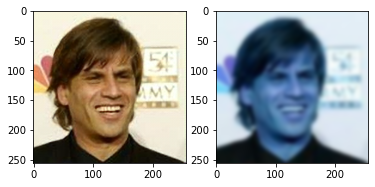

In [49]:
plt.subplot(1,2,1)
plt.imshow(predicted_high[0])

plt.subplot(1,2,2)
plt.imshow(Bush_train_not_George_low[0])

In [20]:
# withhold final test data
bush_train, bush_test = train_test_split(GWB_data, test_size=0.2)
#  It is also useful to reserve a validation set in the training data, for use in the model construction
bush_train, bush_val = train_test_split(bush_train,test_size=0.2)

In [21]:
# initialize sequential network
from keras.models import Sequential
# include convolutional layers
from keras.layers import Conv2D
# Pooling layers
from keras.layers import MaxPooling2D
# flatten layers into single vector
from keras.layers import Flatten
from keras.layers import Dense

In [ ]:
# use sequential classifier - standard CNN implementation with straightforward single input
Bush_classifier = Sequential()

Bush_classifier.add(Conv2D(32, (3, 3), input_shape = (250, 250, 3), activation = 'relu'))


Bush_classifier.add(MaxPooling2D(pool_size = (2, 2)))
Bush_classifier.add(Flatten())
Bush_classifier.add(Dense(units = 128, activation = 'relu'))
Bush_classifier.add(Dense(units = 1, activation = 'sigmoid'))

Bush_classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [26]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
shear_range = 0.2,
zoom_range = 0.2,
horizontal_flip = True)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,validation_split=0.3)
Bush_training_set = train_datagen.flow_from_directory('datasets/high/Bush_train/',
                                                 target_size = (250, 250),
                                                 batch_size = 1,
                                                 class_mode = 'binary')
Bush_val_set = test_datagen.flow_from_directory('datasets/high/Bush_val/',
                                            target_size = (250, 250),
                                            batch_size = 1,
                                            class_mode = 'binary')
Bush_test_set = test_datagen.flow_from_directory('datasets/high/Bush_test/',
                                            target_size = (250, 250),
                                            batch_size = 1,
                                            class_mode = 'binary')

Found 678 images belonging to 2 classes.
Found 170 images belonging to 2 classes.
Found 212 images belonging to 2 classes.


In [27]:
Bush_history = Bush_classifier.fit(Bush_training_set,
             # set steps per epoch equal to the number of training images
             steps_per_epoch = 22,
             # there is a six hour runtime limit on Kaggle Kernels, restricting the maximum epoch number
             epochs = 8,
             validation_data = Bush_val_set,
             validation_steps = 100)

Epoch 1/8
22/22 [==============================] - 16s 665ms/step - loss: 13.1812 - accuracy: 0.4091 - val_loss: 5.8667 - val_accuracy: 0.4700
Epoch 2/8
22/22 [==============================] - 13s 603ms/step - loss: 1.7922 - accuracy: 0.6364 - val_loss: 1.3952 - val_accuracy: 0.5100
Epoch 3/8
22/22 [==============================] - 15s 679ms/step - loss: 2.3640 - accuracy: 0.7727 - val_loss: 0.8671 - val_accuracy: 0.6000
Epoch 4/8
22/22 [==============================] - 13s 575ms/step - loss: 1.0457 - accuracy: 0.5000 - val_loss: 0.7231 - val_accuracy: 0.5800
Epoch 5/8
22/22 [==============================] - 12s 554ms/step - loss: 0.5815 - accuracy: 0.7273 - val_loss: 1.0172 - val_accuracy: 0.6000
Epoch 6/8
22/22 [==============================] - 13s 579ms/step - loss: 0.7160 - accuracy: 0.5909 - val_loss: 0.6895 - val_accuracy: 0.6500
Epoch 7/8
22/22 [==============================] - 12s 564ms/step - loss: 1.1010 - accuracy: 0.5455 - val_loss: 0.6514 - val_accuracy: 0.6600
Epoch

In [28]:
Bush_classifier.save('my_model.h5')

In [29]:
Bush_classifier.fit(Bush_training_set, validation_data = Bush_val_set)
filename = 'finalized_model.sav'
pickle.dump(Bush_classifier, open(filename, 'wb'))

678/678 [==============================] - 266s 392ms/step - loss: 0.6743 - accuracy: 0.6504 - val_loss: 0.6927 - val_accuracy: 0.6294


INFO:tensorflow:Assets written to: ram://c83b5c45-760d-4342-9d80-64b6a2da2e46/assets


INFO:tensorflow:Assets written to: ram://c83b5c45-760d-4342-9d80-64b6a2da2e46/assets


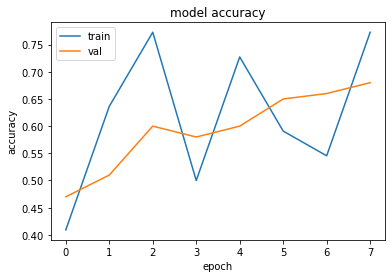

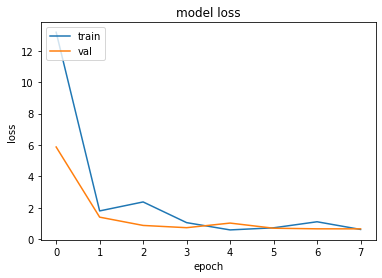

In [30]:
plt.plot(Bush_history.history['accuracy'])
plt.plot(Bush_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(Bush_history.history['loss'])
plt.plot(Bush_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [31]:
#================
# Predict Model
#================
prediction = Bush_classifier.predict(Bush_test_set)
#-----------------------------------------
print(prediction[0])

212/212 [==============================] - 9s 41ms/step
[0.16376144]


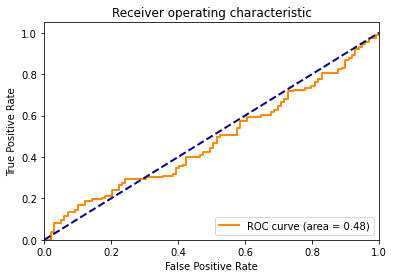

In [32]:
# ROC curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds  = roc_curve(Bush_test_set.classes, prediction)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# # Sensitivity
# recall = tpr

# # Specificity
# specificity = 1 - fpr

In [33]:
from keras.preprocessing import image
import tensorflow as tf

# create a function to predict class of images in a directory, given a trained classifier
def predictions(dir_name,classifier,binary):
    # dir_name should include name of predicted invididual - could edit this to iterate through folders in future
    predictions = []
    for im in os.listdir(dir_name):
        test_image = keras.utils.load_img(dir_name + str(im), target_size = (250,250))
        test_image = keras.utils.img_to_array(test_image)
        test_image = np.expand_dims(test_image, axis = 0)
        if(binary is True):
            result = float(str(classifier.predict(test_image))[2])
        else: 
            result = np.argmax(classifier.predict(test_image))
        predictions.append(result)
    return(predictions)

In [34]:
# classes are passed through the algorithm in a random order - we want to retrieve the order of the classes
Bush_test_names = []
# collect all file names
for i in range(len(Bush_test_set.filenames)):
    Bush_test_names.append(Bush_test_set.filenames[i])
# extract unique names, in order
for i in range(len(Bush_test_names)):
    Bush_test_names[i] = Bush_test_names[i].split("/")[0]
Bush_test_name_order = list(OrderedDict.fromkeys(Bush_test_names))

In [50]:

imag_name=Bush_test_name_order[0].replace("\\", "/")
ch = '/'
imag_name = imag_name.split(ch, 1)[0]


Bush_test_name_order=Bush_test_name_order[1].replace("\\", "/")
ch = '/'
Bush_test_name_order = Bush_test_name_order.split(ch, 1)[0]

Bush_predictions_0 = predictions('datasets/high/Bush_test/'+ imag_name+ "/",Bush_classifier,binary = True)
Bush_predictions_1 = predictions('datasets/high/Bush_test/'+ Bush_test_name_order+ "/" ,Bush_classifier, binary = True)




FileNotFoundError: [WinError 3] The system cannot find the path specified: 'datasets/high/Bush_test/G/'